In [1]:
library(rdmc)
library(magick)
library(tidyverse)
library(ape)

library(patchwork)
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)

tts <- 20
tts_small <- 16
theme_set(theme_classic(tts))

source("../color_df.R")

color_df <-
    color_df %>% 
    mutate(
        ssp_pop = pop,
        pop = str_remove_all(ssp_pop, "(LR_|Teo_|random1_|random2_)")
    ) %>% 
    dplyr::select(-ssp_pop) %>% 
    distinct()
color_df

Loading required package: MASS

Loading required package: dplyr


Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyr

Loading required package: purrr

Loading required package: magrittr


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: rlang


Attaching package: ‘rlang’


The following object is masked from ‘package:magrittr’:

    set_names


The following objects are masked from ‘package:purrr’:

    %@%, as_function, flatten, flatten_chr, flatten_dbl, flatten_int,
    flatten_lgl, flatten_raw, invoke, list_along, modify, prepend,
    splice


Linking to ImageMagick 7.0.10.28
Enabled features: ca

pop               color           
1 Los_Guajes        mediumaquamarine
2 Crucero_Lagunitas gold            
3 El_Rodeo          darkorange      
4 Amatlan_de_Canas  cornflowerblue  
5 San_Lorenzo       purple          
6 Palmar_Chico      violetred       
7 random            grey

In [2]:
plot_rdmc <- function(file, cle_low = -10, pos = NULL){
    
    sweep_file <- vroom::vroom(file, delim = "\t")
    
    stopifnot(nrow(sweep_file) > 0)
    all_mods <- 
        sweep_file  %>%  
        filter(!is.na(cle), !is.na(neut_cle)) %>%  
        group_by(model) %>% 
        mutate(mcle = max(cle, na.rm = T) - neut_cle)
  
    best_mcle <- all_mods %>%
      group_by(model) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      ungroup()  %>%
      arrange(desc(mcle))

    (best_mod <- best_mcle %>% slice(1) %>% pull(model))

    
    if(!missing(pos)){
      pos_plot <- all_mods %>%
      group_by(selected_sites, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>%   
      ggplot(aes(selected_sites, mcle, colour = model)) +
      geom_line() +
      geom_point() +
      geom_hline(yintercept = 0, lty = 2) +  
      xlab("Position") +
      ylab("Composite likelihood") +
      scale_color_brewer(palette = "Set1") +
      geom_vline(xintercept = pos)

    } else {
        
    pos_plot <- all_mods %>%
      group_by(selected_sites, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>%   
      ggplot(aes(selected_sites, mcle, colour = model)) +
      geom_line() +
      geom_point() +
      geom_hline(yintercept = 0, lty = 2) +  
      xlab("Position") +
      ylab("Composite likelihood") +
      scale_color_brewer(palette = "Set1")
        
    }



    #visualize likelihood surface wrt selection coefficients
    sel_plot <- all_mods %>%
      group_by(sels, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>%   
      ggplot(aes(log10(sels), mcle, colour = model)) +
      geom_line() +
      geom_point() +
      ylab("Composite likelihood") +
      xlab("Selection coefficient") +
      scale_color_brewer(palette = "Set1") 

    if (best_mod == "standing"){

        #visualize likelihood surface wrt age
        a  <- all_mods %>%
          group_by(times, model) %>%
          filter(model == best_mod) %>%
          summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
          ggplot(aes(log10(times), mcle, colour = model)) +
          geom_line() +
          geom_point() +
          ylab("Composite likelihood") +
          xlab("Age") +
          scale_color_brewer(palette = "Set1") 


        #visualize likelihood surface wrt age
        b <- all_mods %>%
          group_by(gs, model) %>%
          filter(model == best_mod) %>%
          summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
          ggplot(aes(gs, mcle, colour = model)) +
          geom_line() +
          geom_point() +
          ylab("Composite likelihood") +
          xlab("Initial allele frequency") +
          scale_color_brewer(palette = "Set1") 

        pos_plot + sel_plot + (a | b) + plot_layout(nrow = 3)

    } else if(best_mod == "migration"){
        
         a  <- all_mods %>%
          group_by(migs, model) %>%
          filter(model == best_mod) %>%
          summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
          ggplot(aes(log10(migs), mcle, colour = model)) +
          geom_line() +
          geom_point() +
          ylab("Composite likelihood") +
          xlab("Migration rate") +
          scale_color_brewer(palette = "Set1") 

        b  <- all_mods %>%
          group_by(sources, model) %>%
          filter(model == best_mod) %>%
          summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
          filter(mcle > cle_low) %>%
          ggplot(aes(factor(sources), mcle, colour = model)) +
          geom_point(size = 3) +
          ylab("Composite likelihood") +
          xlab("Source pop") +
          scale_color_brewer(palette = "Set1") 

        pos_plot + sel_plot + (a | b) + plot_layout(nrow = 3)

    }

}

[1] "branching, tb1"


Rows: 6,900
Columns: 18
Delimiter: "\t"
chr [ 4]: locus, sel_pops, model, sel_pop_ids
dbl [14]: selected_sites, sels, cle, gs, times, migs, sources, neut_cle, n_snps, sweepsize...

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

`summarise()` has grouped output by 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'selected_sites', 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'sels', 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'migs', 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'sources', 'model'. You can override using the `.groups` argument.



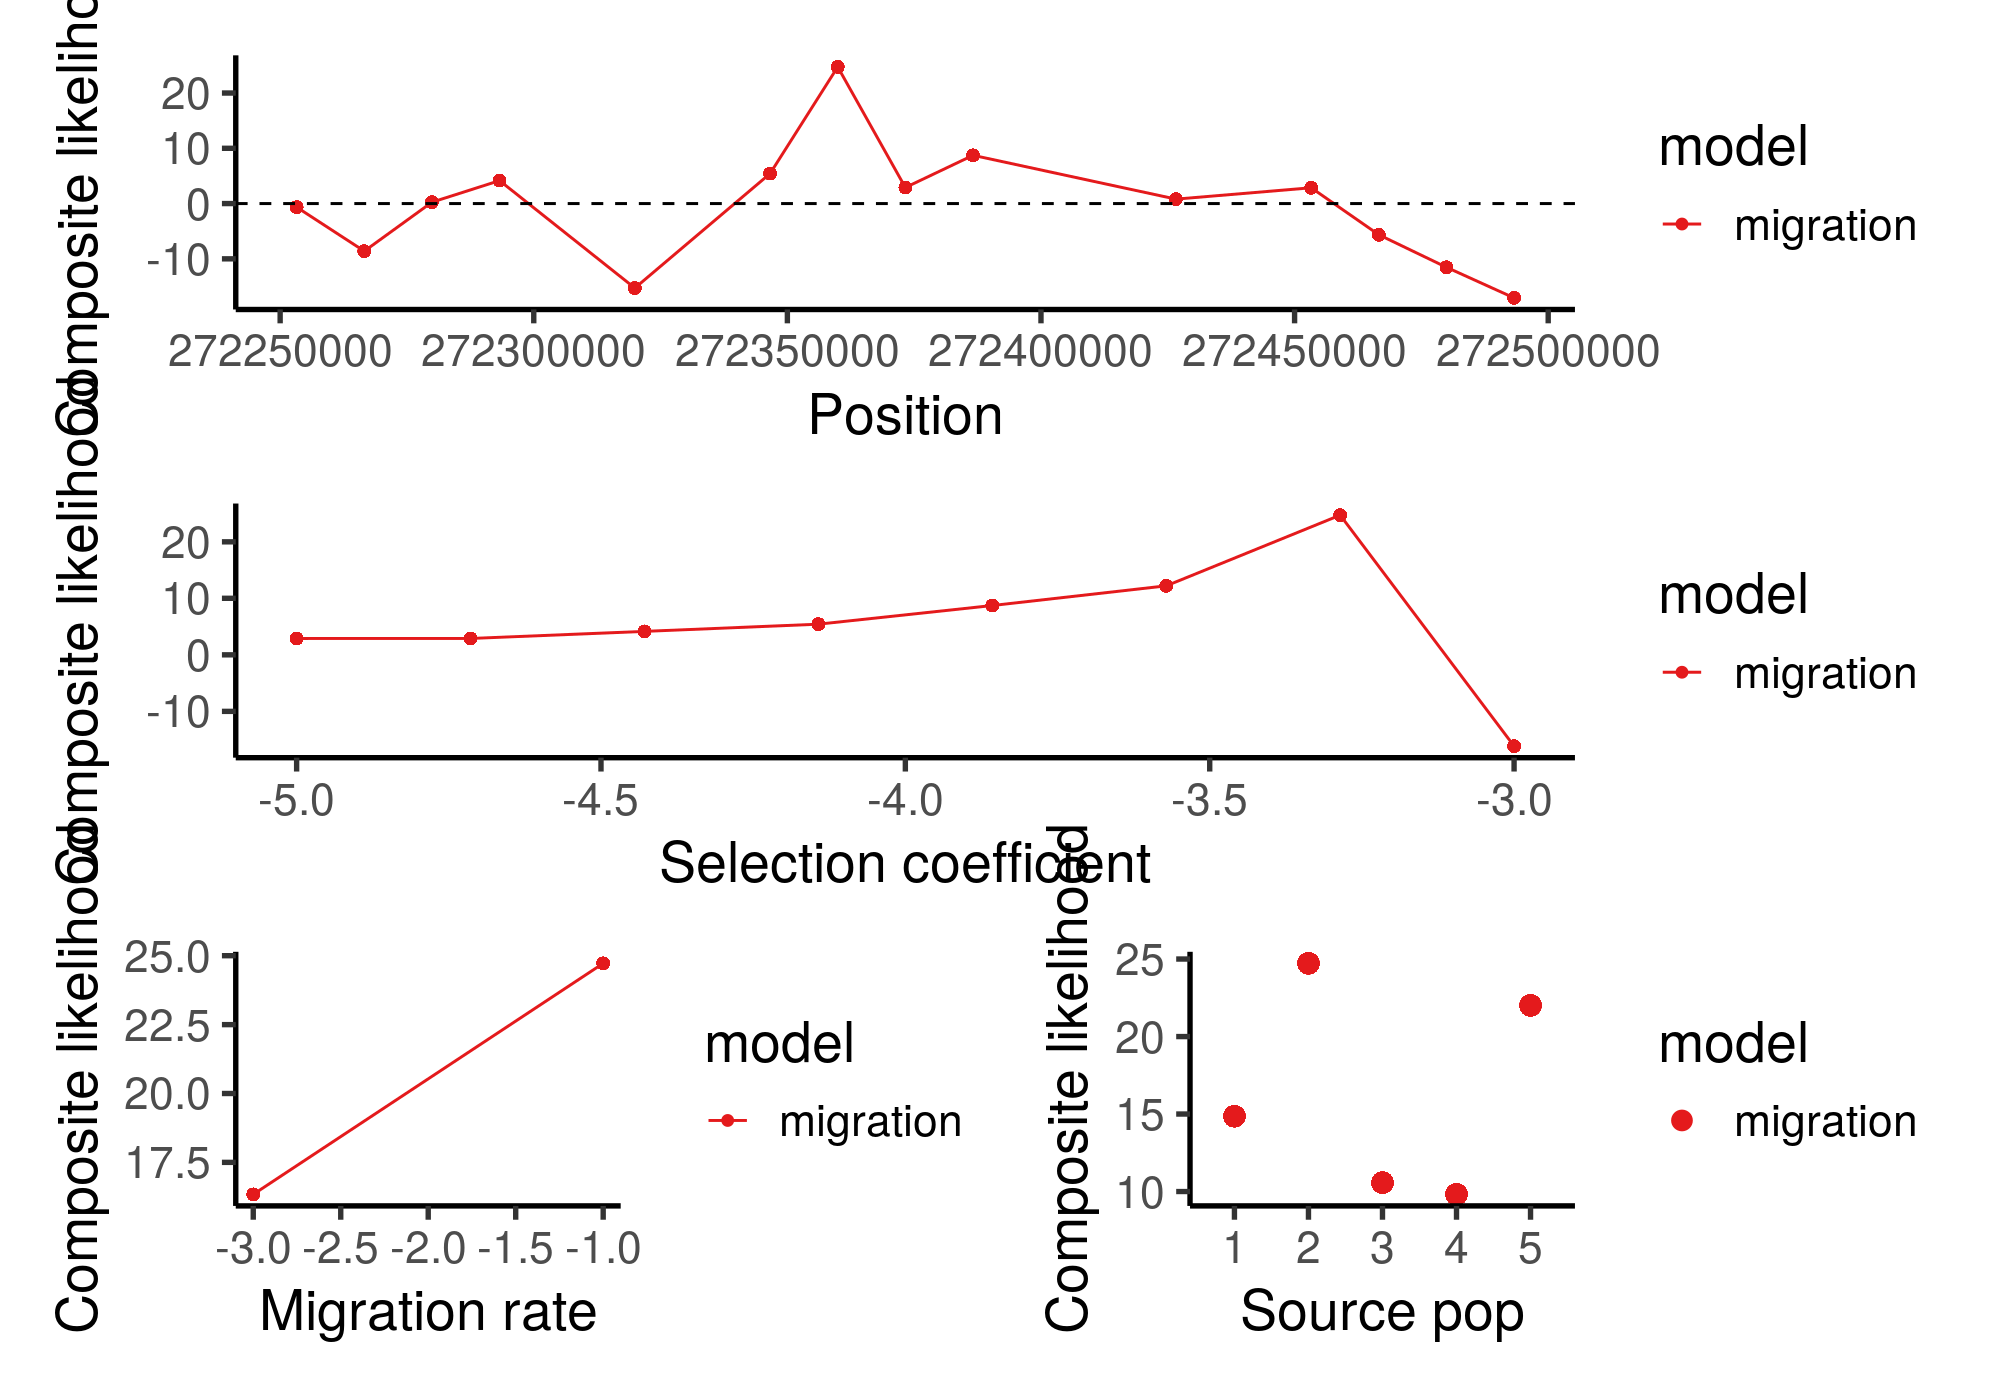

In [3]:
print("branching, tb1")
plot_rdmc("../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start272261071_end272472669_pops1-2-3-4-5.txt", cle_low = -20)


[1] "startch synth, bt2"


Rows: 7,500
Columns: 18
Delimiter: "\t"
chr [ 4]: locus, sel_pops, model, sel_pop_ids
dbl [14]: selected_sites, sels, cle, gs, times, migs, sources, neut_cle, n_snps, sweepsize...

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

`summarise()` has grouped output by 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'selected_sites', 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'sels', 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'migs', 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'sources', 'model'. You can override using the `.groups` argument.



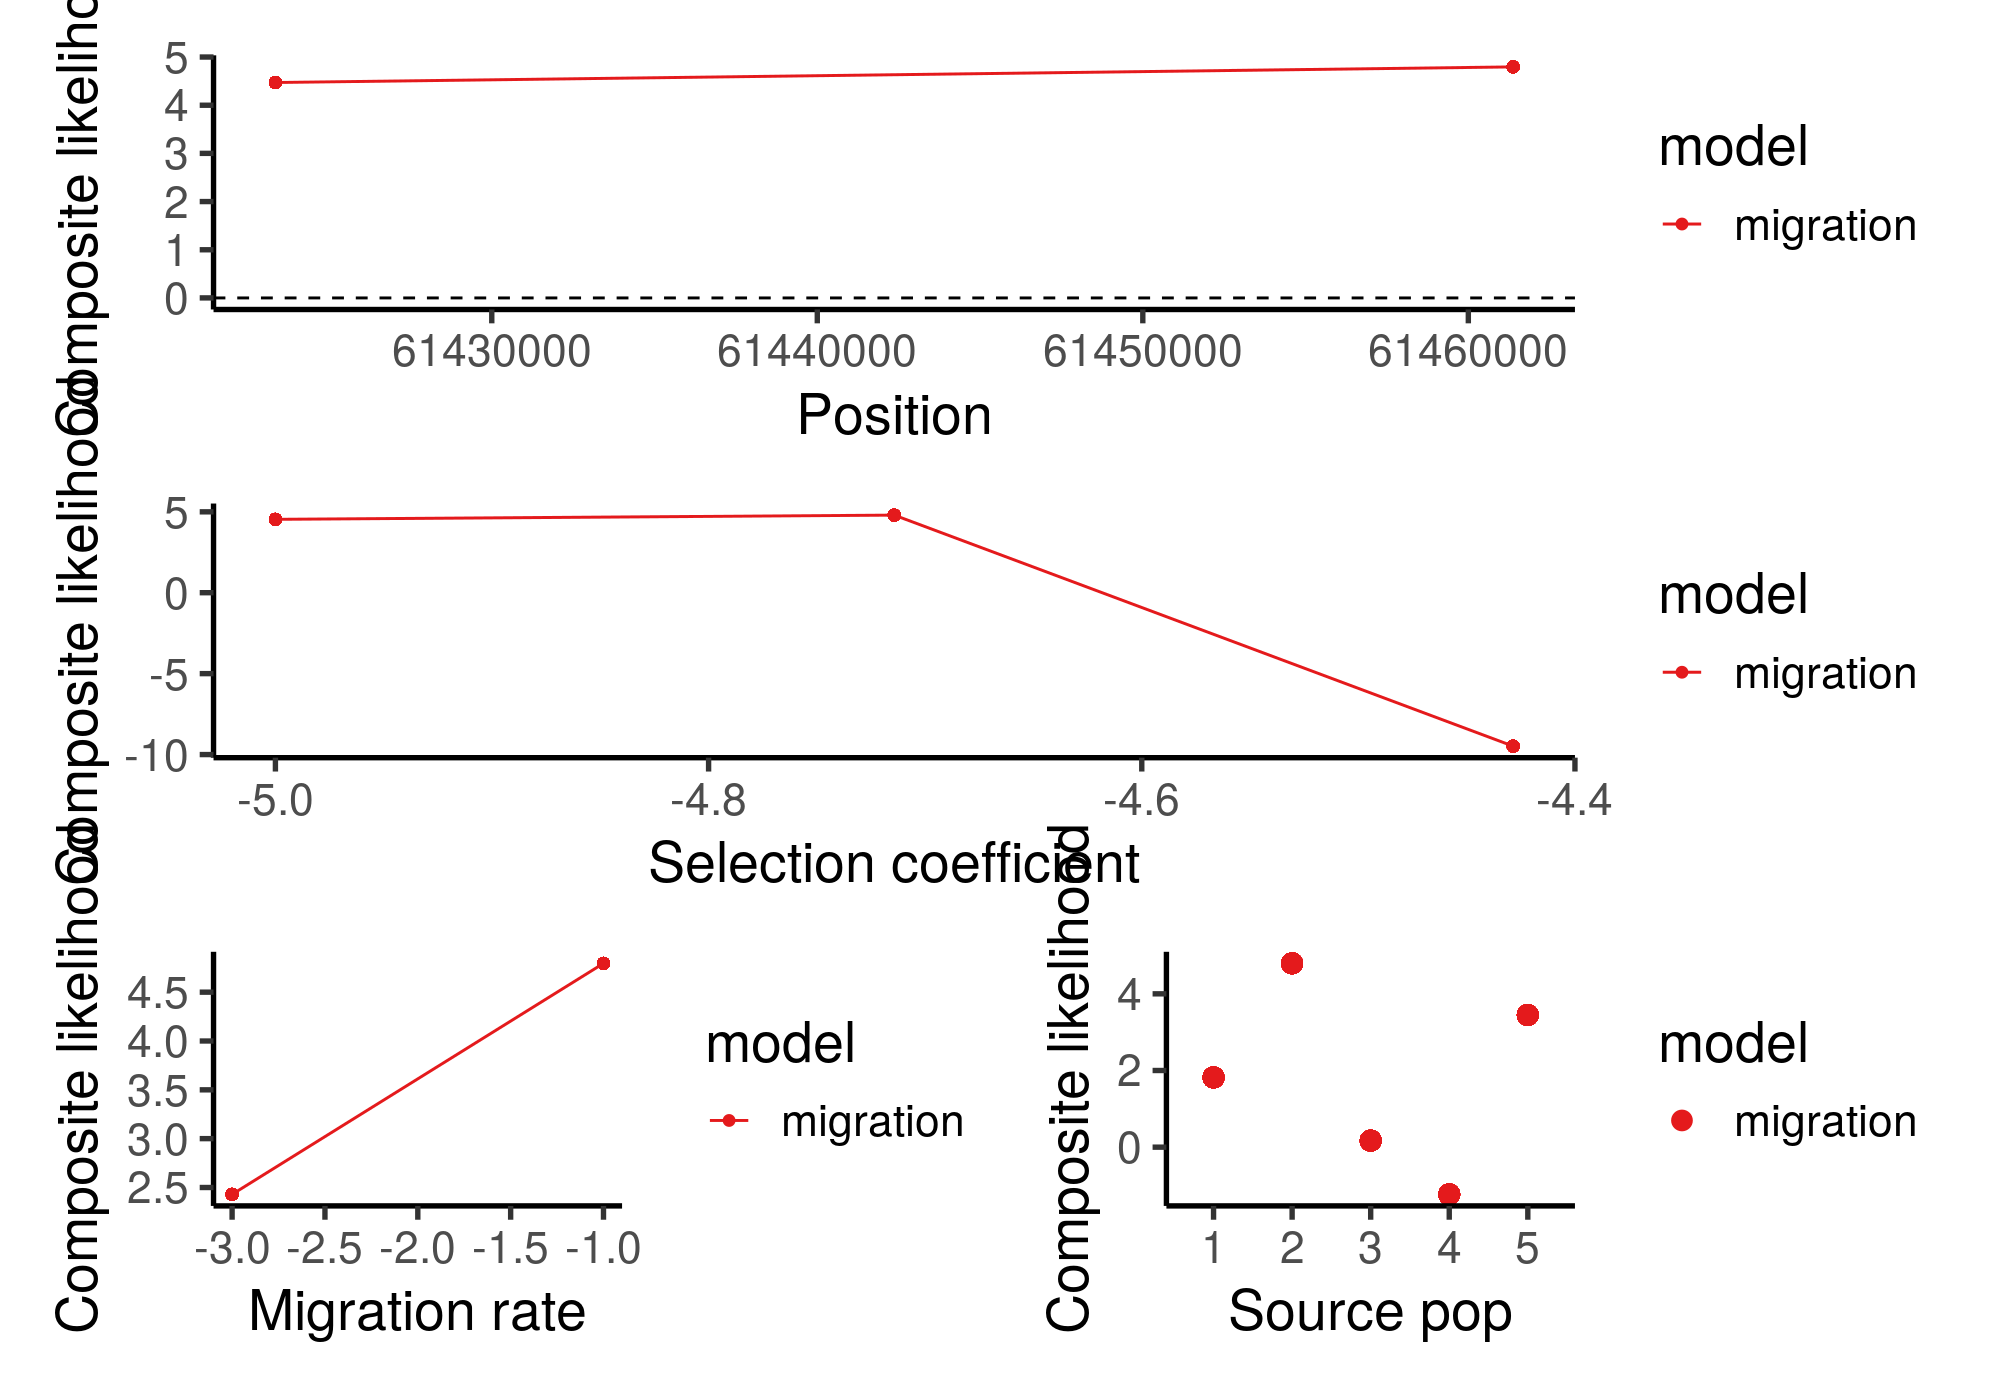

In [4]:
print("startch synth, bt2")
plot_rdmc("../data/rdmc/fitted/v5--sweep_chr4--0--250330460_start60951507_end61558027_pops1-2-3-4-5-10.txt", cle_low = -10)

[1] "seed shattering,ZmSh1-1"


Rows: 5,700
Columns: 18
Delimiter: "\t"
chr [ 4]: locus, sel_pops, model, sel_pop_ids
dbl [14]: selected_sites, sels, cle, gs, times, migs, sources, neut_cle, n_snps, sweepsize...

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

`summarise()` has grouped output by 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'selected_sites', 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'sels', 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'migs', 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'sources', 'model'. You can override using the `.groups` argument.



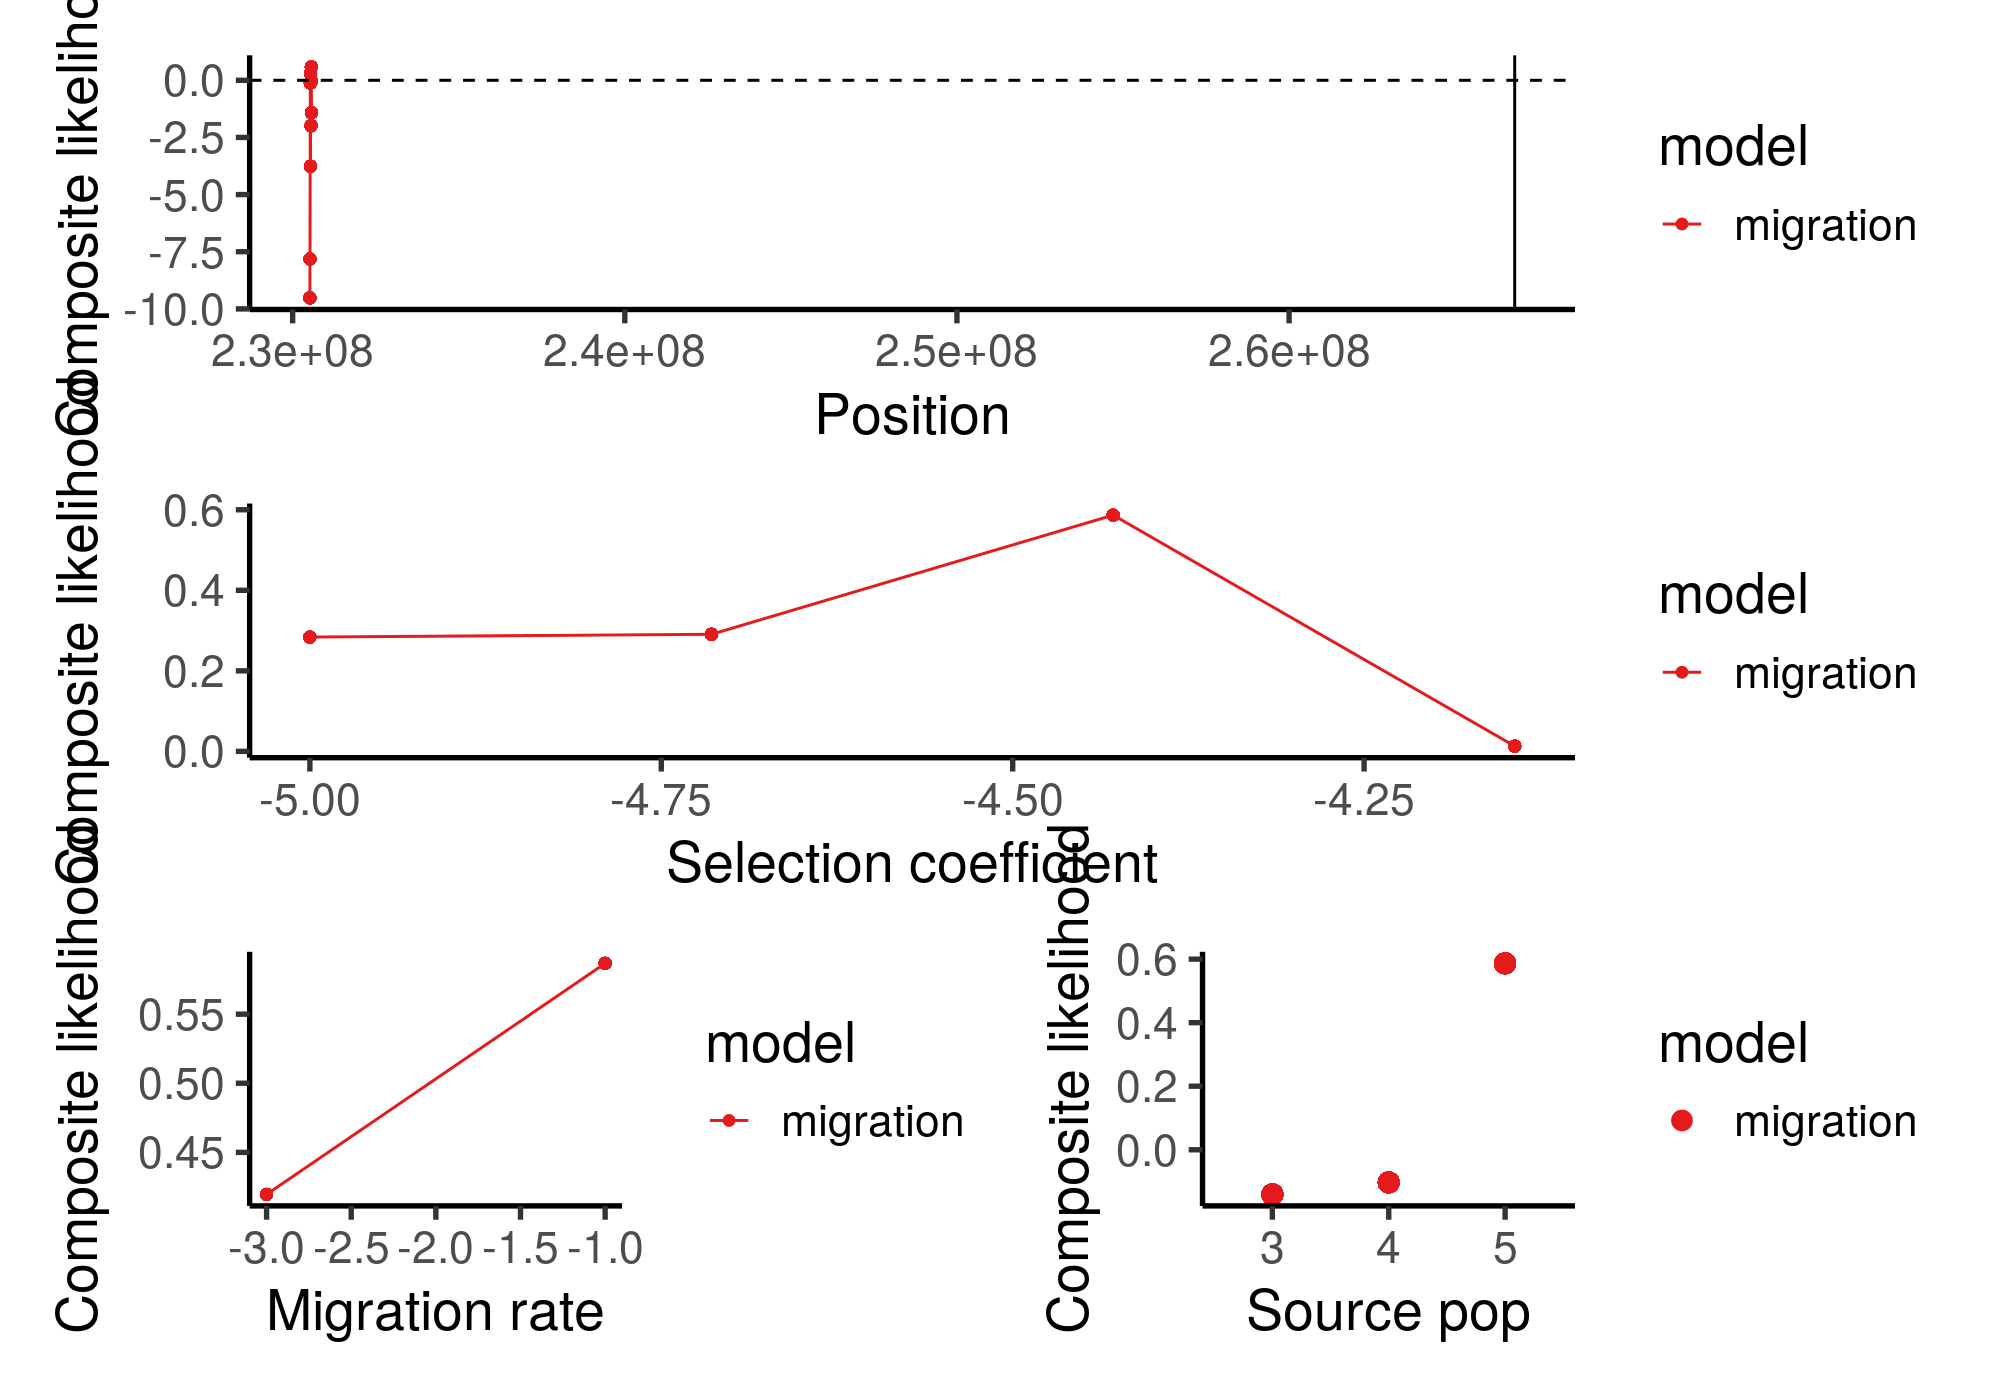

In [5]:
print("seed shattering,ZmSh1-1")
plot_rdmc("../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start230510870_end230574345_pops3-4-5.txt",  pos = 266792813)

[1] "starch biosynthesis,su1"


Rows: 5,700
Columns: 18
Delimiter: "\t"
chr [ 4]: locus, sel_pops, model, sel_pop_ids
dbl [14]: selected_sites, sels, cle, gs, times, migs, sources, neut_cle, n_snps, sweepsize...

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

`summarise()` has grouped output by 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'selected_sites', 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'sels', 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'times', 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'gs', 'model'. You can override using the `.groups` argument.



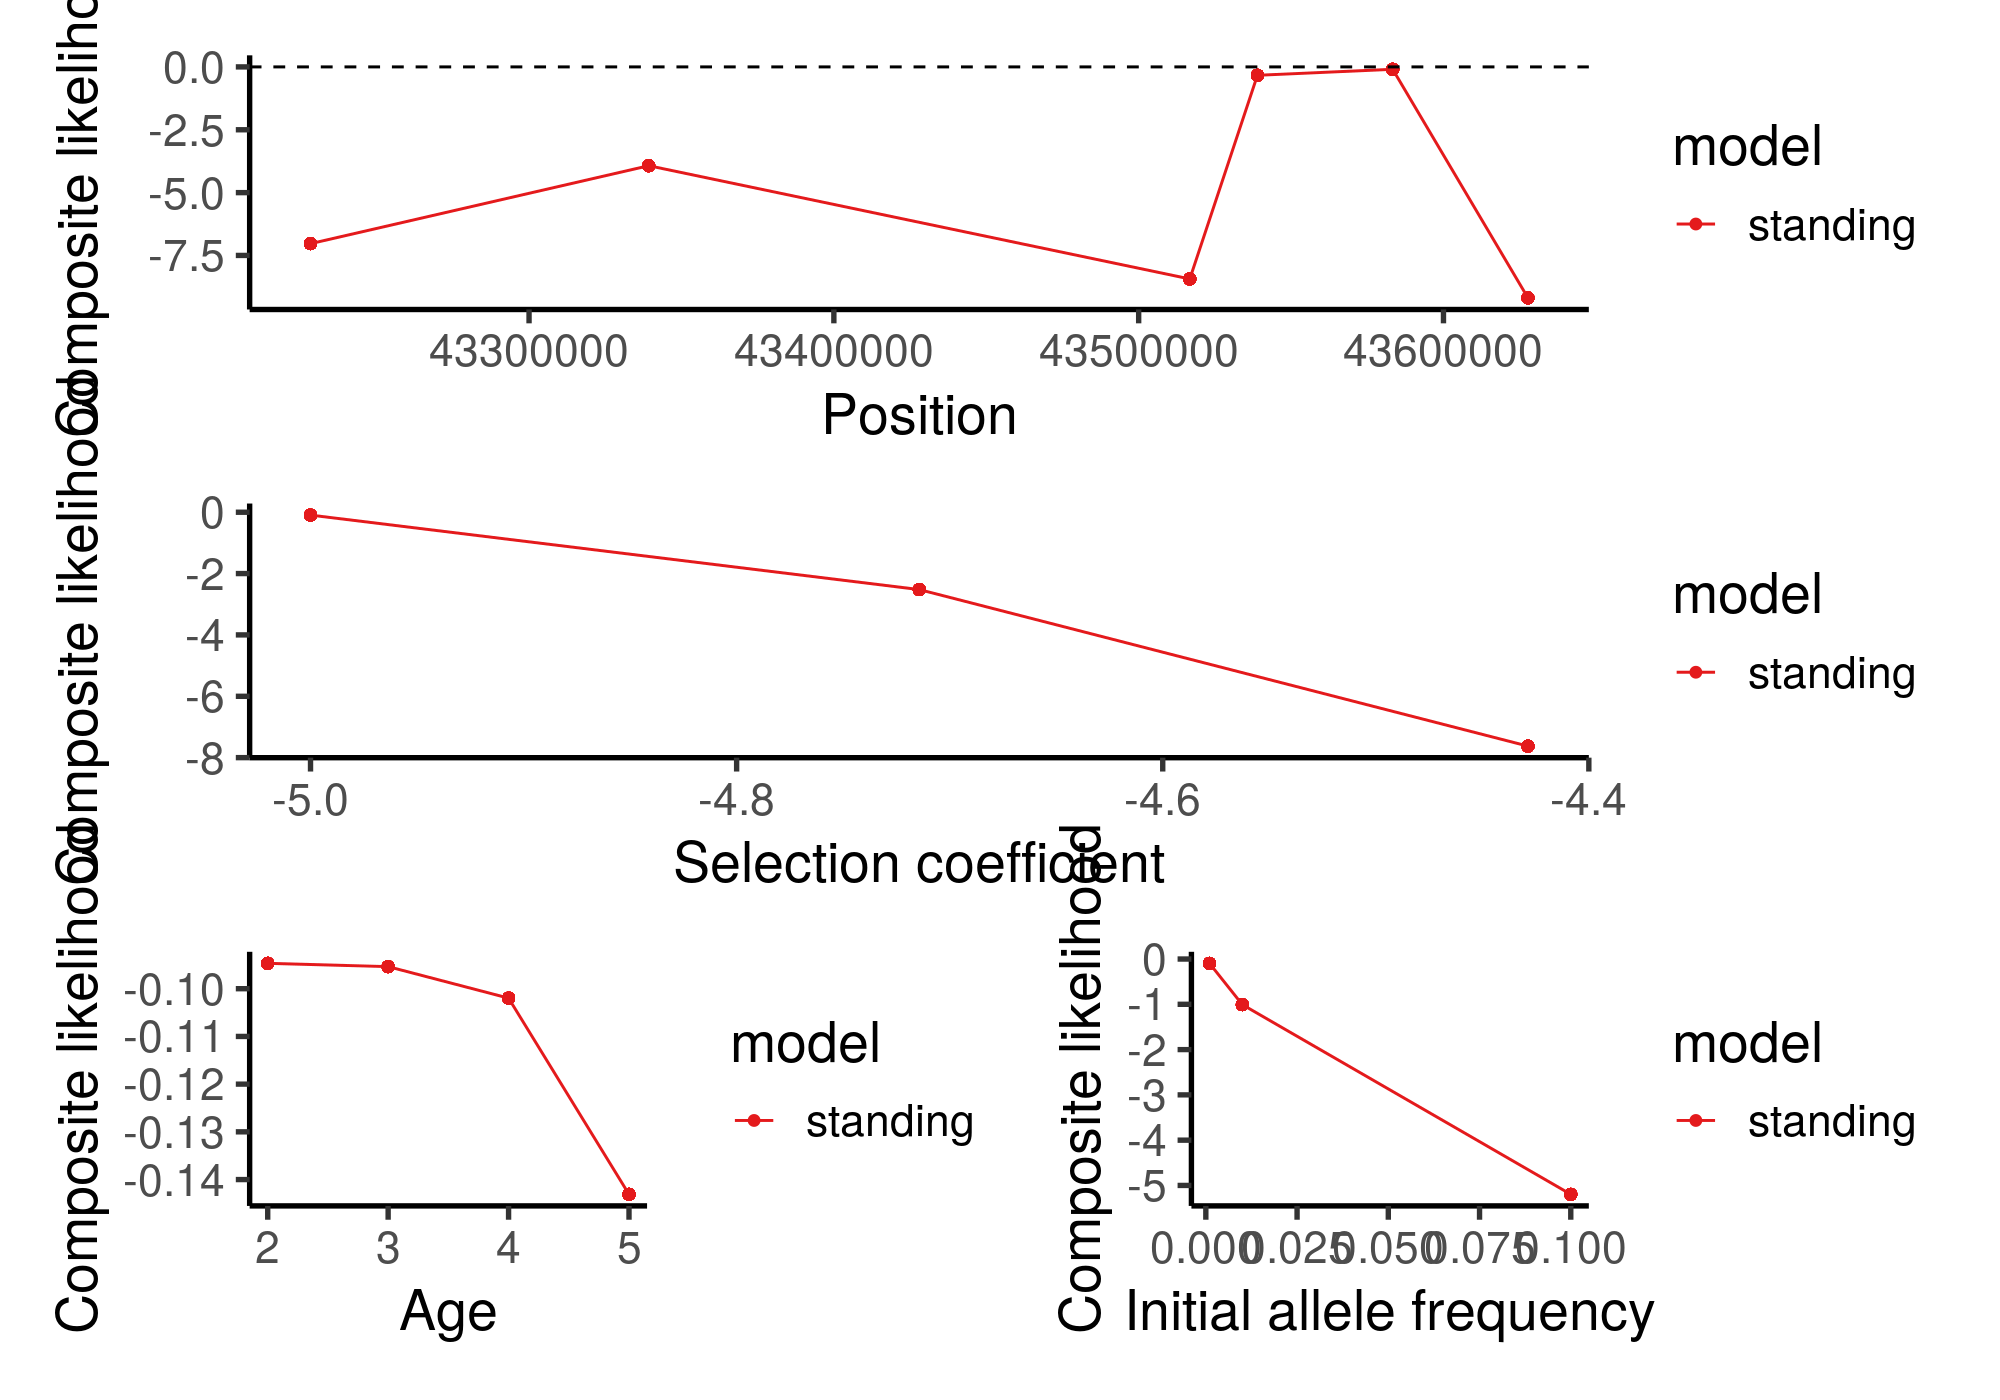

In [6]:
print("starch biosynthesis,su1")
plot_rdmc("../data/rdmc/fitted/v5--sweep_chr4--0--250330460_start43263146_end43615149_pops2-3-4.txt")

[1] "sugar transport and seed size,sweet4c"


Rows: 6,300
Columns: 18
Delimiter: "\t"
chr [ 4]: locus, sel_pops, model, sel_pop_ids
dbl [14]: selected_sites, sels, cle, gs, times, migs, sources, neut_cle, n_snps, sweepsize...

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

`summarise()` has grouped output by 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'selected_sites', 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'sels', 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'times', 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'gs', 'model'. You can override using the `.groups` argument.



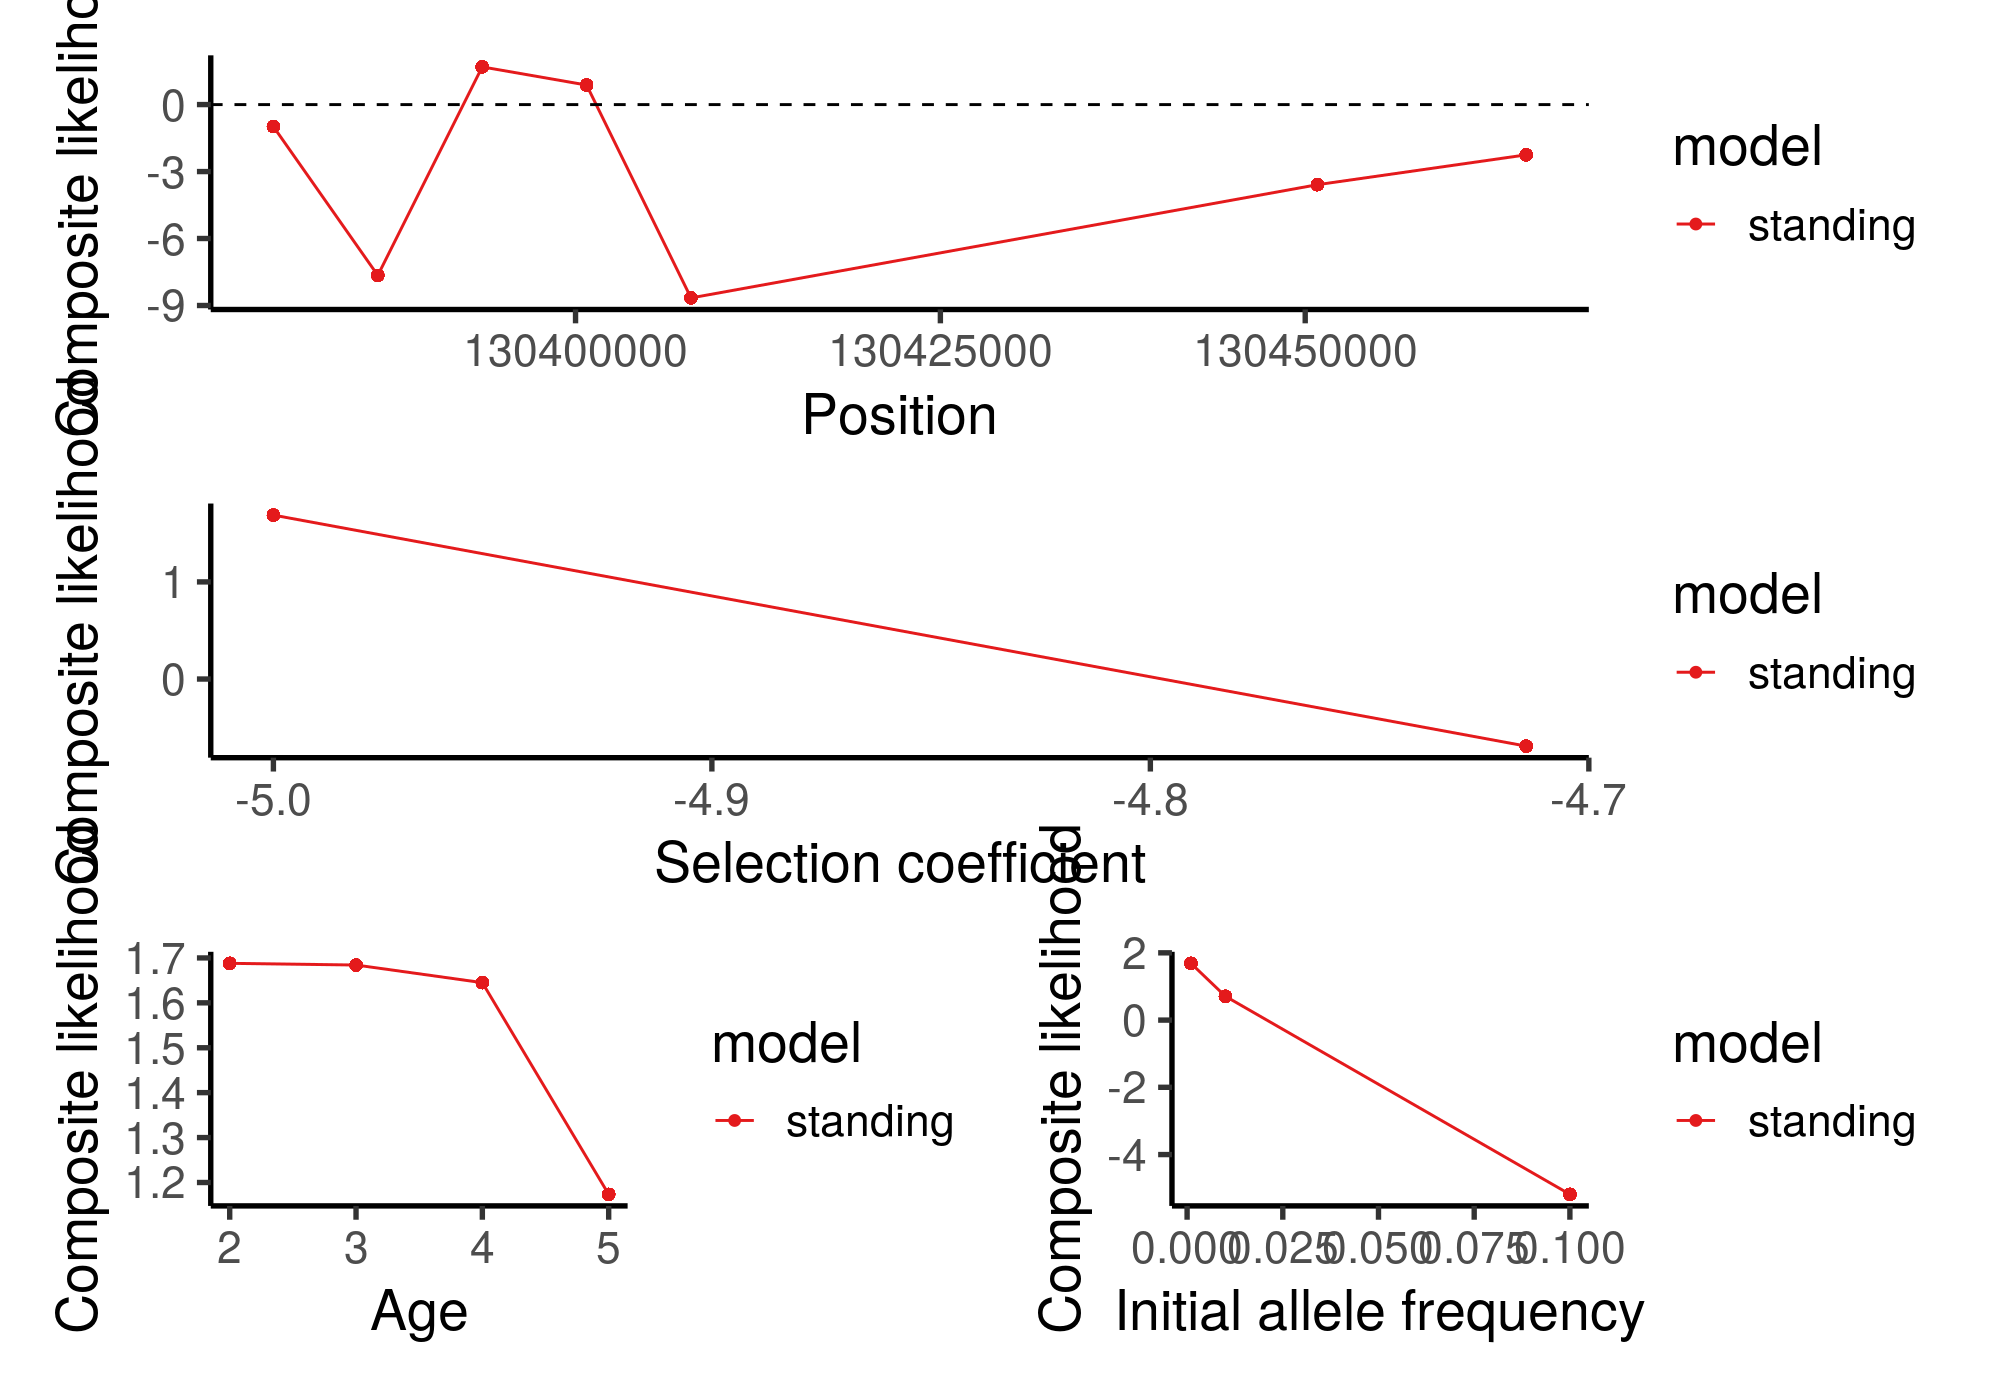

In [7]:
print("sugar transport and seed size,sweet4c")
plot_rdmc("../data/rdmc/fitted/v5--sweep_chr5--0--226353449_start130340943_end130464598_pops1-2-4-5.txt")

In [8]:
all_mods <- vroom::vroom("../data/rdmc/fitted/v5--sweep_chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt", delim = "\t")

range(vroom::vroom("../data/rdmc/fitted/v5--sweep_chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt", delim = "\t")$cle, na.rm = T)


all_mods %>%
    filter(is.na(cle))

Rows: 7,500
Columns: 18
Delimiter: "\t"
chr [ 4]: locus, sel_pops, model, sel_pop_ids
dbl [14]: selected_sites, sels, cle, gs, times, migs, sources, neut_cle, n_snps, sweepsize...

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 7,500
Columns: 18
Delimiter: "\t"
chr [ 4]: locus, sel_pops, model, sel_pop_ids
dbl [14]: selected_sites, sels, cle, gs, times, migs, sources, neut_cle, n_snps, sweepsize...

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] -260839.9  376290.7

selected_sites sels         cle
1    95855838       1.000000e-05 NA 
2    95855838       1.000000e-05 NA 
3    95855838       1.000000e-05 NA 
4    95855838       1.000000e-05 NA 
5    95855838       1.000000e-05 NA 
6    95855838       1.000000e-05 NA 
7    95855838       1.000000e-05 NA 
8    95855838       1.000000e-05 NA 
9    95855838       1.000000e-05 NA 
10   95855838       1.000000e-05 NA 
11   95855838       1.000000e-05 NA 
12   95855838       1.000000e-05 NA 
13   95855838       1.930698e-05 NA 
14   95855838       1.930698e-05 NA 
15   95855838       1.930698e-05 NA 
16   95855838       1.930698e-05 NA 
17   95855838       1.930698e-05 NA 
18   95855838       1.930698e-05 NA 
19   95855838       1.930698e-05 NA 
20   95855838       1.930698e-05 NA 
21   95855838       1.930698e-05 NA 
22   95855838       1.930698e-05 NA 
23   95855838       1.930698e-05 NA 
24   95855838       1.930698e-05 NA 
25   95855838       3.727594e-05 NA 
26   95855838       3.727594e-05 NA 
27   95855838       3.727594e-05 NA 
28   95855838       3.727594e-05 NA 
29   95855838       3.727594e-05 NA 
30   95855838       3.727594e-05 NA 
⋮    ⋮              ⋮            ⋮  
5767 96775455       0.01389495   NA 
5768 96775455       0.01389495   NA 
5769 96775455       0.01389495   NA 
5770 96775455       0.02682696   NA 
5771 96775455       0.02682696   NA 
5772 96775455       0.02682696   NA 
5773 96775455       0.02682696   NA 
5774 96775455       0.02682696   NA 
5775 96775455       0.02682696   NA 
5776 96775455       0.02682696   NA 
5777 96775455       0.02682696   NA 
5778 96775455       0.02682696   NA 
5779 96775455       0.05179475   NA 
5780 96775455       0.05179475   NA 
5781 96775455       0.05179475   NA 
5782 96775455       0.05179475   NA 
5783 96775455       0.05179475   NA 
5784 96775455       0.05179475   NA 
5785 96775455       0.05179475   NA 
5786 96775455       0.05179475   NA 
5787 96775455       0.05179475   NA 
5788 96775455       0.10000000   NA 
5789 96775455       0.10000000   NA 
5790 96775455       0.10000000   NA 
5791 96775455       0.10000000   NA 
5792 96775455       0.10000000   NA 
5793 96775455       0.10000000   NA 
5794 96775455       0.10000000   NA 
5795 96775455       0.10000000   NA 
5796 96775455       0.10000000   NA 
     locus                                                                                            
1    data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
2    data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
3    data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
4    data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
5    data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
6    data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
7    data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
8    data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
9    data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
10   data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
11   data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
12   data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
13   data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
14   data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
15   data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
16   data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95

In [9]:

suppressWarnings(
suppressMessages(

top_models_df <- fs::dir_ls(path = "../data/rdmc/fitted/") %>% 
    map_df(~{
            sweep_file <- vroom::vroom(.x, delim = "\t")
            if(nrow(sweep_file) > 0){
                sweep_file %>% 
                #filter(!is.na(cle), !is.na(neut_cle), !neut_cle %in% c(-Inf, Inf), !cle %in% c(-Inf, Inf)) %>%  
                group_by(model) %>%
                filter(cle == max(cle, na.rm=T)) %>%
                mutate(mcle = cle - neut_cle) %>%
                ungroup() %>%
                mutate(mcle_delta = mcle - max(mcle, na.rm=T)) %>%
                arrange(desc(mcle)) %>%  
                slice(1:2) %>%
                mutate(mcle_nextbest_diff = -diff(mcle)) %>% 
                slice(1) %>%
                mutate(file_name = .x)
            } else{
                tibble()
            }
            
    }) %>% 
    mutate(populations = sel_pop_ids) %>% 
    mutate(populations = str_remove_all(populations, "data/raisd/"),
           populations = str_remove_all(populations, ".corrected_block_outliers_merged.txt"),
           populations = str_replace_all(populations, "random1", "RANDOM1"),
           populations = str_replace_all(populations, "random2", "RANDOM2"),
           type = case_when(
               grepl("LR", populations) & grepl("Teo", populations) ~ "both",
               grepl("LR", populations) & !grepl("Teo", populations) ~ "Landraces",
               !grepl("LR", populations) & grepl("Teo", populations) ~ "Teosinte",
               TRUE ~ "nan"
    ),
        pop_count = str_count(populations, ";")+1,
        Landraces_count = str_count(populations, "LR"),
        Teosinte_count =  str_count(populations, "Teo")        
        )
    
))

In [10]:
top_models_df  <- top_models_df %>% mutate(model2 = ifelse(mcle < 0, "neutral", model))

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


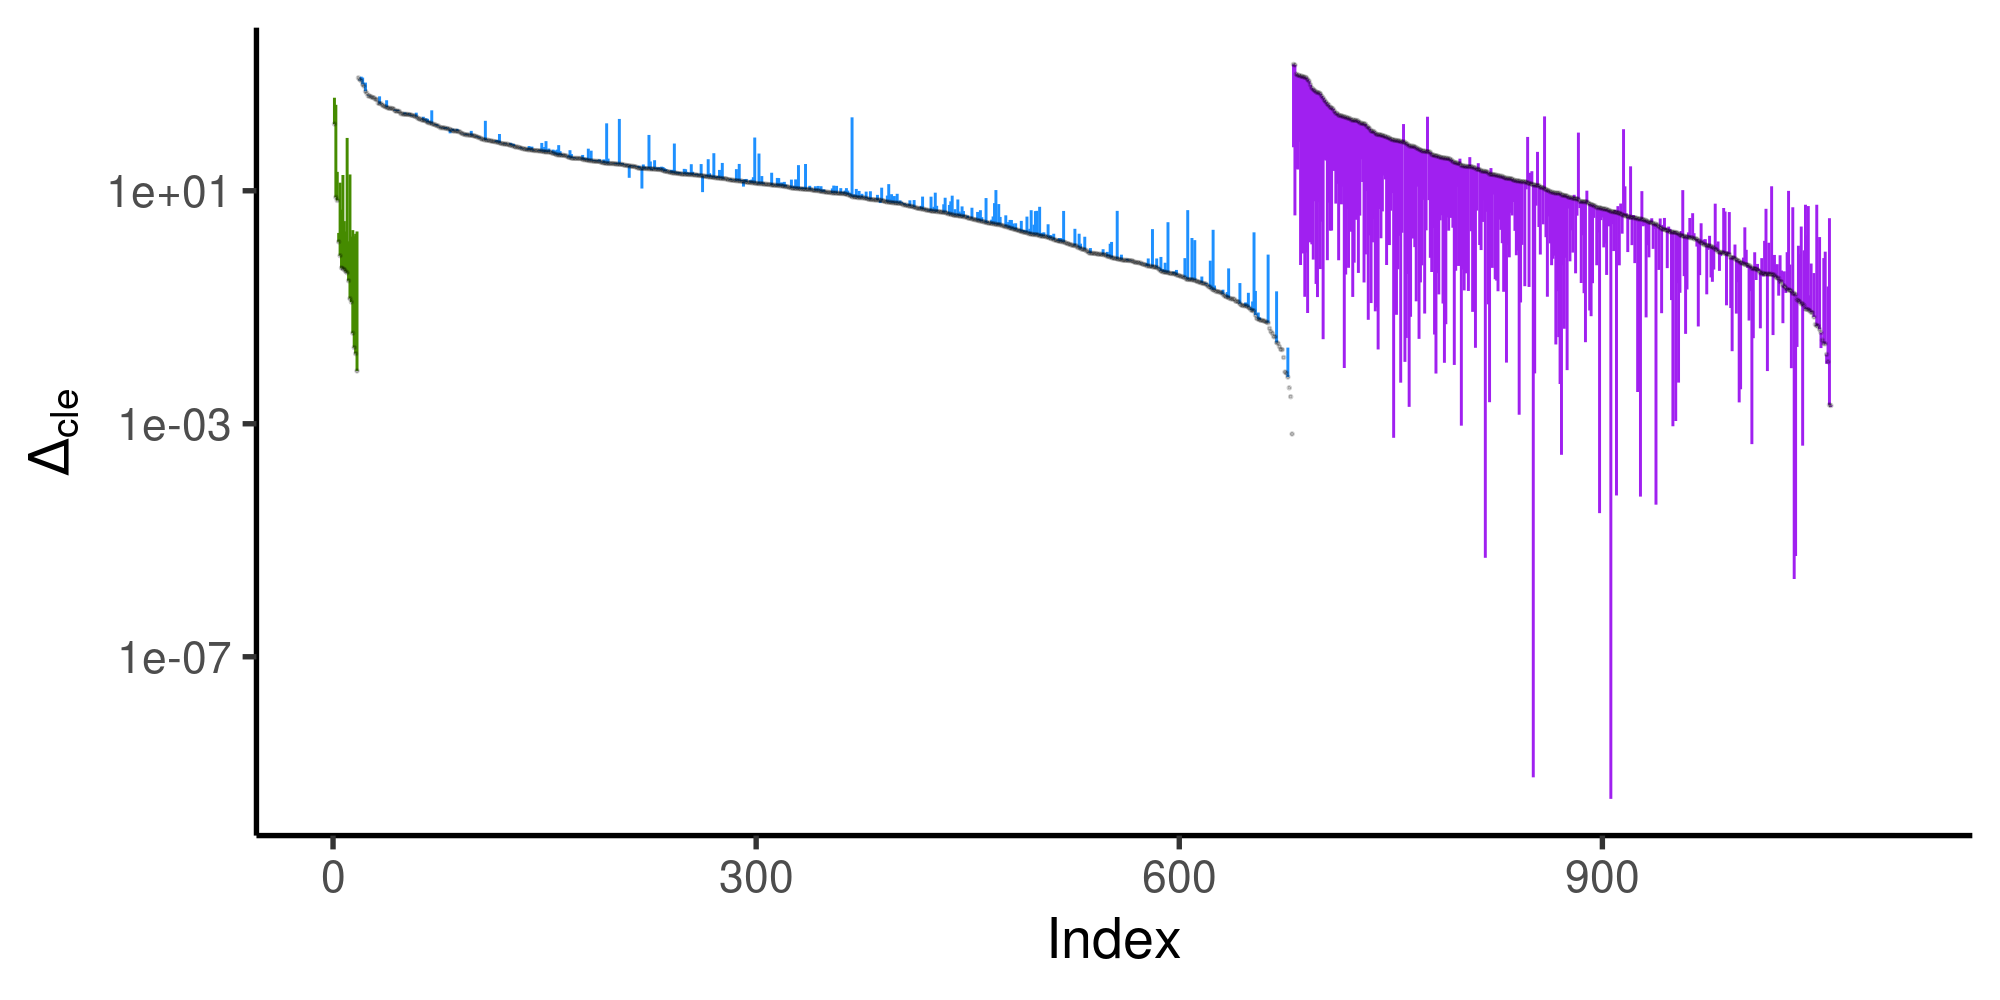

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


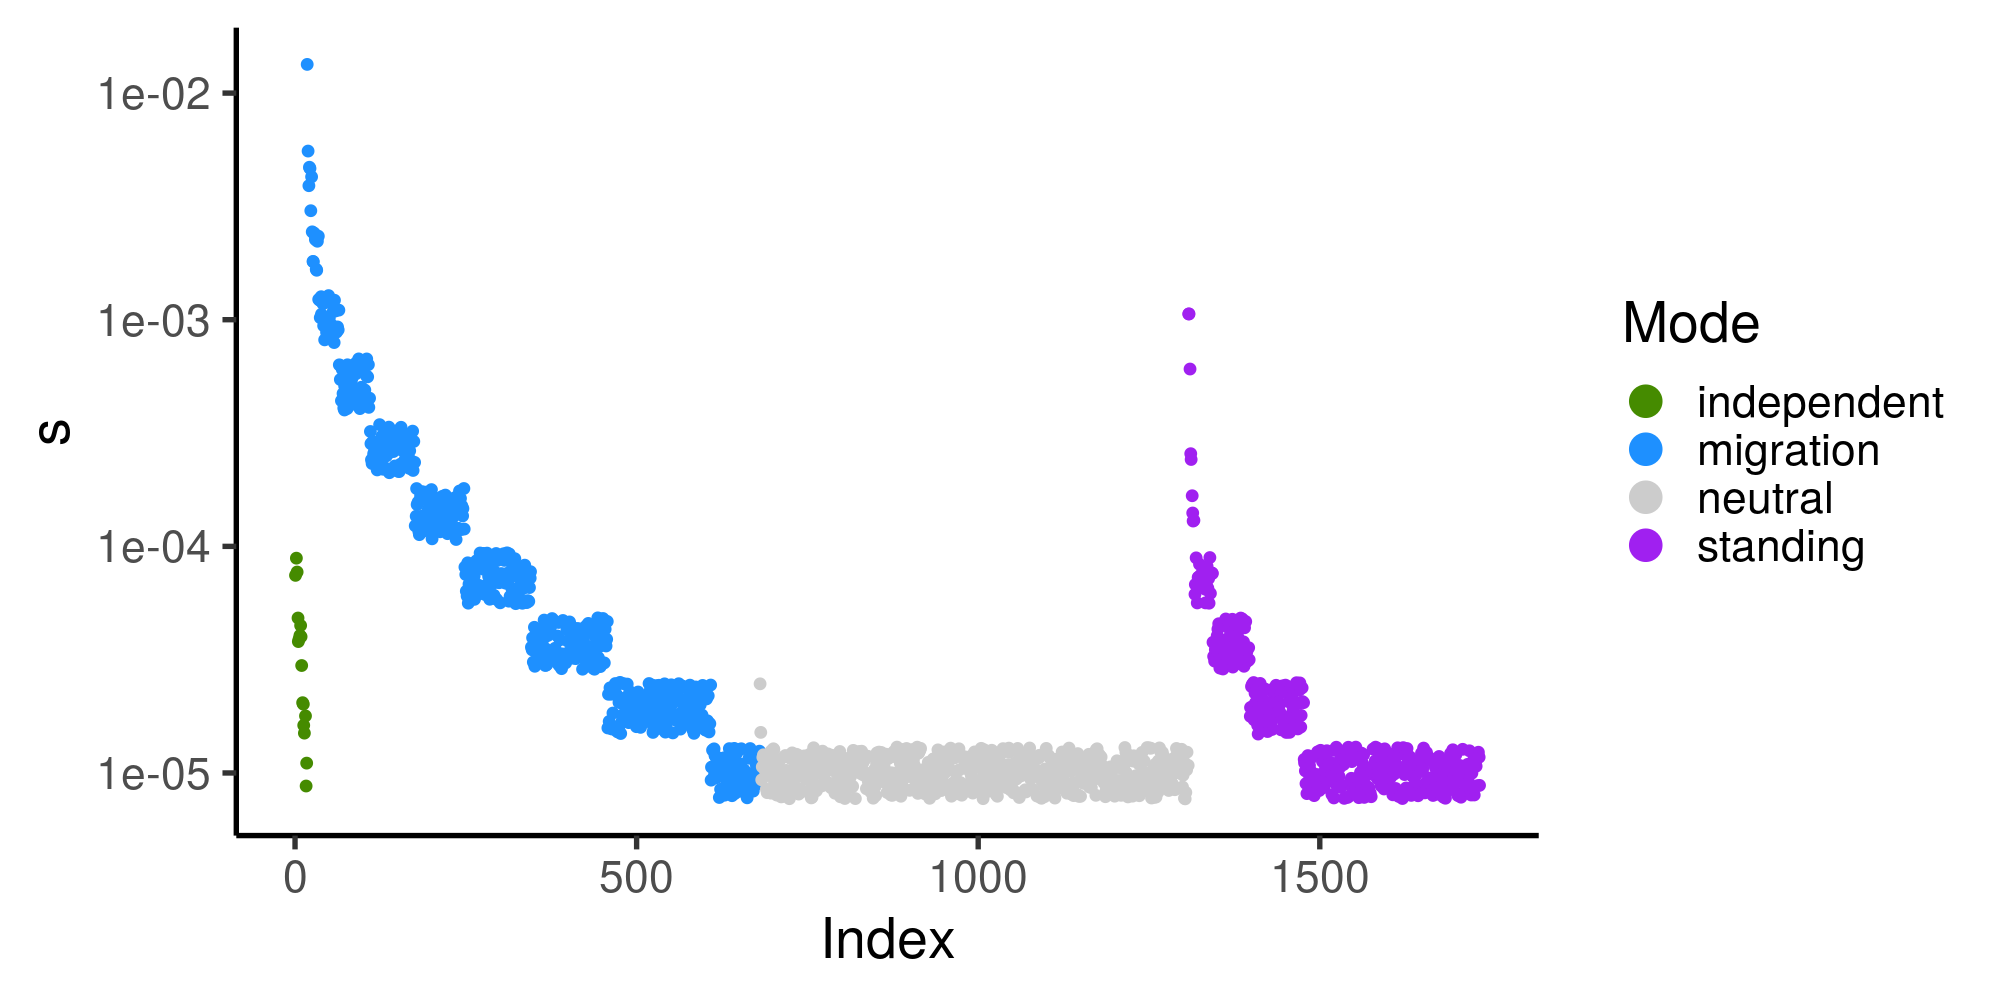

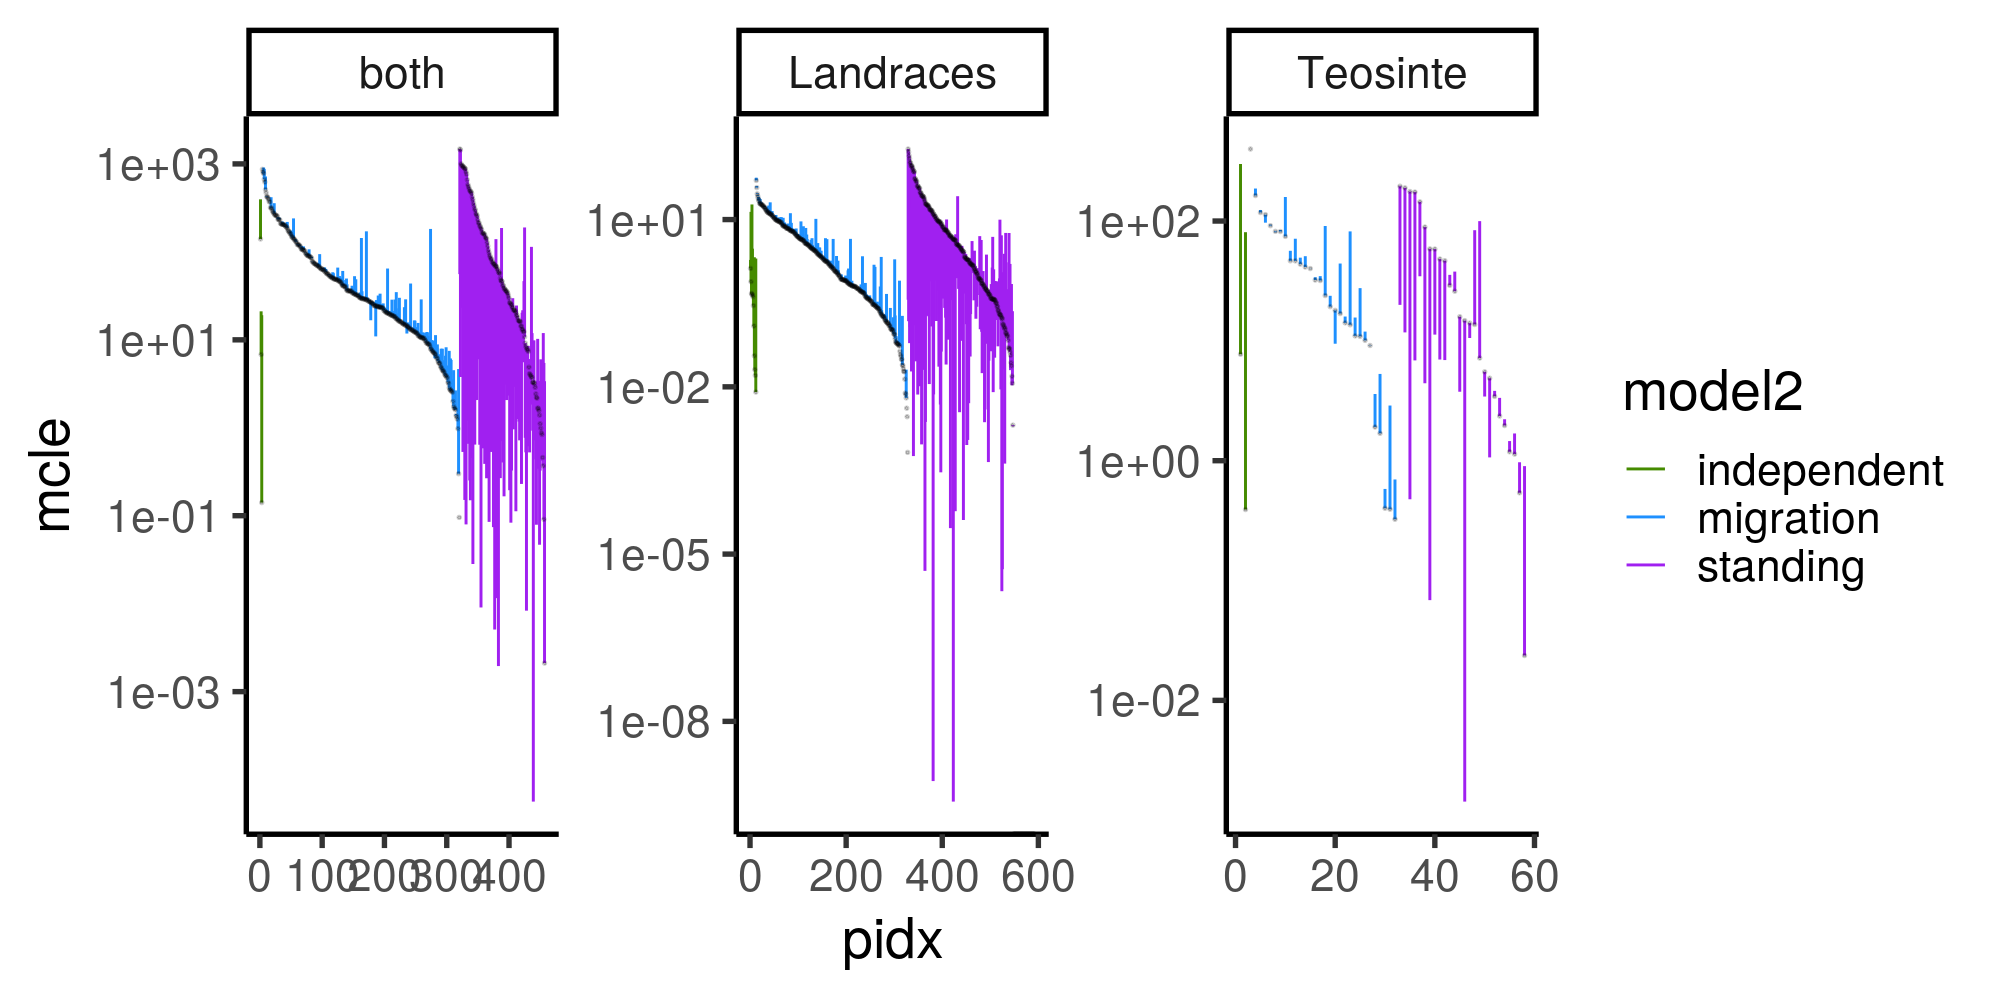

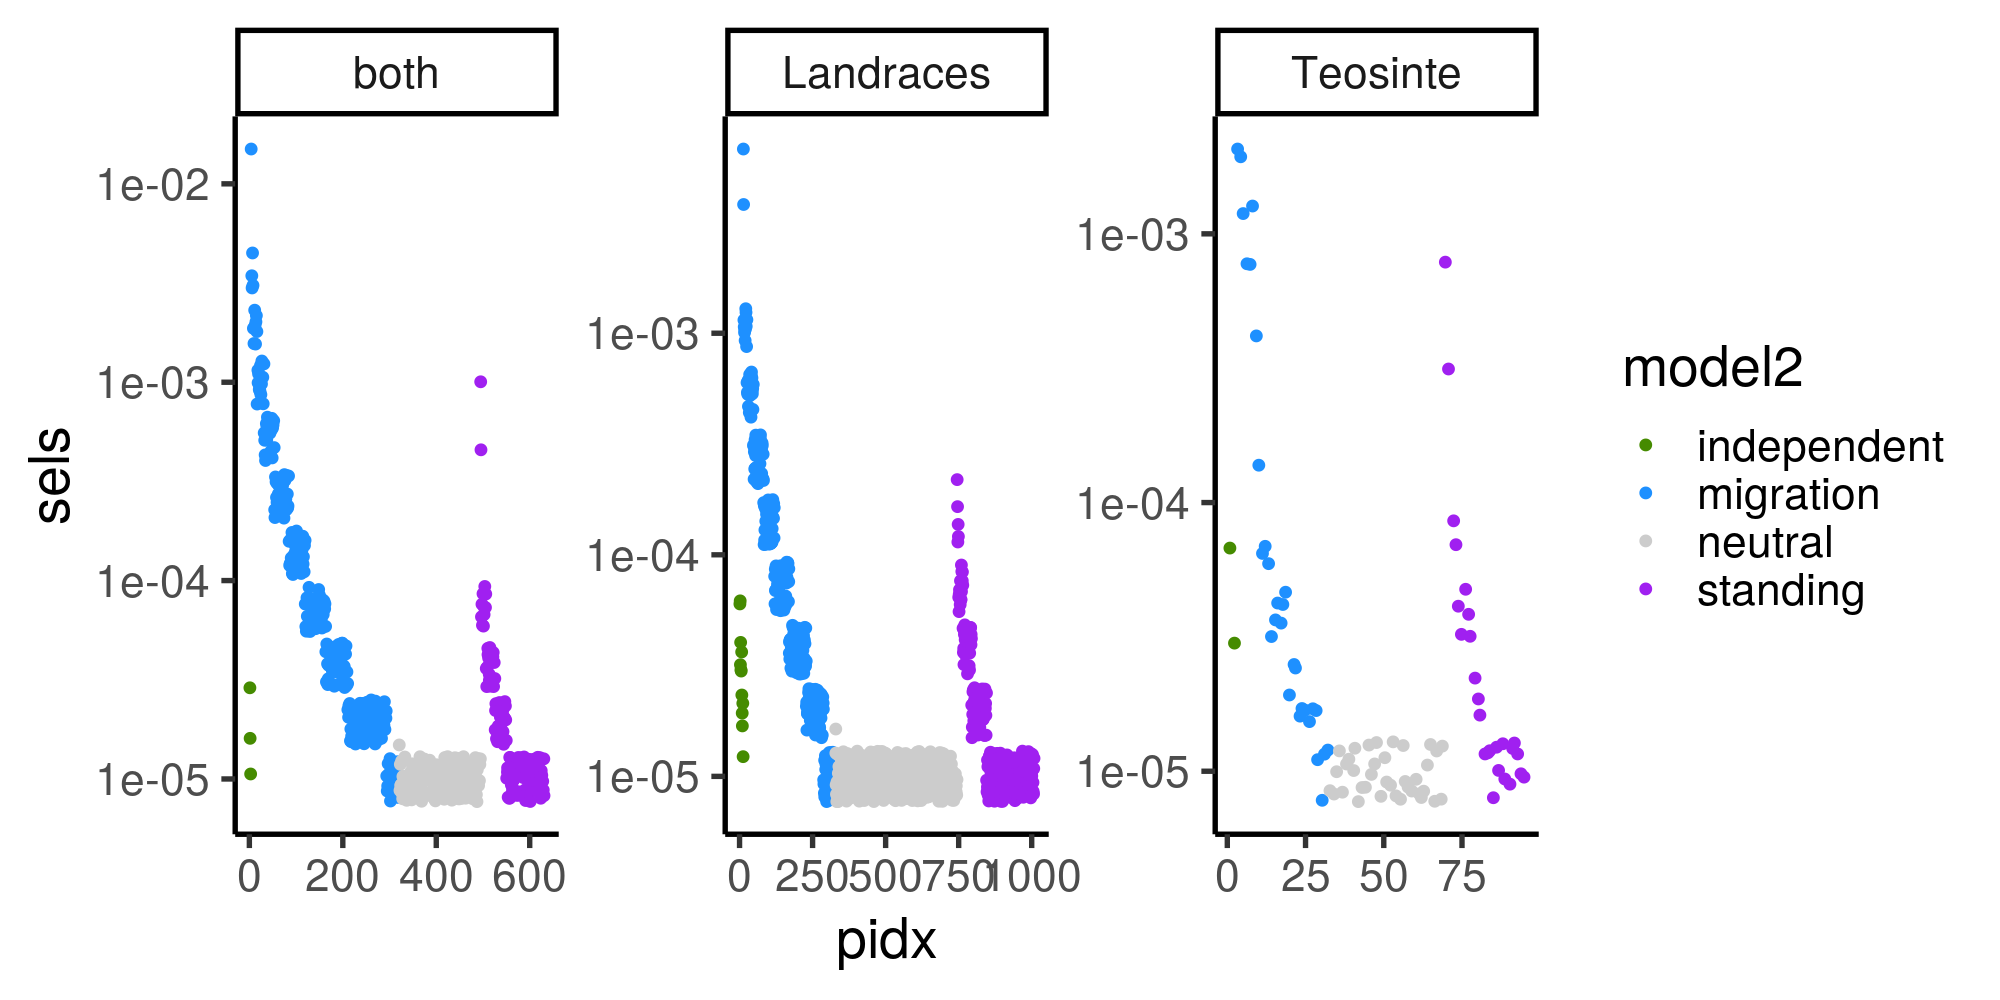

In [11]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 200)
mode_cols <- c("independent" = "chartreuse4", "migration" = "dodgerblue", "standing" = "purple")
sel_cols <- c("neutral" = "grey80", "independent" = "chartreuse4", "migration" = "dodgerblue", "standing" = "purple")


mode_mcle <- 
    top_models_df %>% 
    filter(model2 != "neutral")  %>%
    mutate(bn_diff =  sqrt((mcle_nextbest_diff - mcle)^2))  %>% 
    arrange(model2, desc(mcle_nextbest_diff)) %>%
    mutate(pidx = 1:n())  %>% 
    ggplot() +
    geom_segment(aes(x = pidx, xend=pidx, y = mcle, yend = mcle_nextbest_diff, colour = model2)) +
    #geom_point(aes(pidx, mcle), shape = 1, size = 0.5) +
    geom_point(aes(pidx, mcle_nextbest_diff), size = 0.25, alpha = 0.2) +
    scale_y_log10() +
    scale_color_manual(values = mode_cols) +
    theme(legend.position = "n") +
    xlab("Index") +
    ylab(expression(Delta[cle]))



mode_sels <- 
    top_models_df %>% 
    arrange(model2, desc(sels)) %>%
    mutate(pidx=1:n()) %>% 
    ggplot(aes(pidx, sels, colour = model2)) +
    geom_jitter()+
    scale_y_log10() +
    scale_color_manual(values = sel_cols) +
    xlab("Index") +
    ylab("s") +
    labs(color='Mode') +
    guides(colour = guide_legend(override.aes = list(size=5)))




mode_mcle
mode_sels

top_models_df %>% 
    filter(model2 != "neutral")  %>%
    mutate(bn_diff =  sqrt((mcle_nextbest_diff - mcle)^2))  %>% 
    arrange(model2, desc(mcle_nextbest_diff)) %>%
    group_by(type) %>% 
    mutate(pidx = 1:n())  %>% 
    ggplot()+
    geom_segment(aes(x = pidx, xend=pidx, y = mcle, yend = mcle_nextbest_diff, colour = model2)) +
    #geom_point(aes(pidx, mcle), shape = 1, size = 0.5) +
    geom_point(aes(pidx, mcle_nextbest_diff), size = 0.25, alpha = 0.2) +
    scale_y_log10() +
    facet_wrap(~type, scale = "free") +
    scale_color_manual(values = mode_cols)

top_models_df %>% 
    arrange(model2, desc(sels)) %>%
    group_by(type) %>% 
    mutate(pidx=1:n()) %>% 
    ggplot(aes(pidx, sels, colour = model2)) +
    geom_jitter()+
    scale_y_log10() +
    facet_wrap(~type, scale = "free") +
    scale_color_manual(values = sel_cols)


model2      n()
1 independent  17
2 migration   663
3 neutral     627
4 standing    427

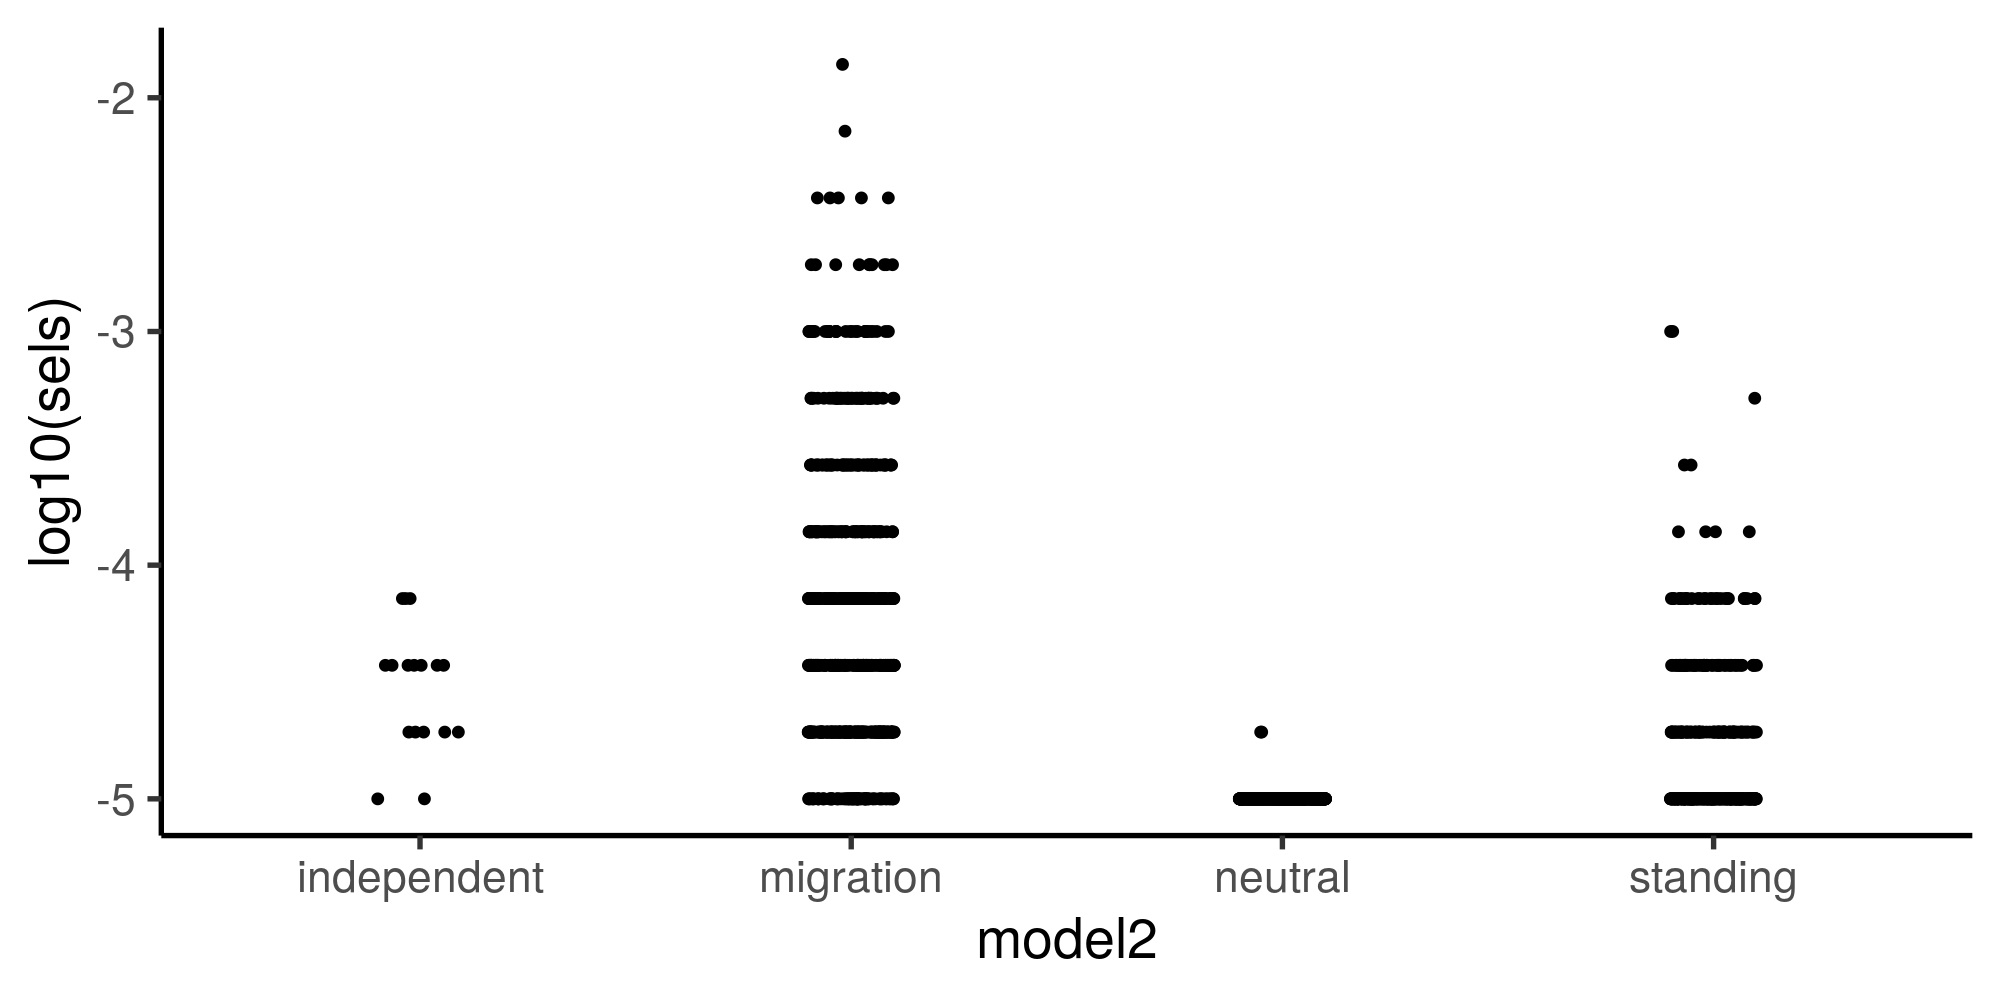

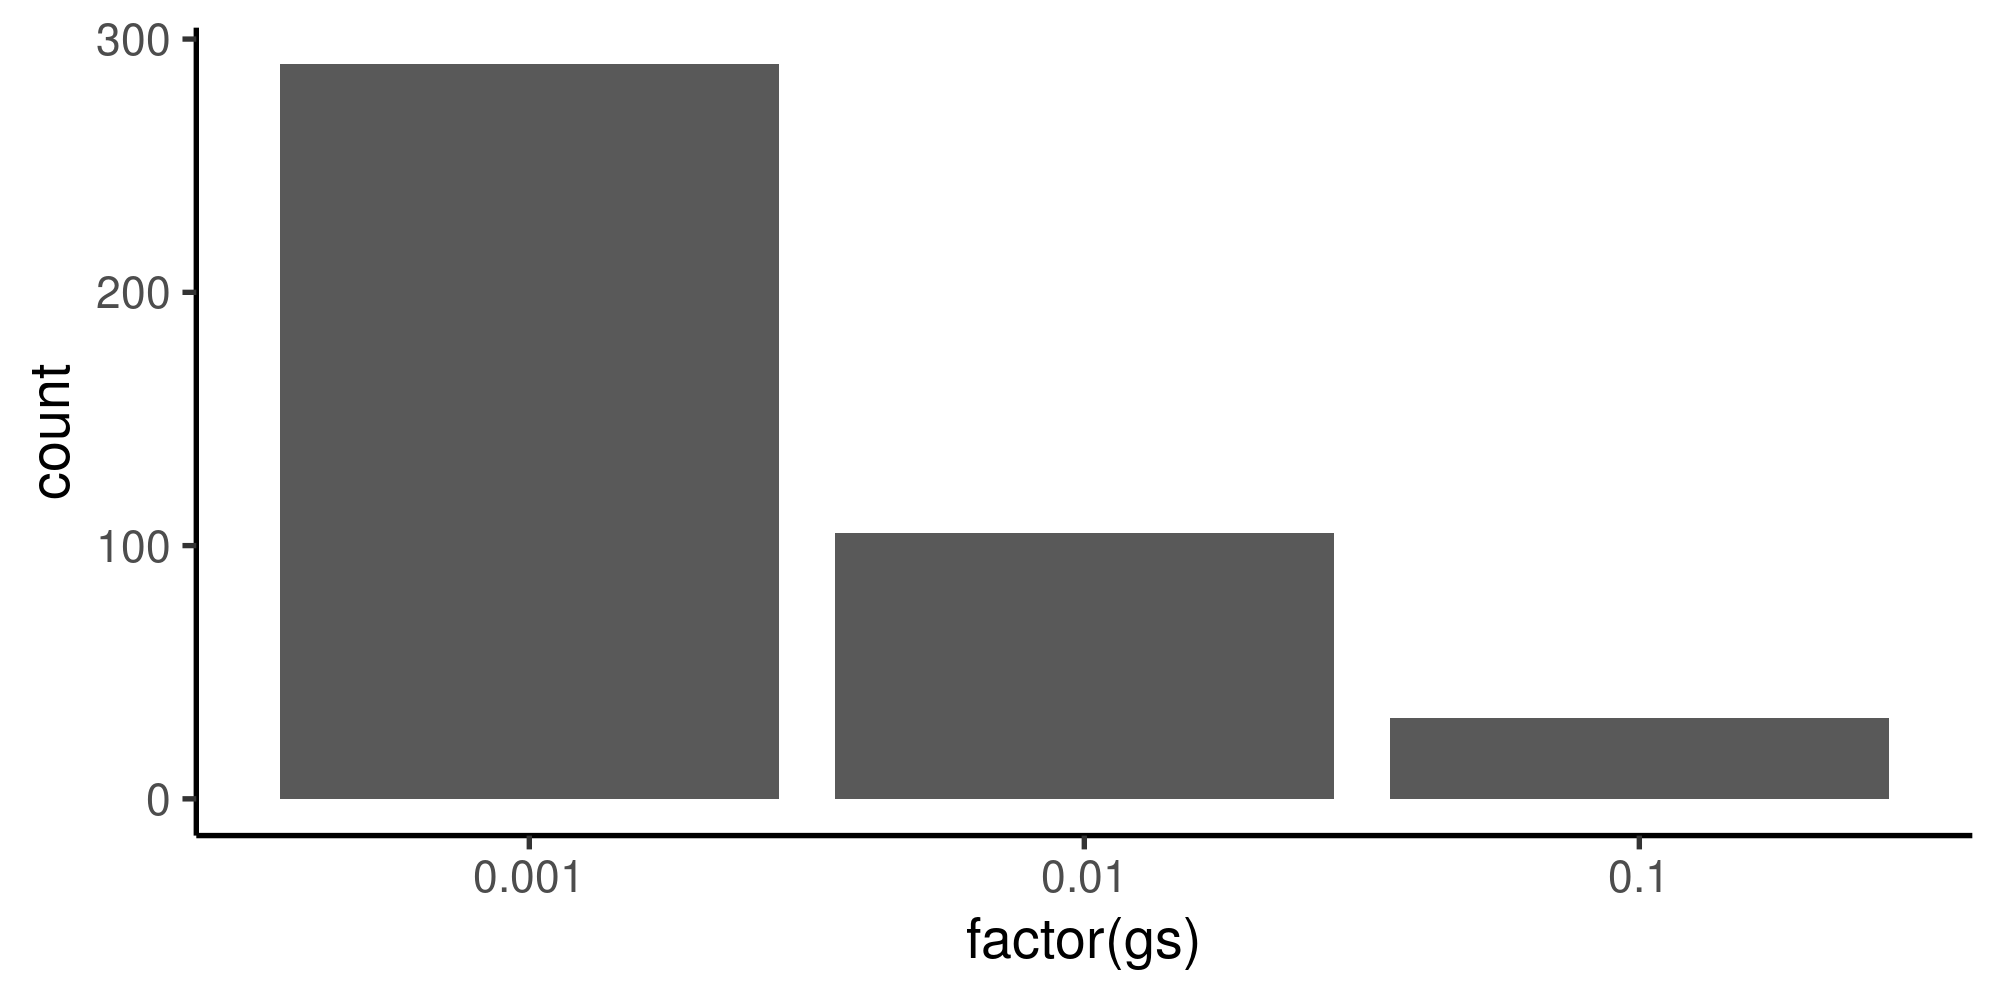

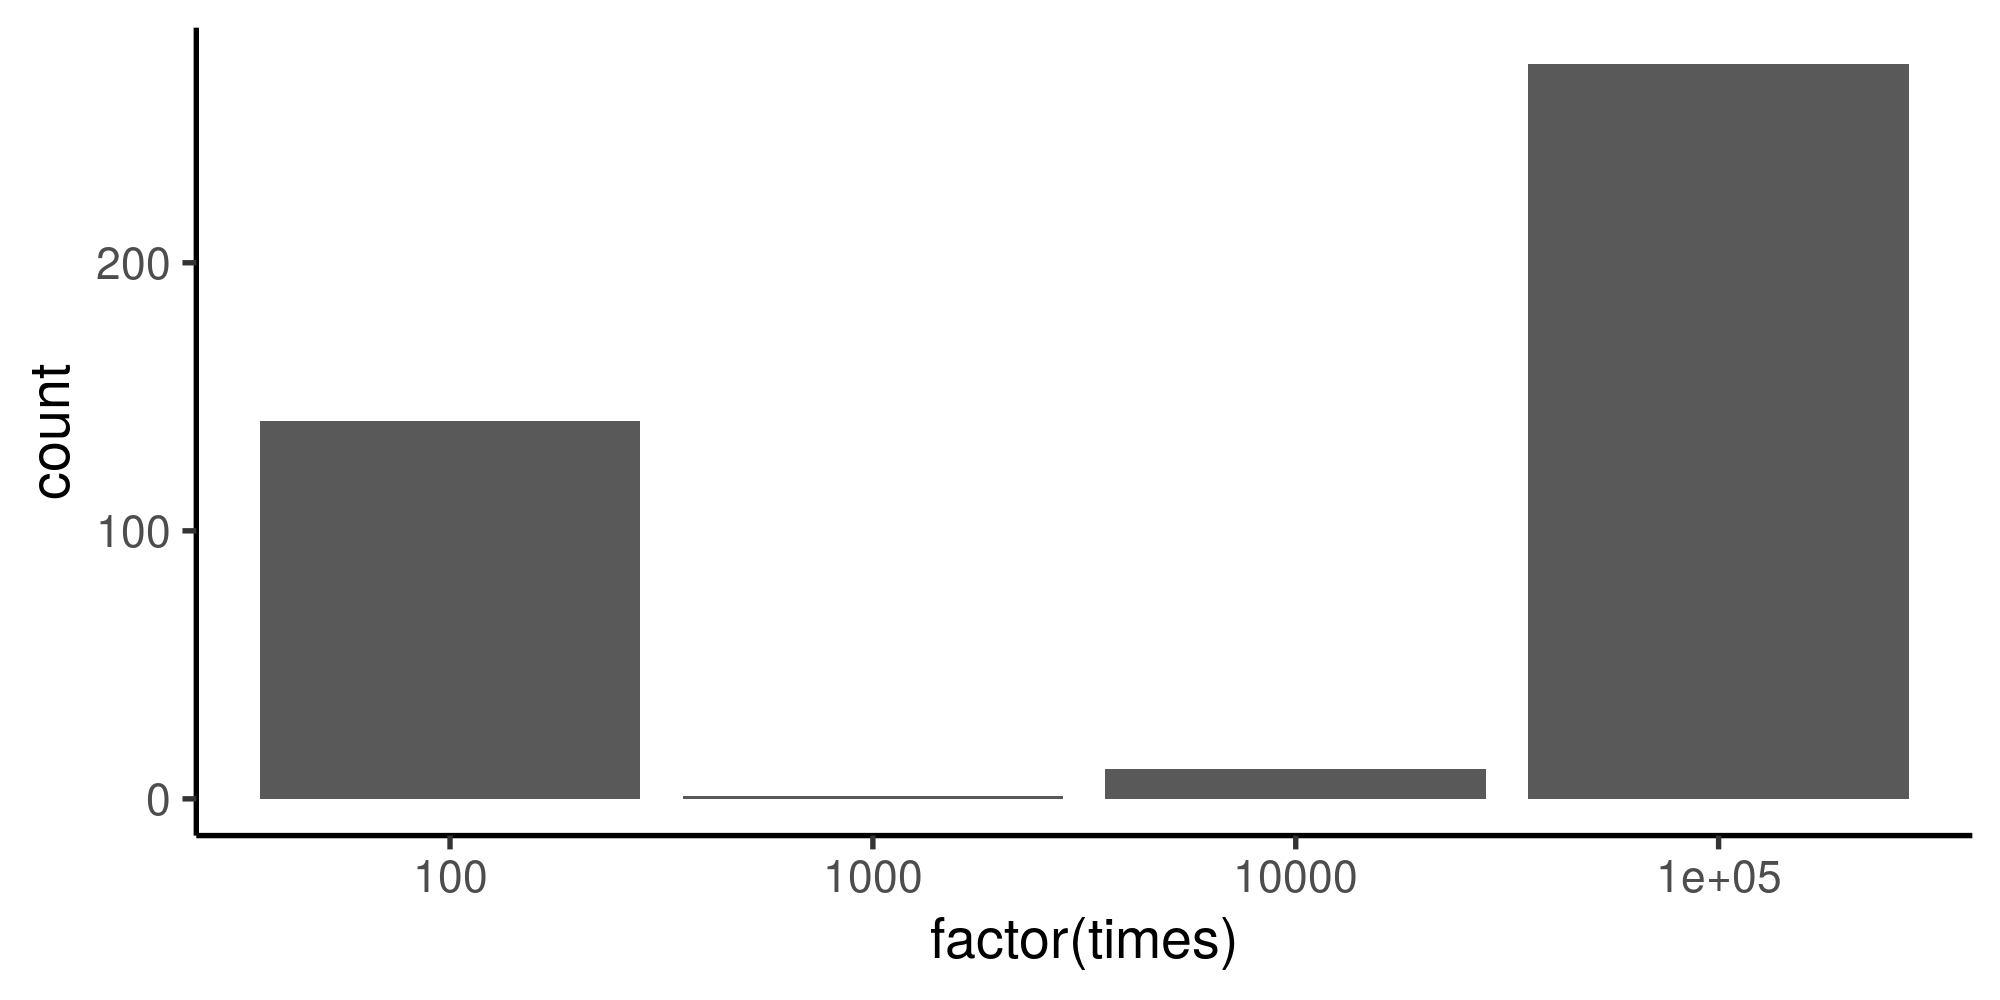

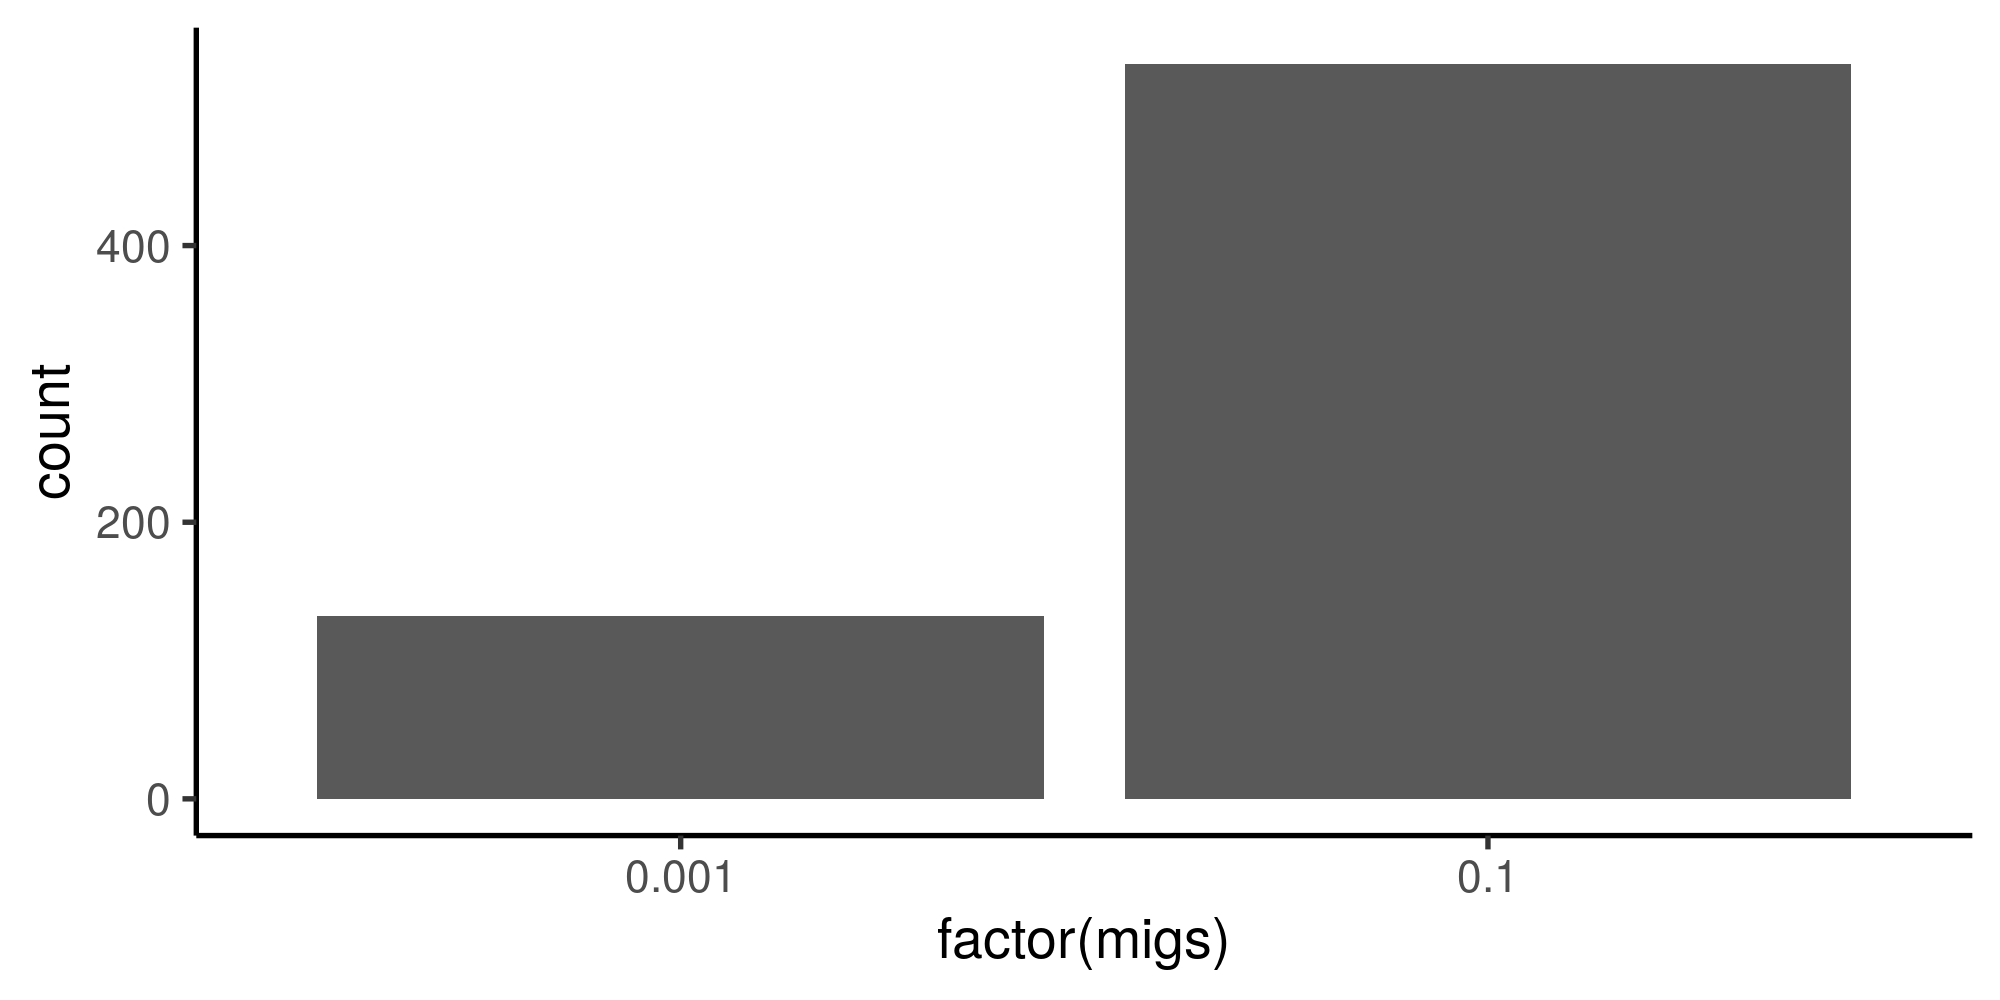

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 26 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 26 rows containing missing values (geom_point).”


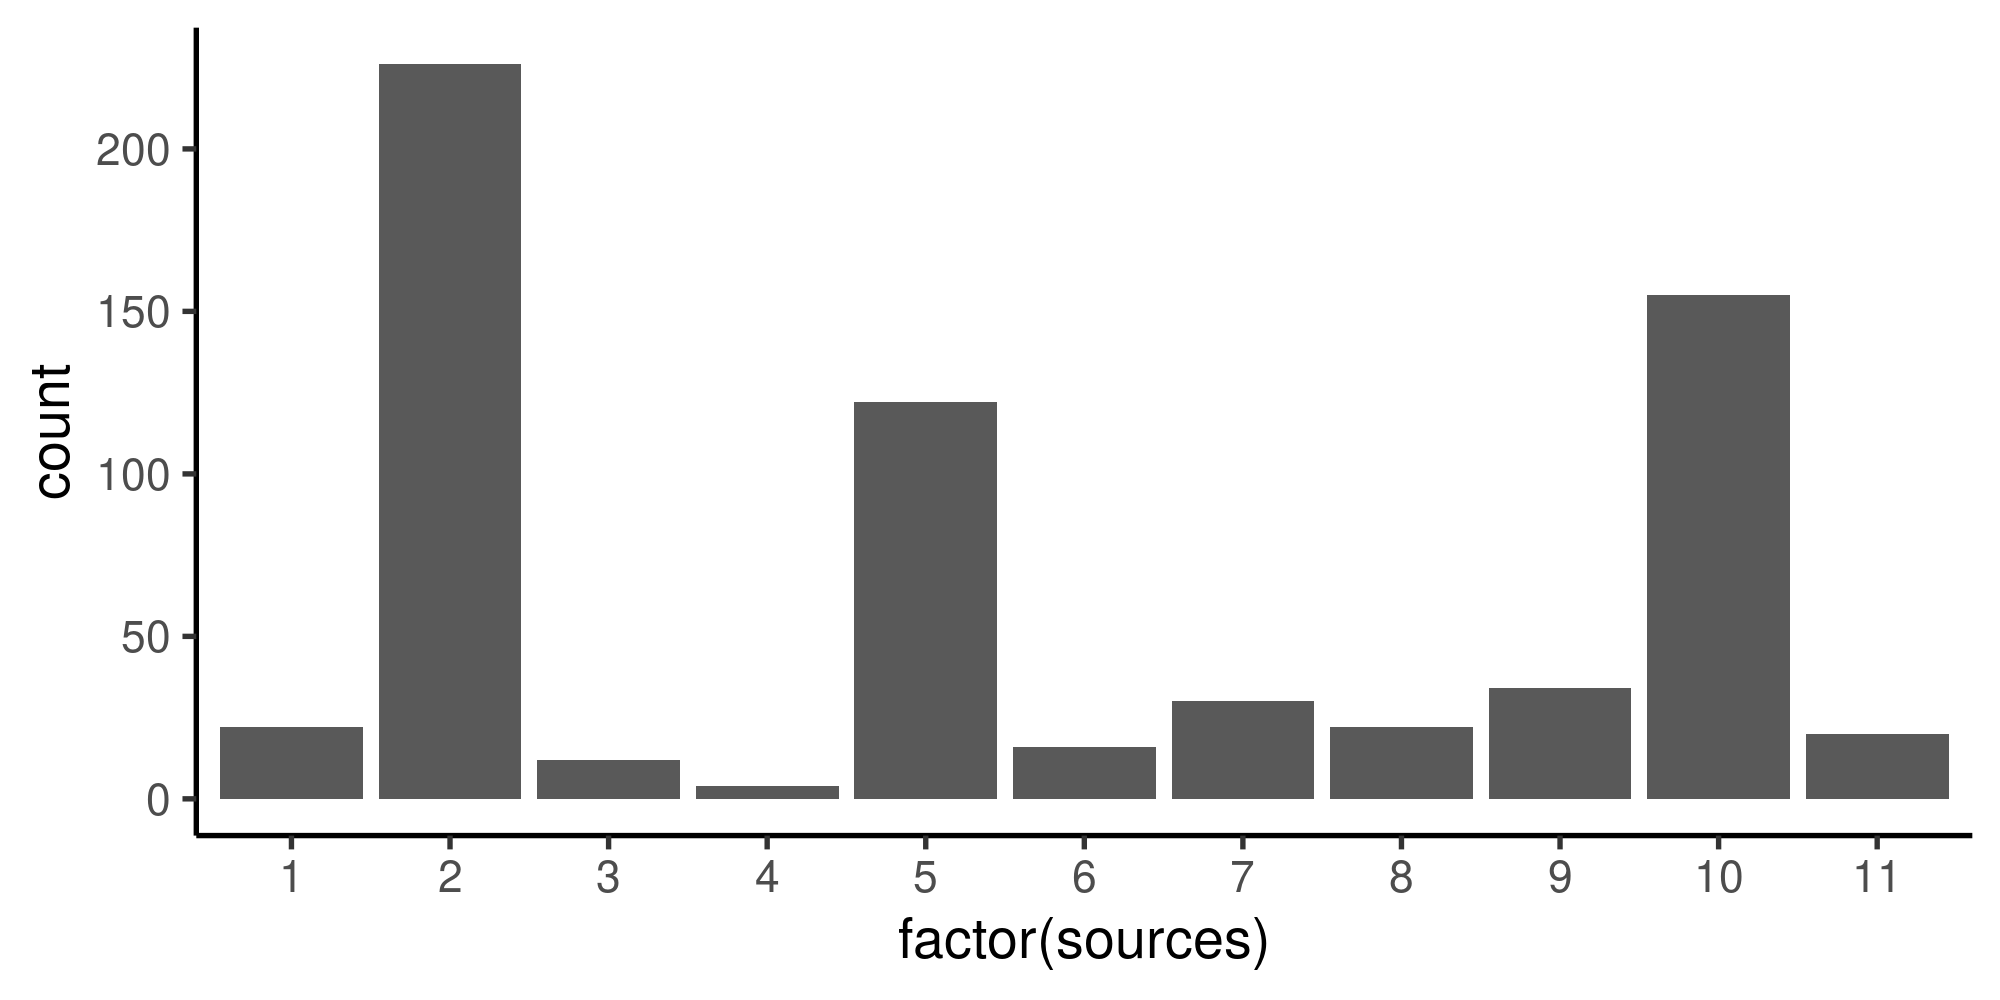

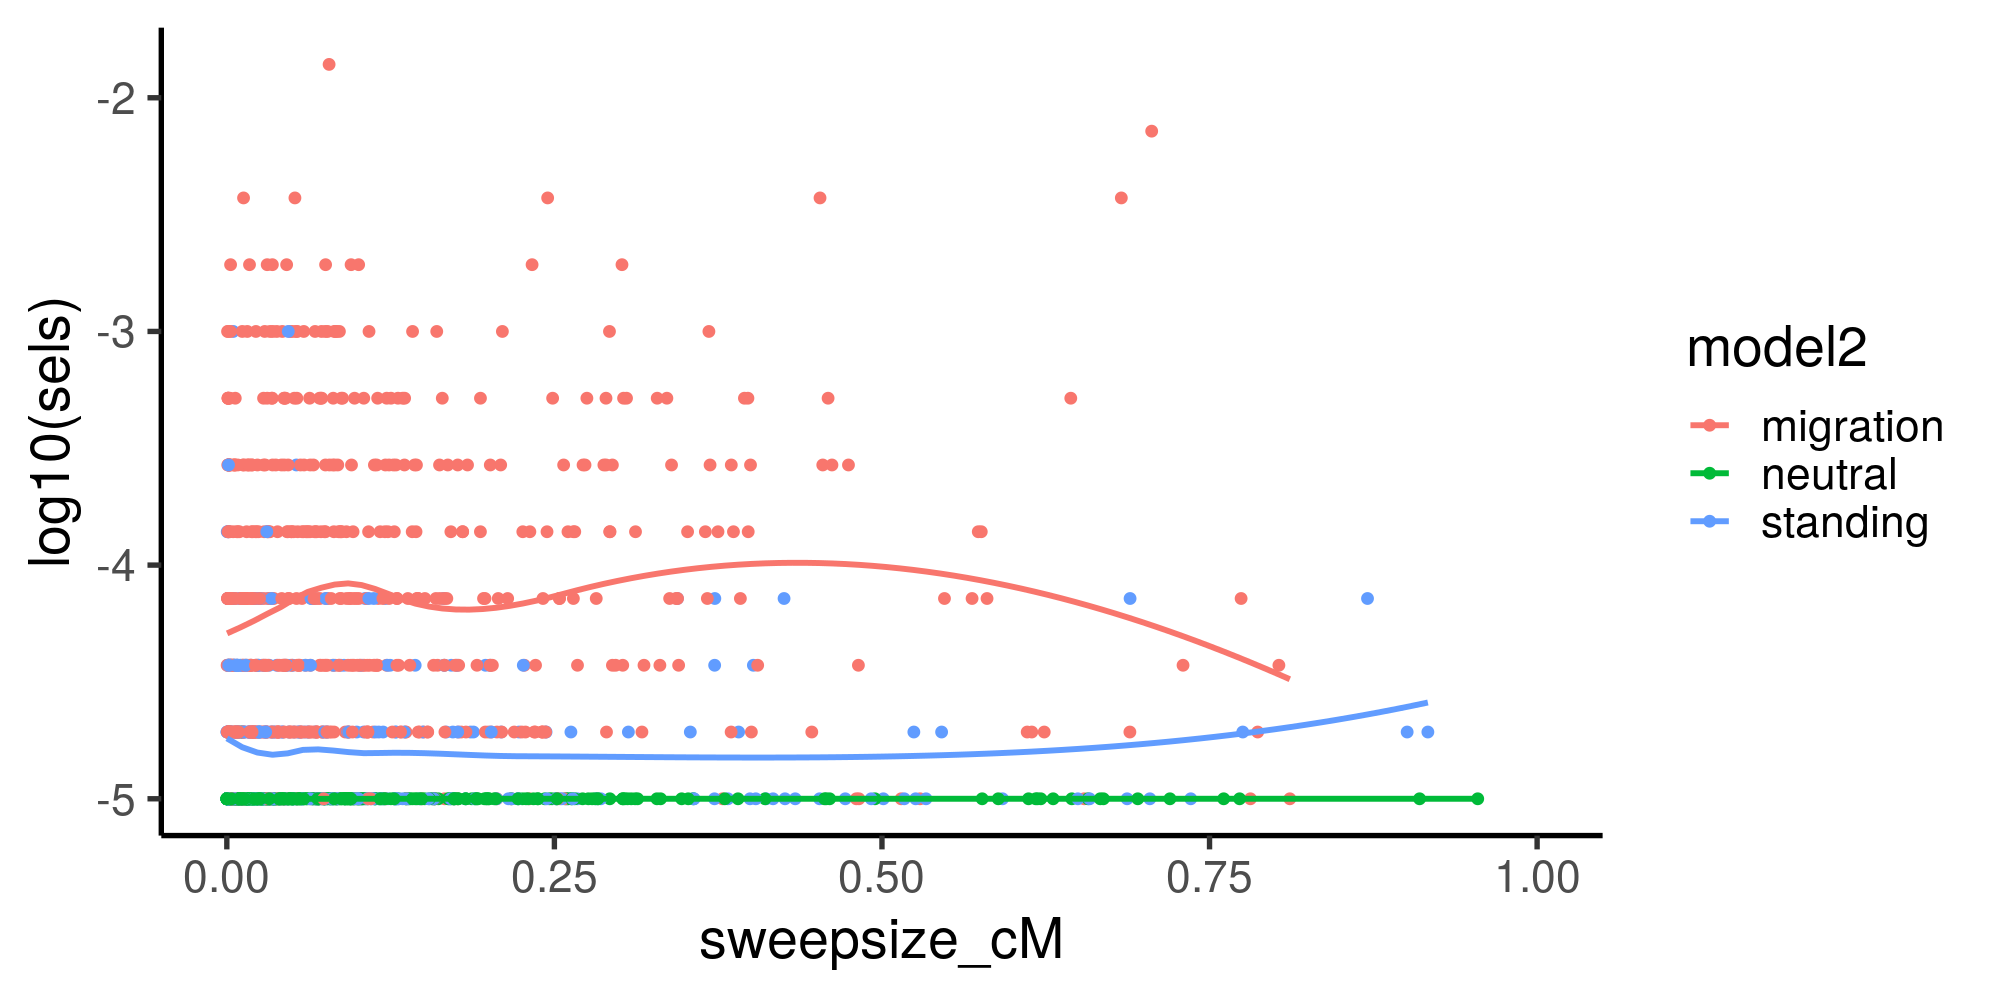

In [12]:


top_models_df %>%
    group_by(model2) %>% 
    summarise(n())

top_models_df %>% 
    ggplot(aes(model2, log10(sels))) +
    geom_jitter(width = 0.1, height = 0)

top_models_df %>%
    filter(model2 == "standing") %>% 
    ggplot(aes(factor(gs))) +
    geom_bar(stat = "count")

top_models_df %>%
    filter(model2 == "standing") %>% 
    ggplot(aes(factor(times))) +
    geom_bar(stat = "count")


top_models_df %>%
    filter(model2 == "migration") %>% 
    ggplot(aes(factor(migs))) +
    geom_bar(stat = "count")


top_models_df %>%
    filter(model2 == "migration") %>% 
    ggplot(aes(factor(sources))) +
    geom_bar(stat = "count")


top_models_df %>%
    filter(model2 != "independent") %>% 
    ggplot(aes(sweepsize_cM, log10(sels), colour = model2)) +
    geom_point() +
    geom_smooth(se = F) +
    xlim(0, 1)


`geom_smooth()` using formula 'y ~ x'



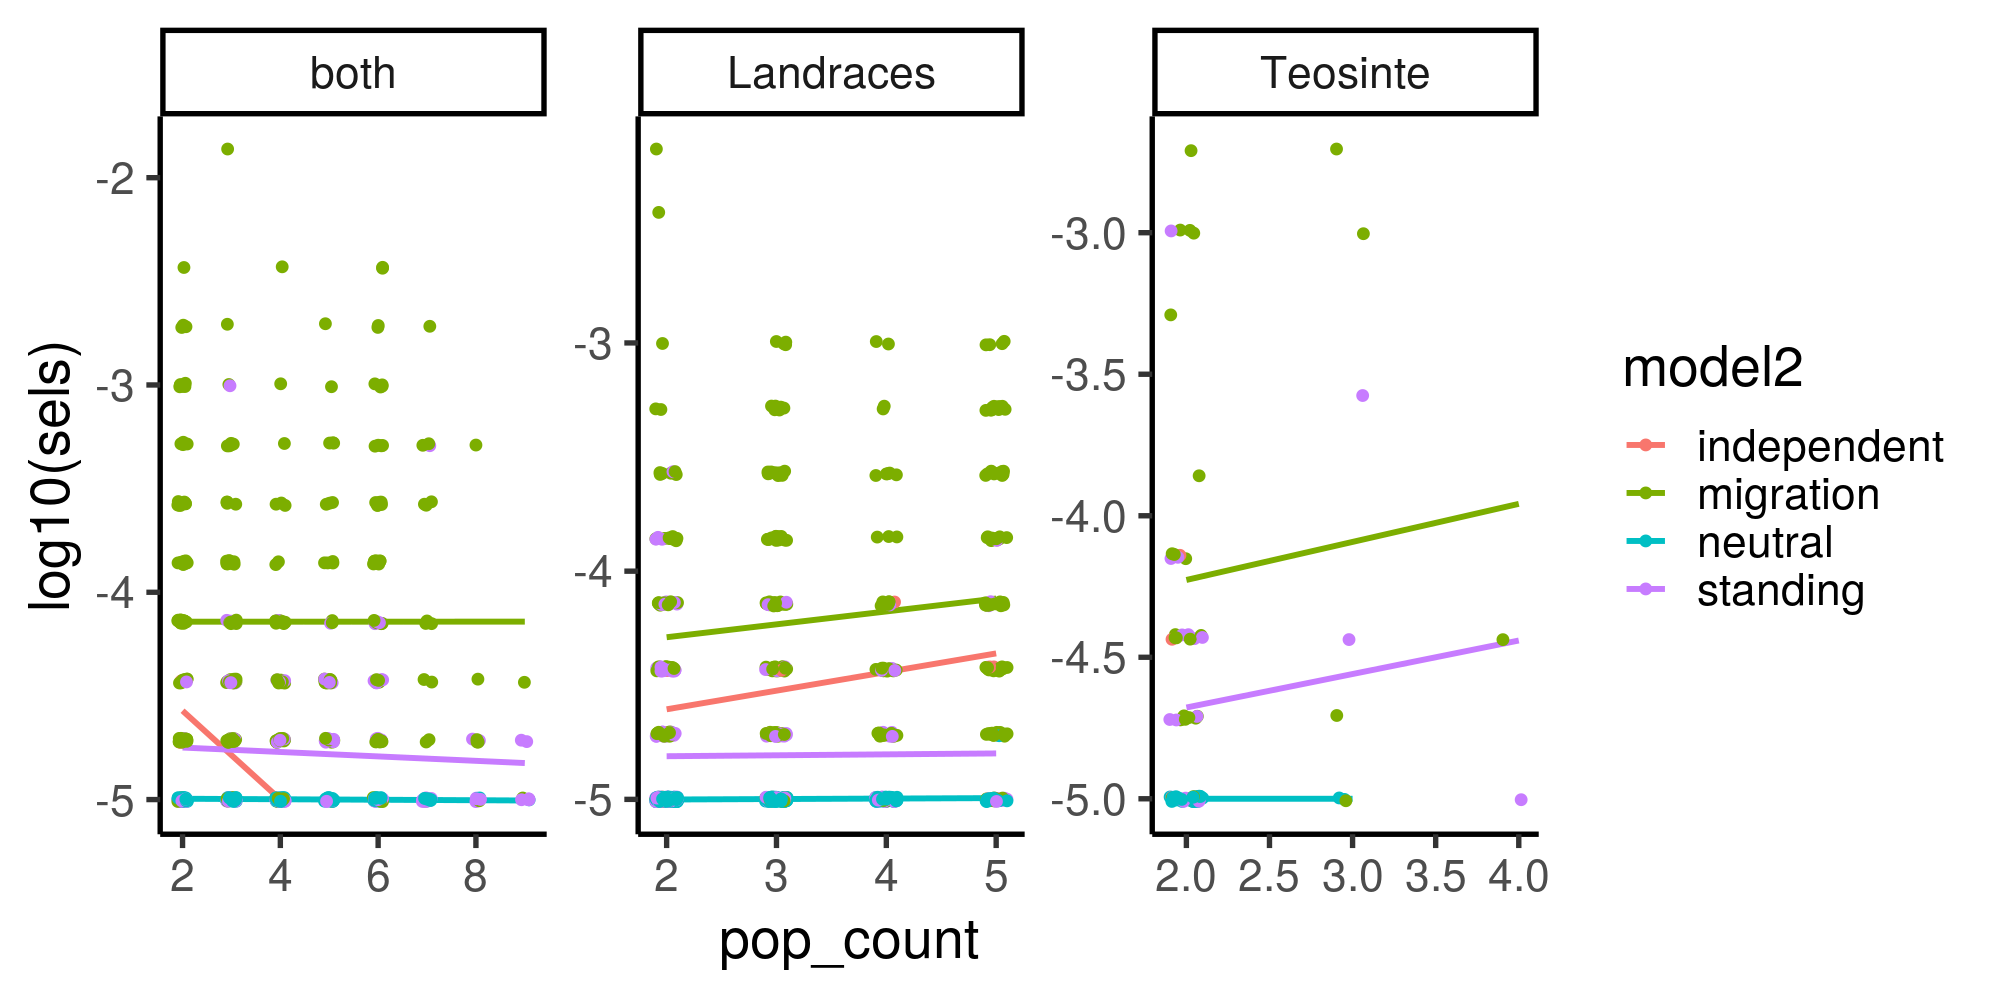

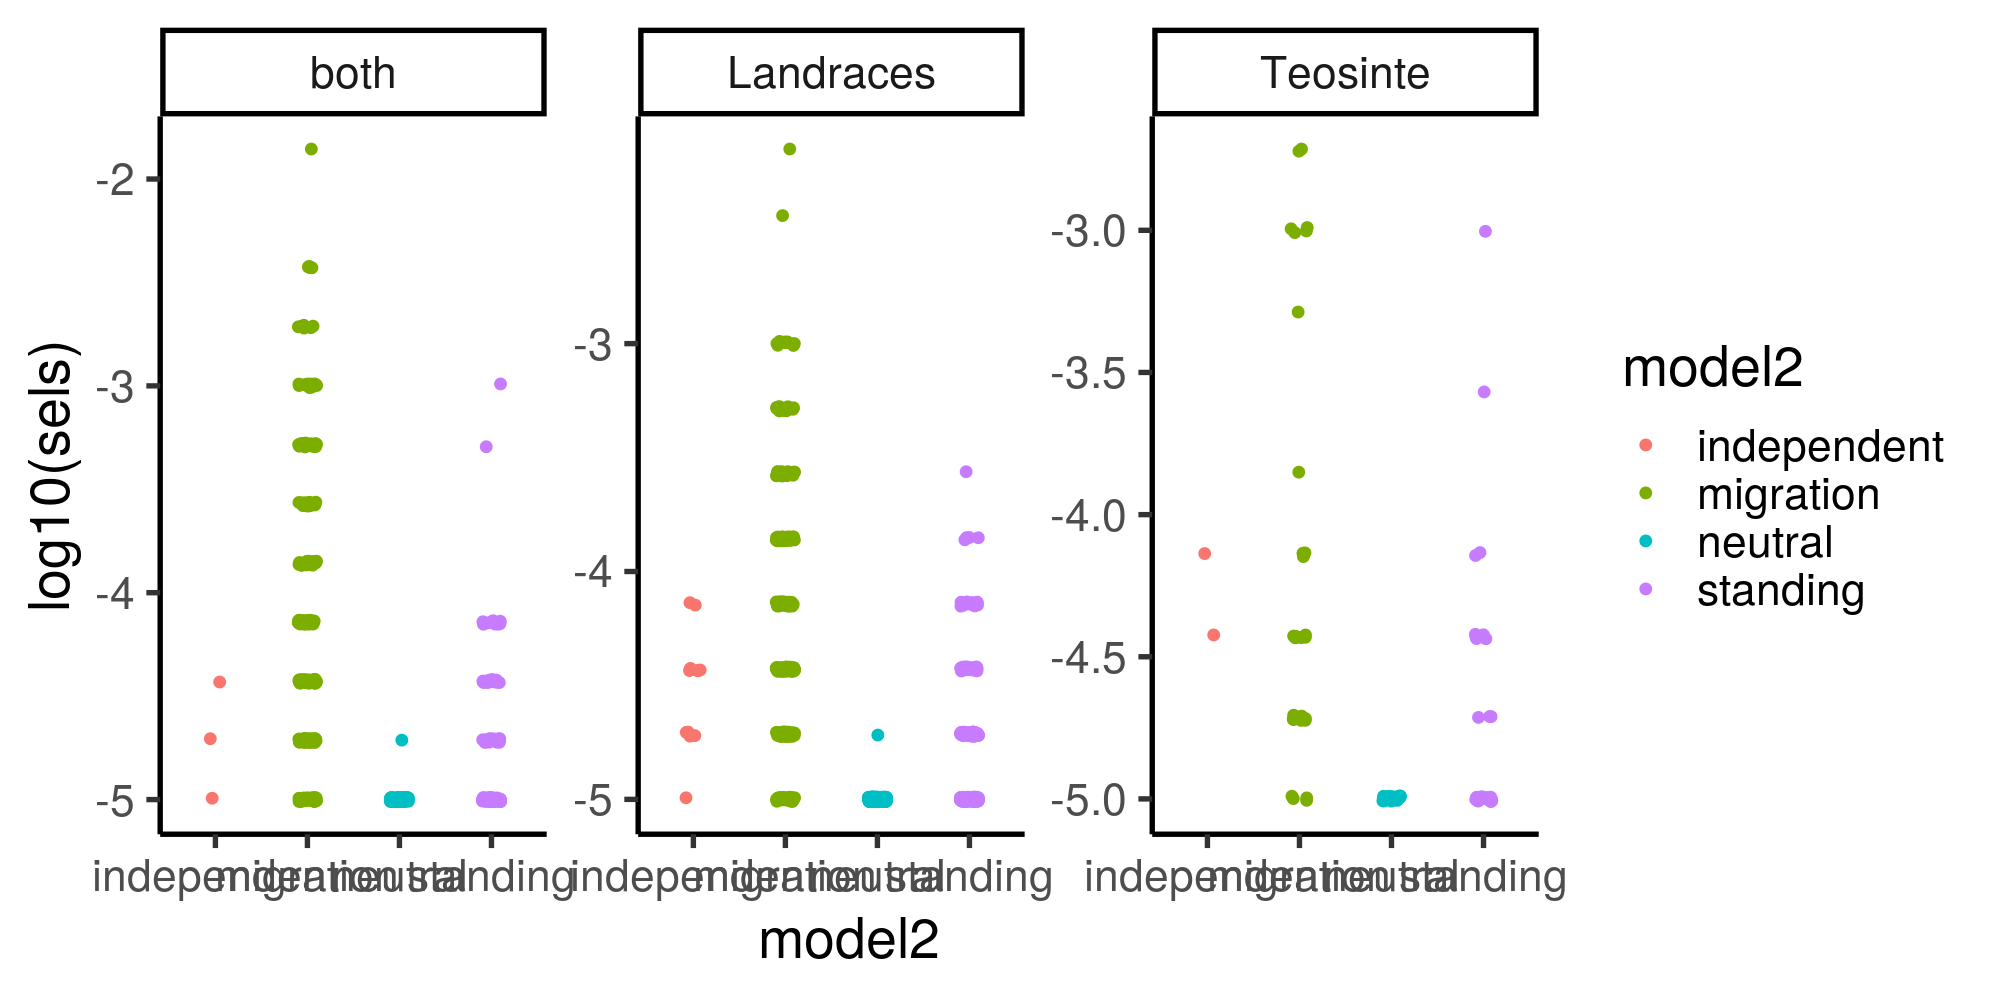

In [13]:
top_models_df %>%
    ggplot(aes(pop_count, log10(sels), colour = model2)) +
    geom_smooth(method = "lm", se = F) +
    geom_jitter(height = 0.01, width = 0.1) +
    facet_wrap(~type, scale = "free")


top_models_df %>%
    ggplot(aes(model2, log10(sels), colour = model2)) +
    geom_jitter(height = 0.01, width = 0.1) +
    facet_wrap(~type, scale = "free")

Warning message in cor.test.default(top_models_df$sweepsize_cM, top_models_df$n_snps, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  top_models_df$sweepsize_cM and top_models_df$n_snps
S = 221323837, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.745298 


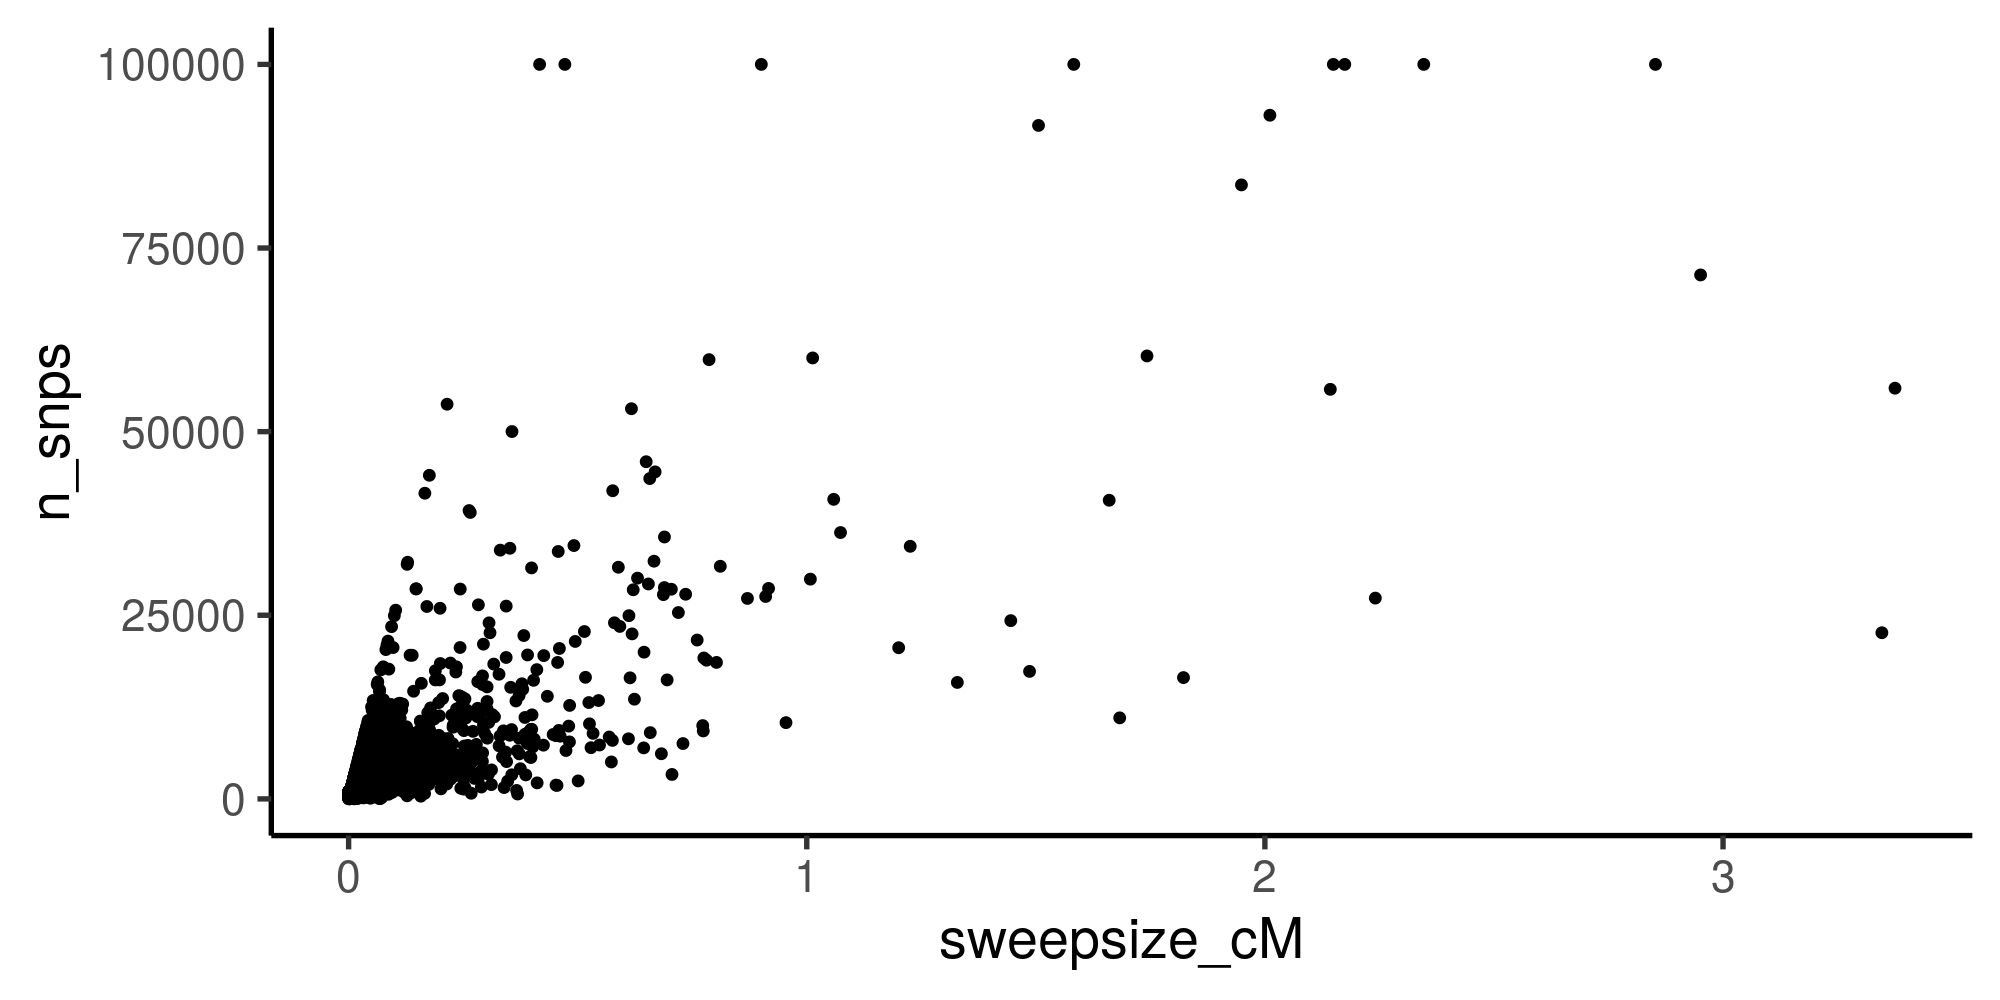

In [14]:
top_models_df %>% 
    ggplot(aes(sweepsize_cM, n_snps)) +
    geom_point()
    #geom_hline(yintercept = c(1e3, 1e4))

cor.test(top_models_df$sweepsize_cM, top_models_df$n_snps, method = "spear")

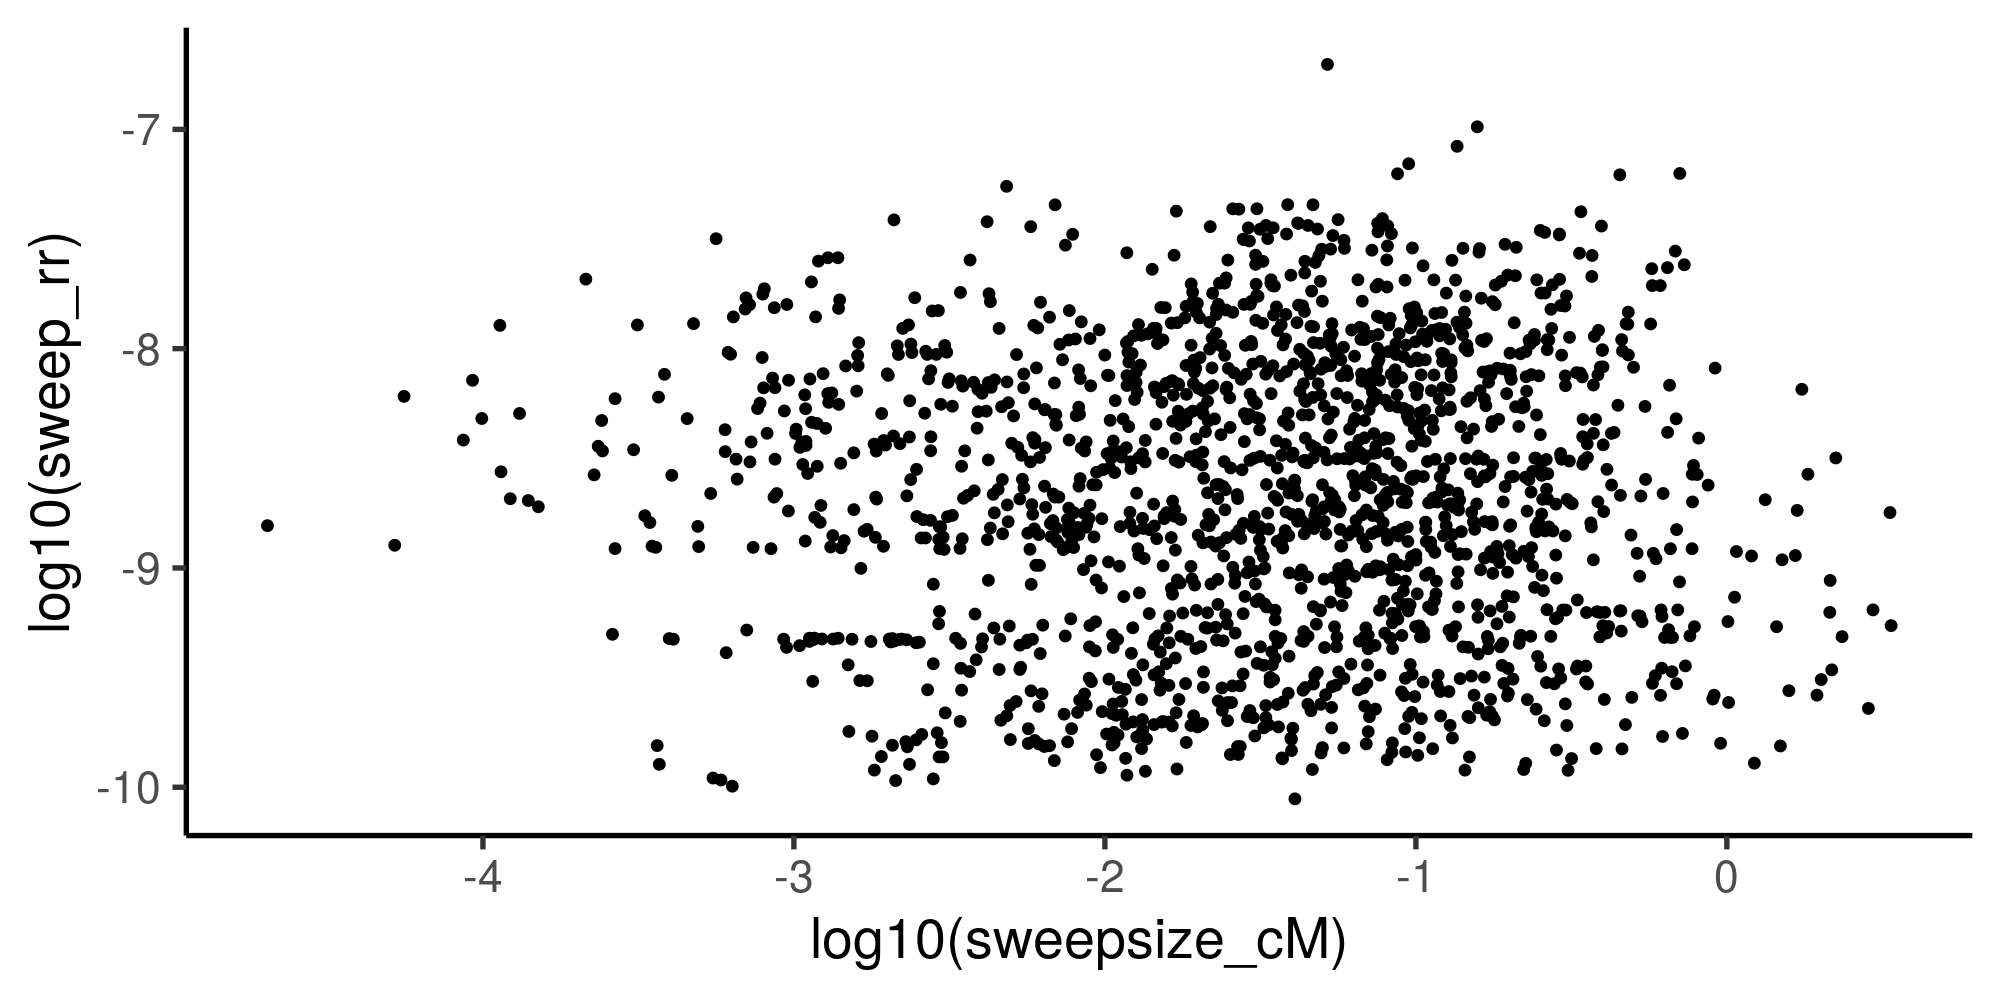

In [15]:
top_models_df %>% 
    ggplot(aes(log10(sweepsize_cM), log10(sweep_rr))) +
    geom_point()

[1] 18

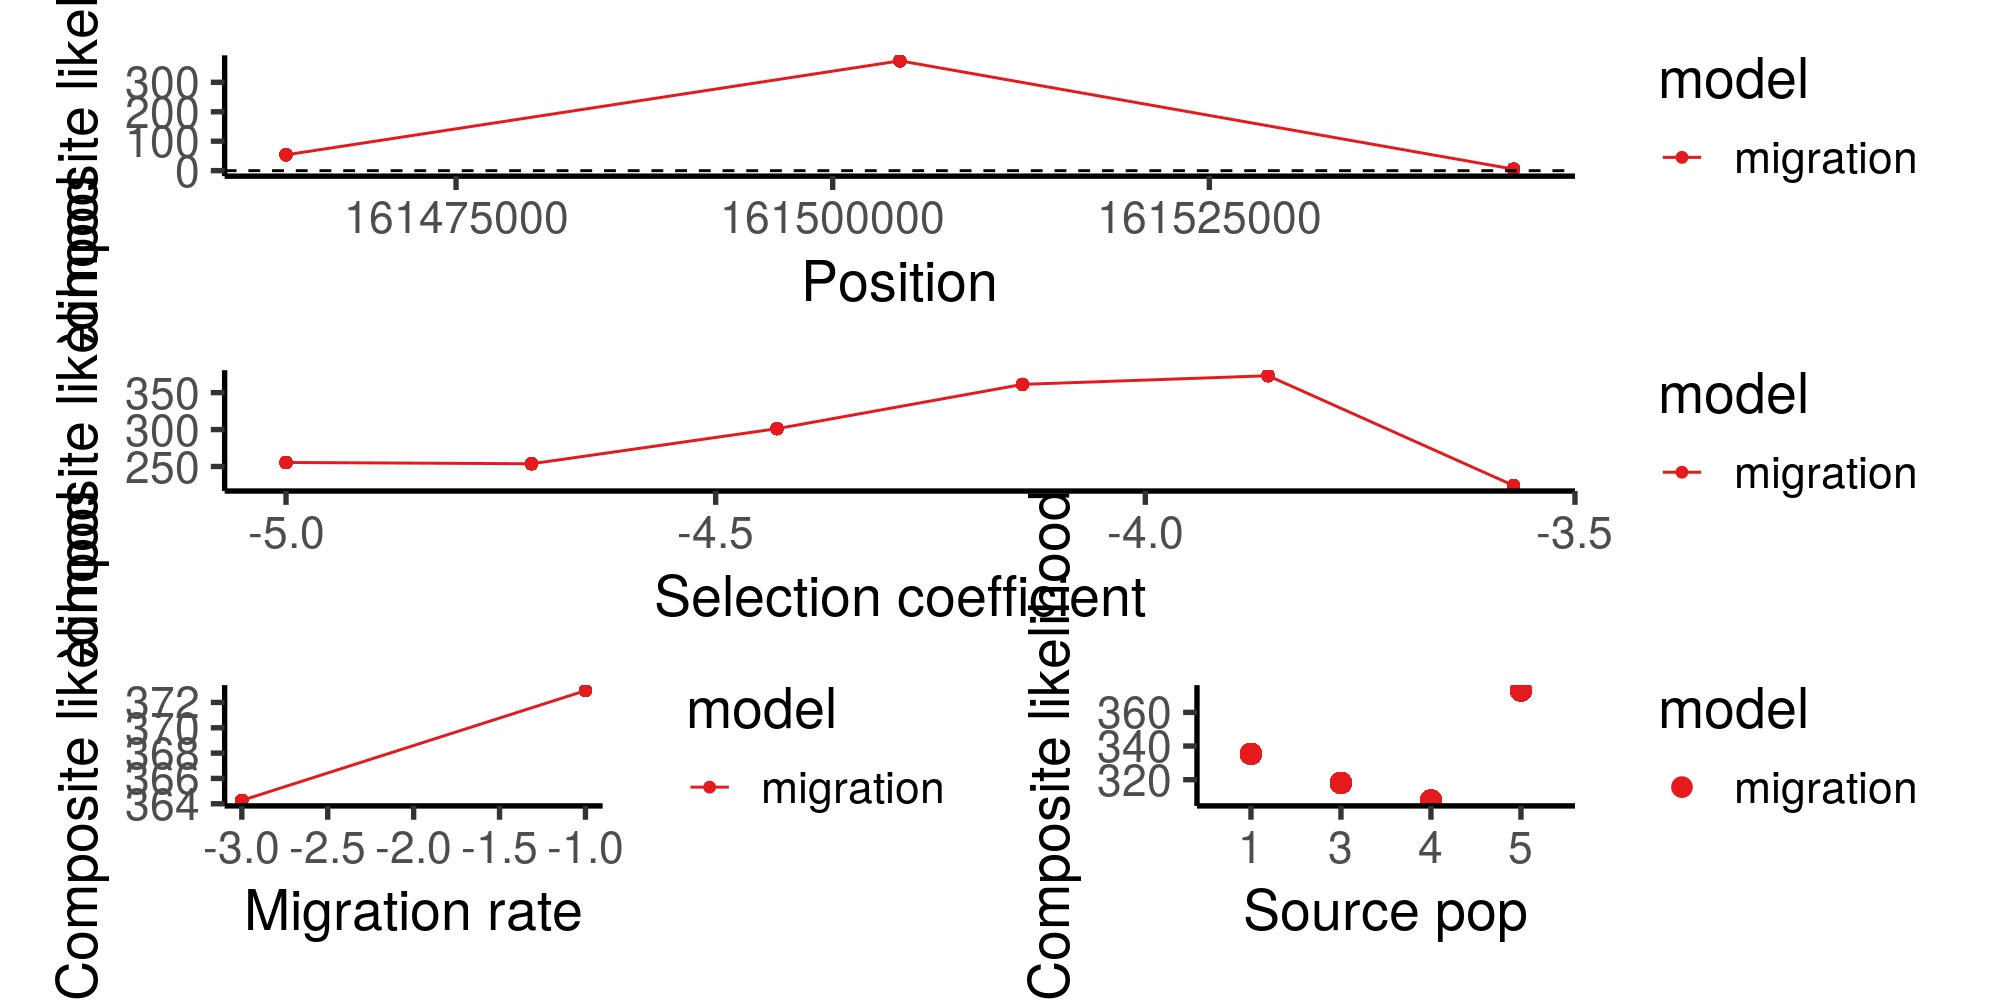

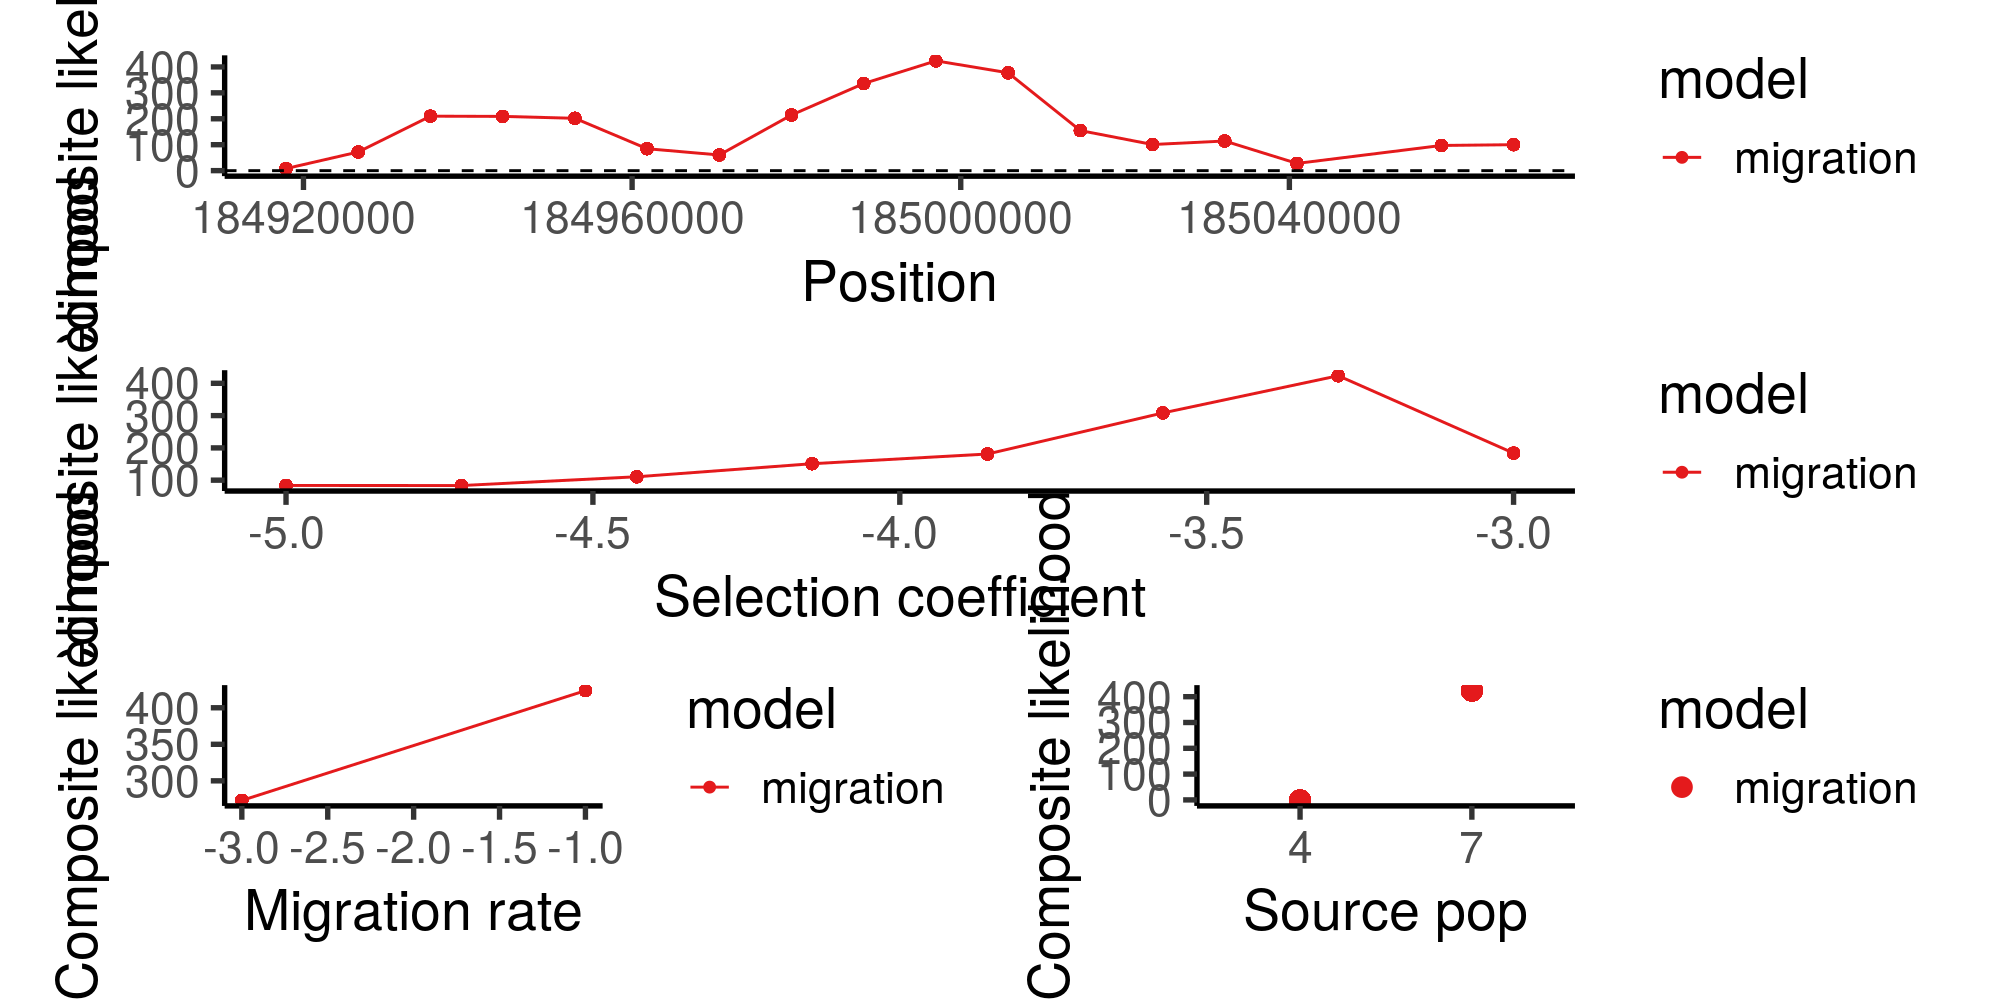

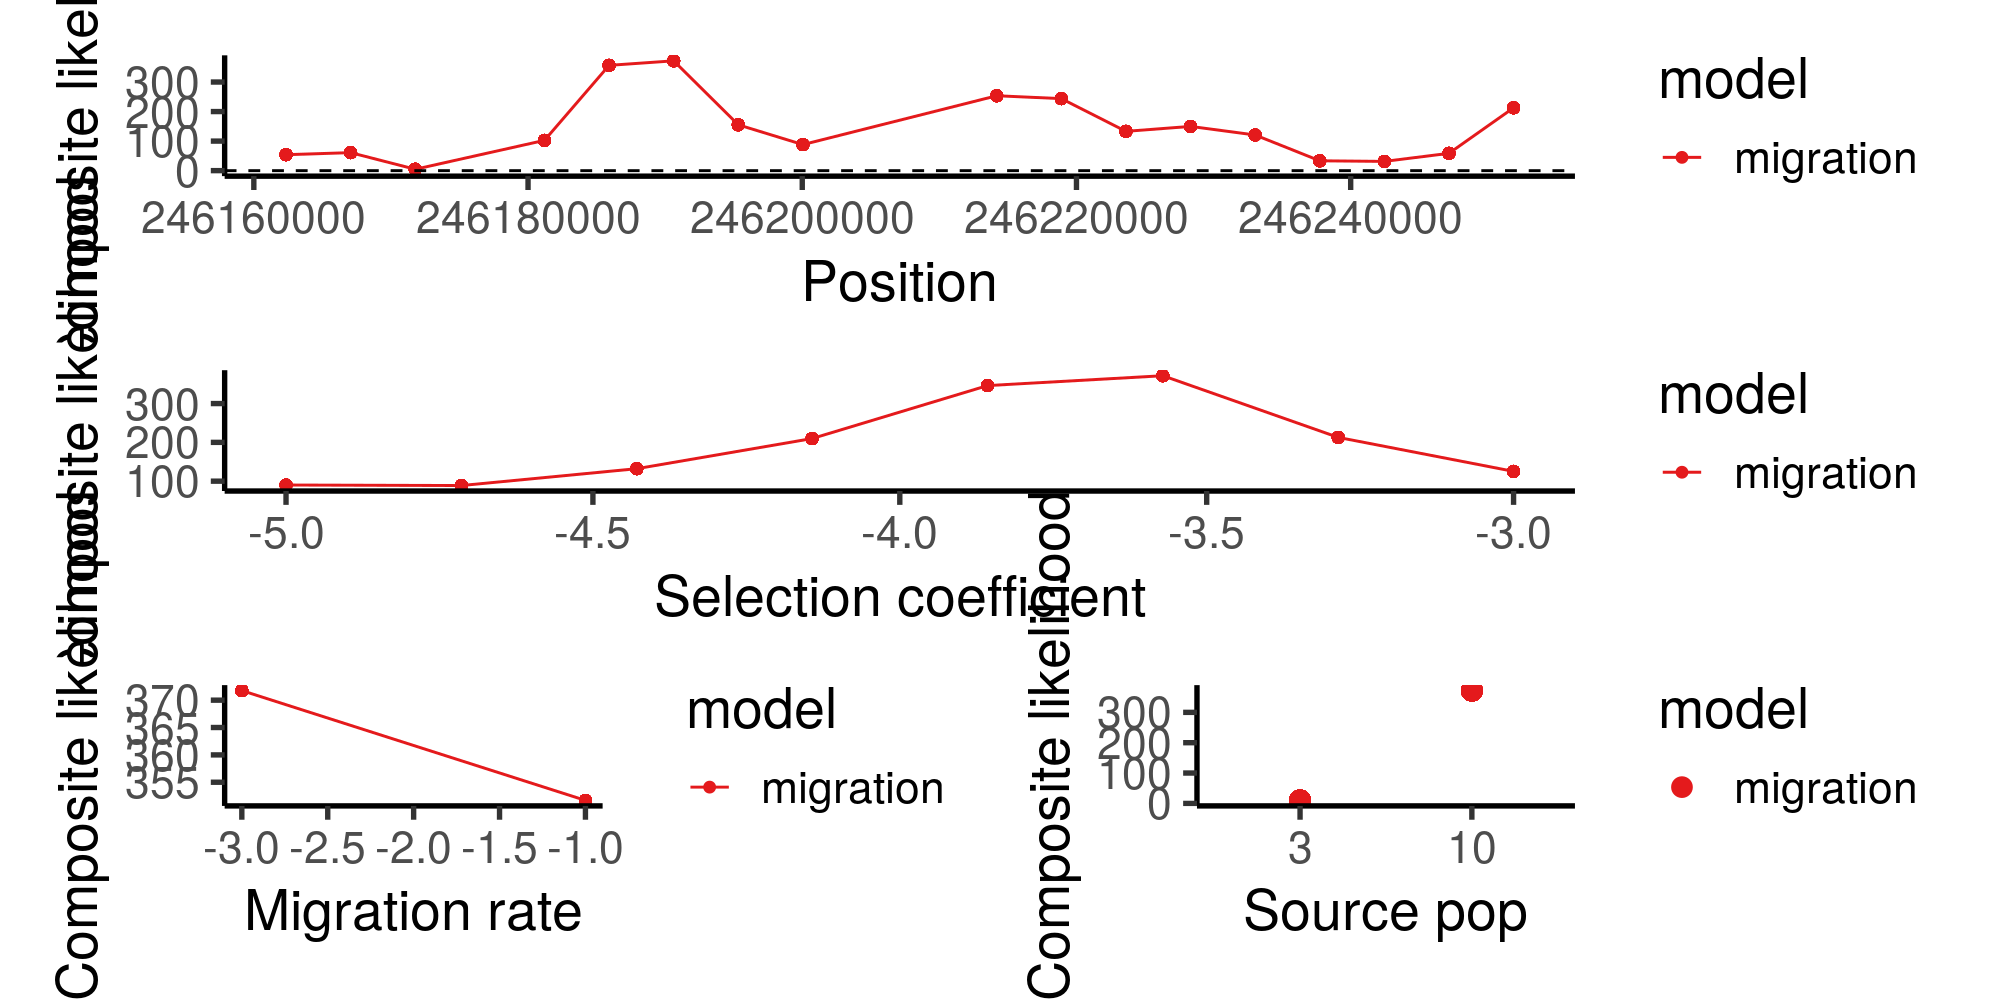

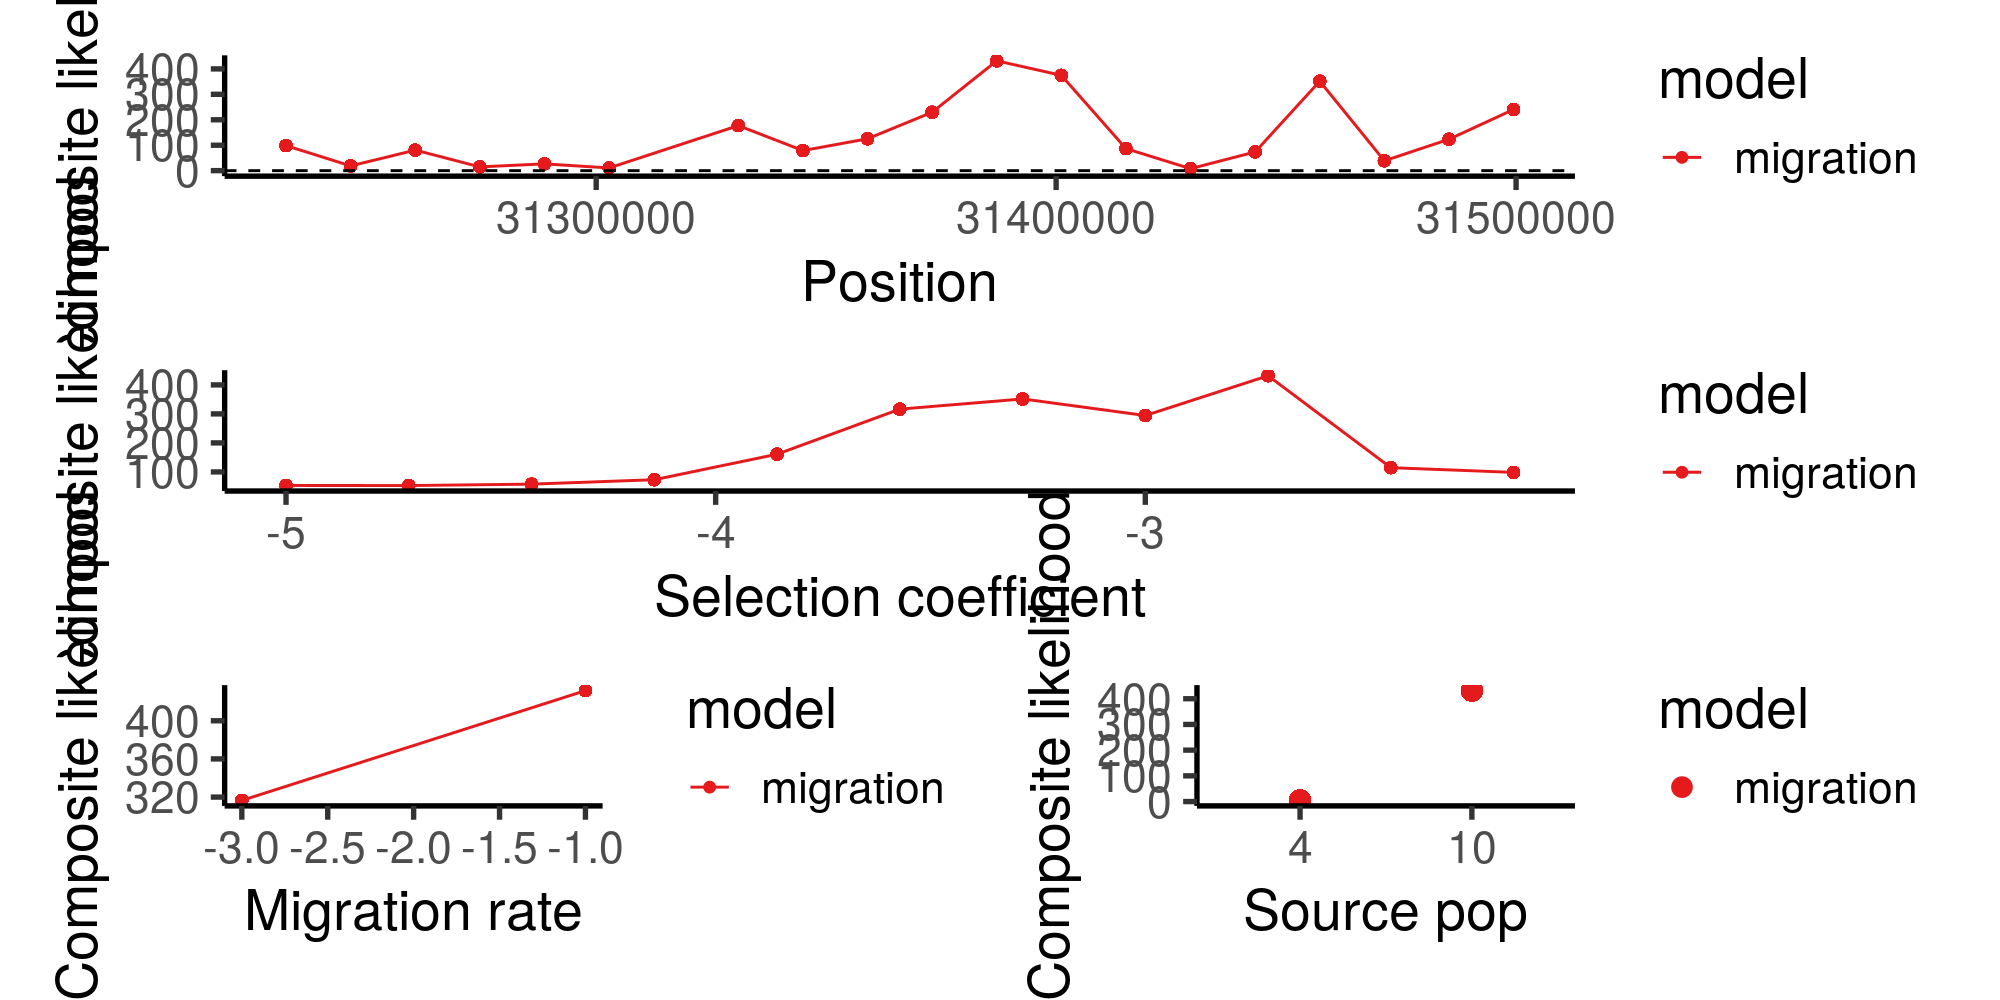

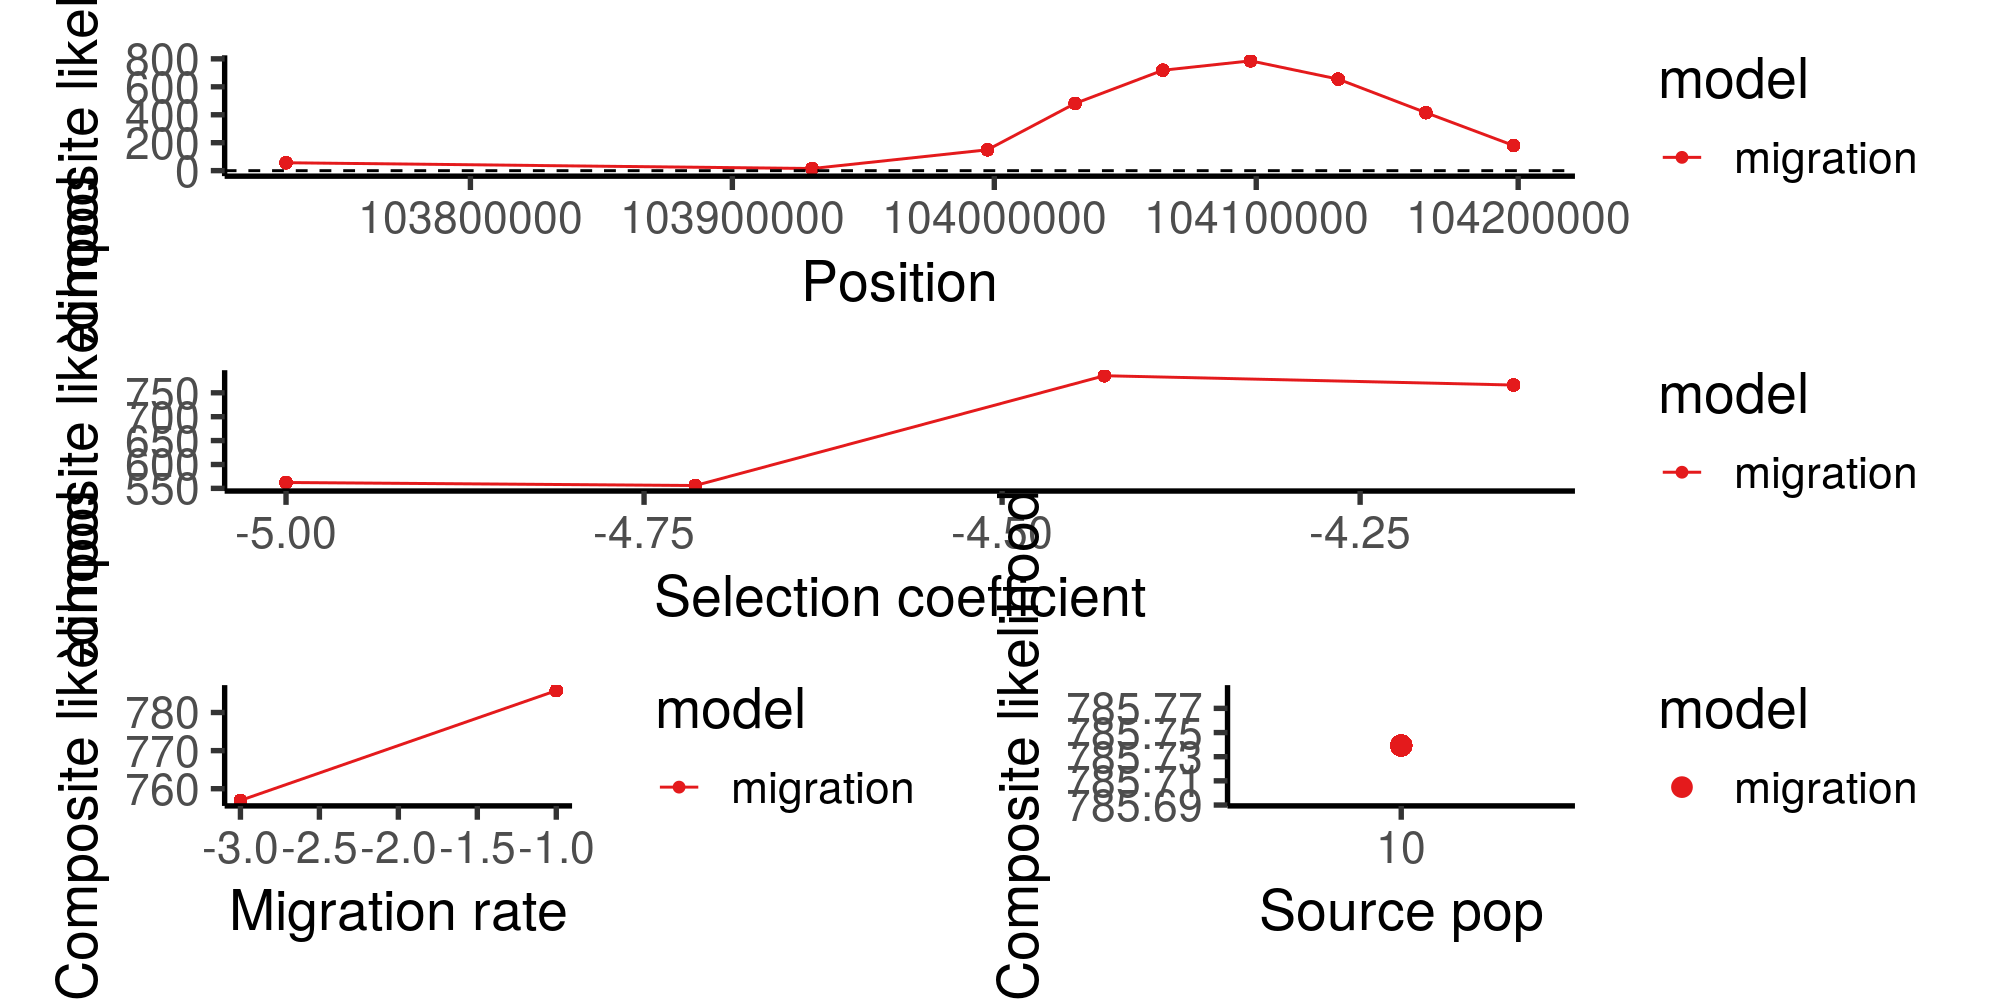

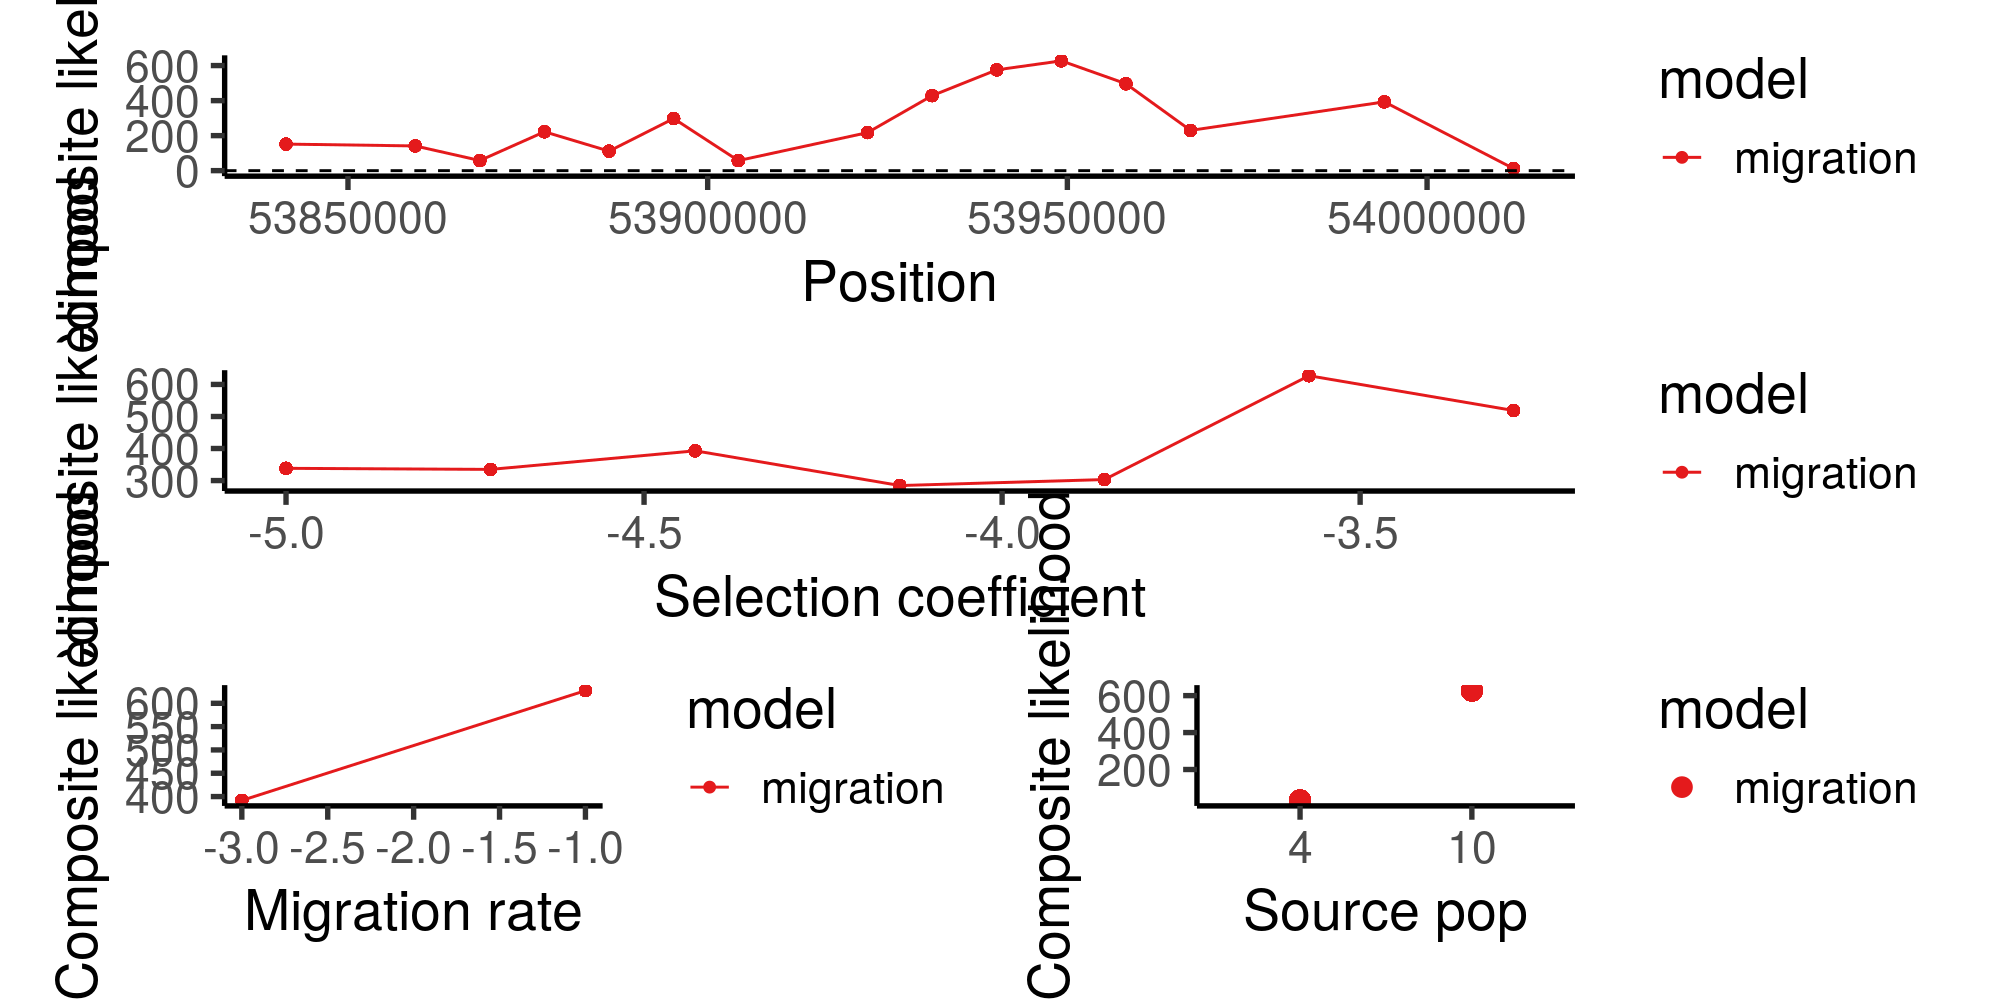

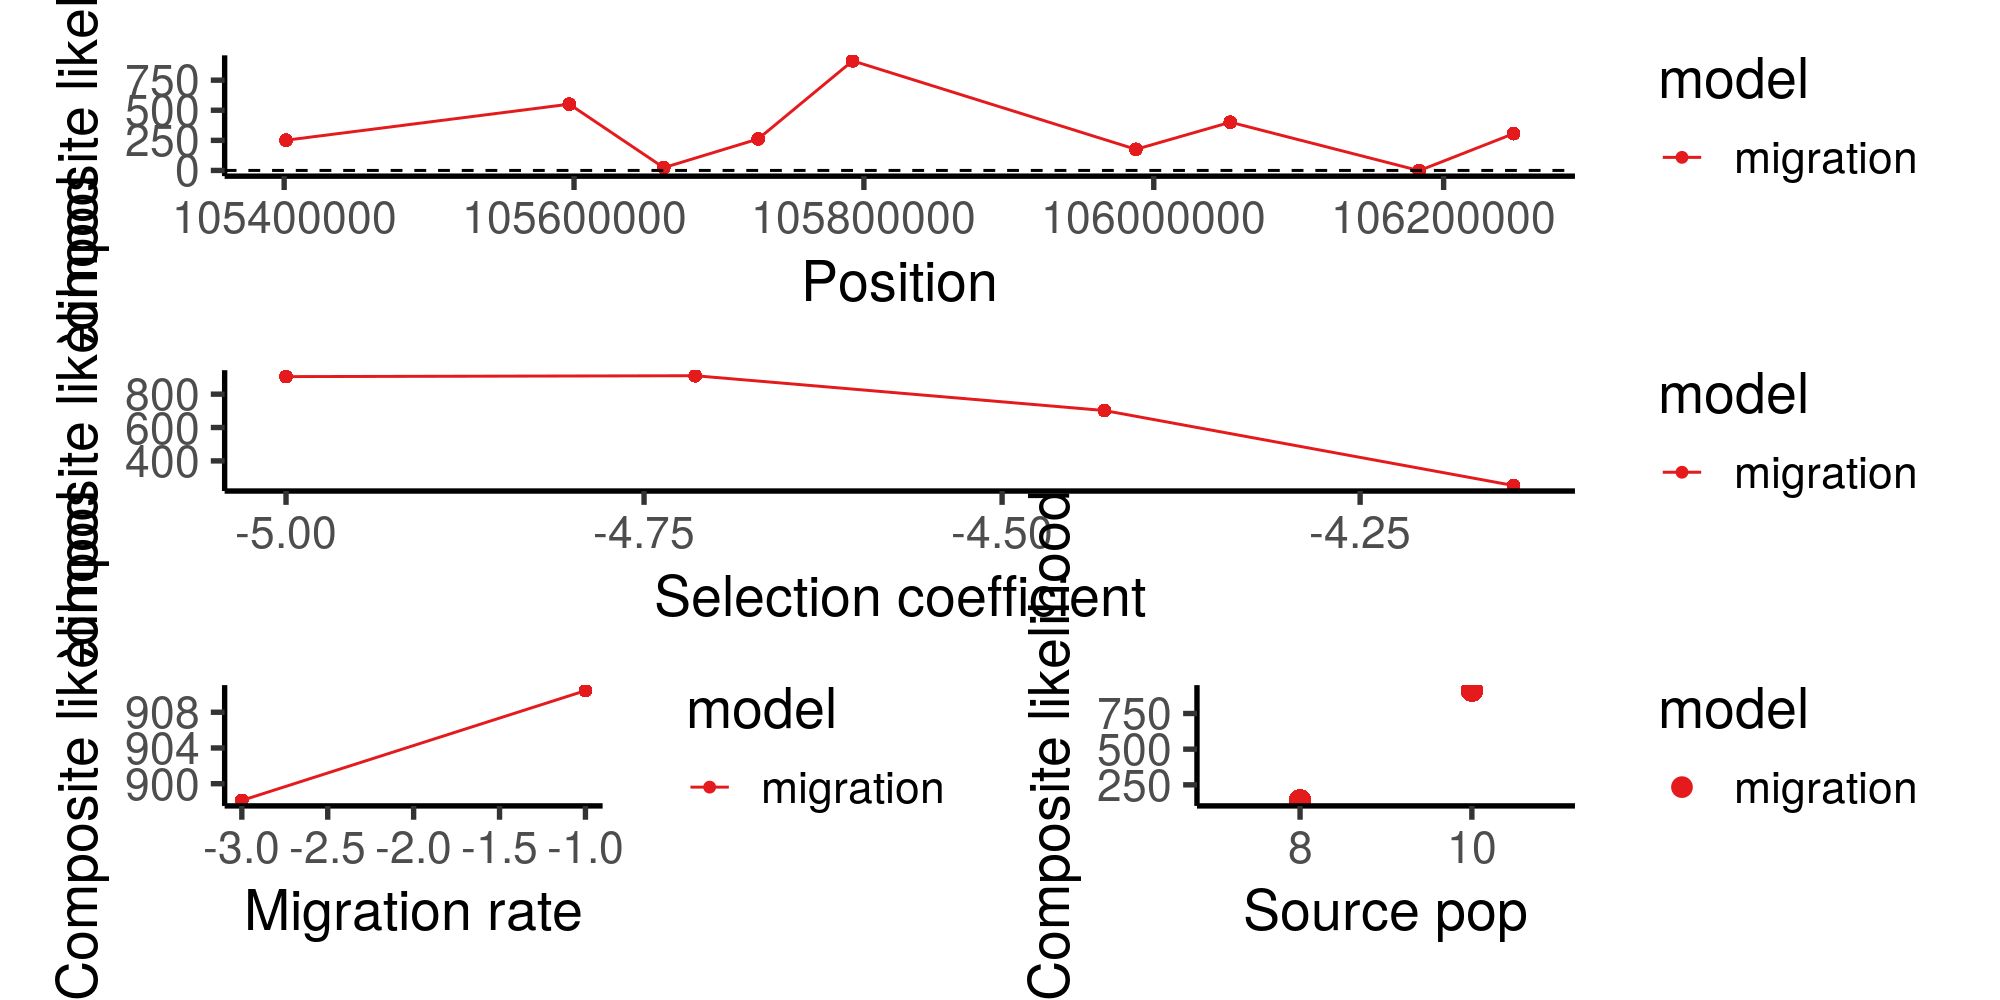

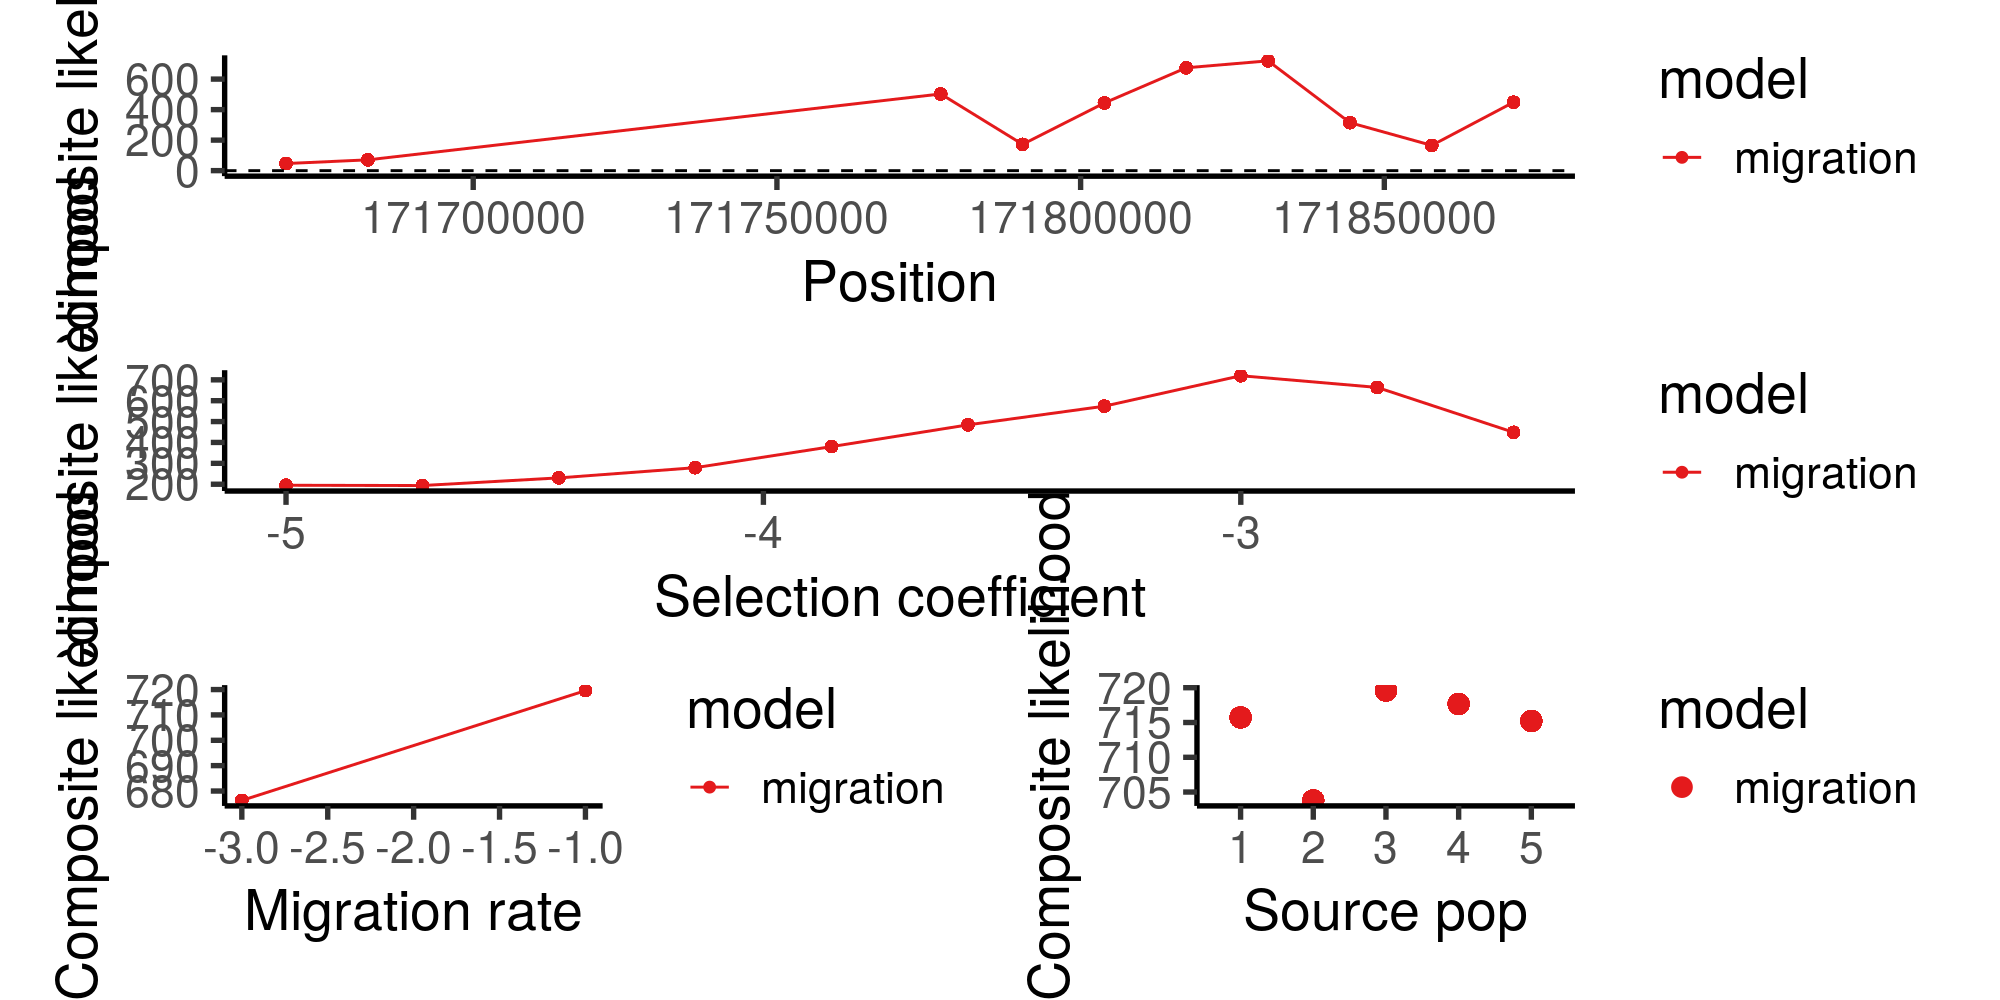

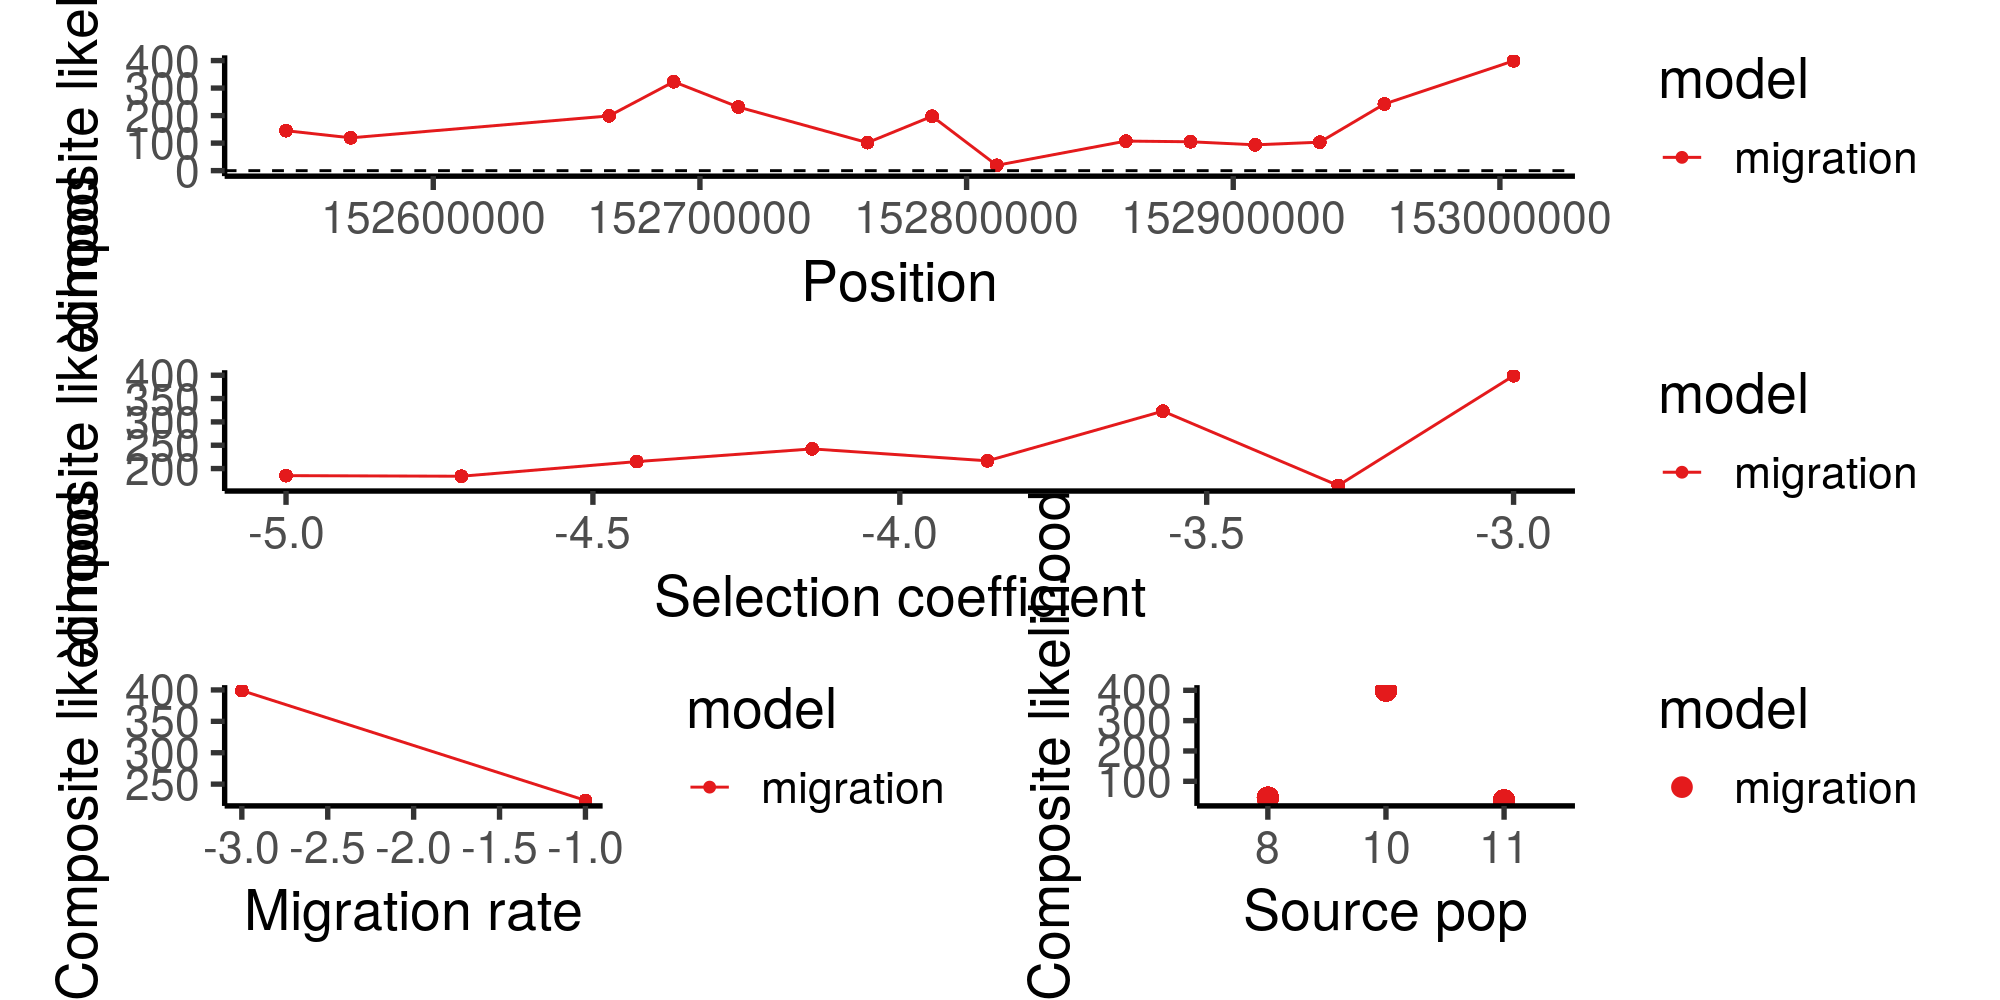

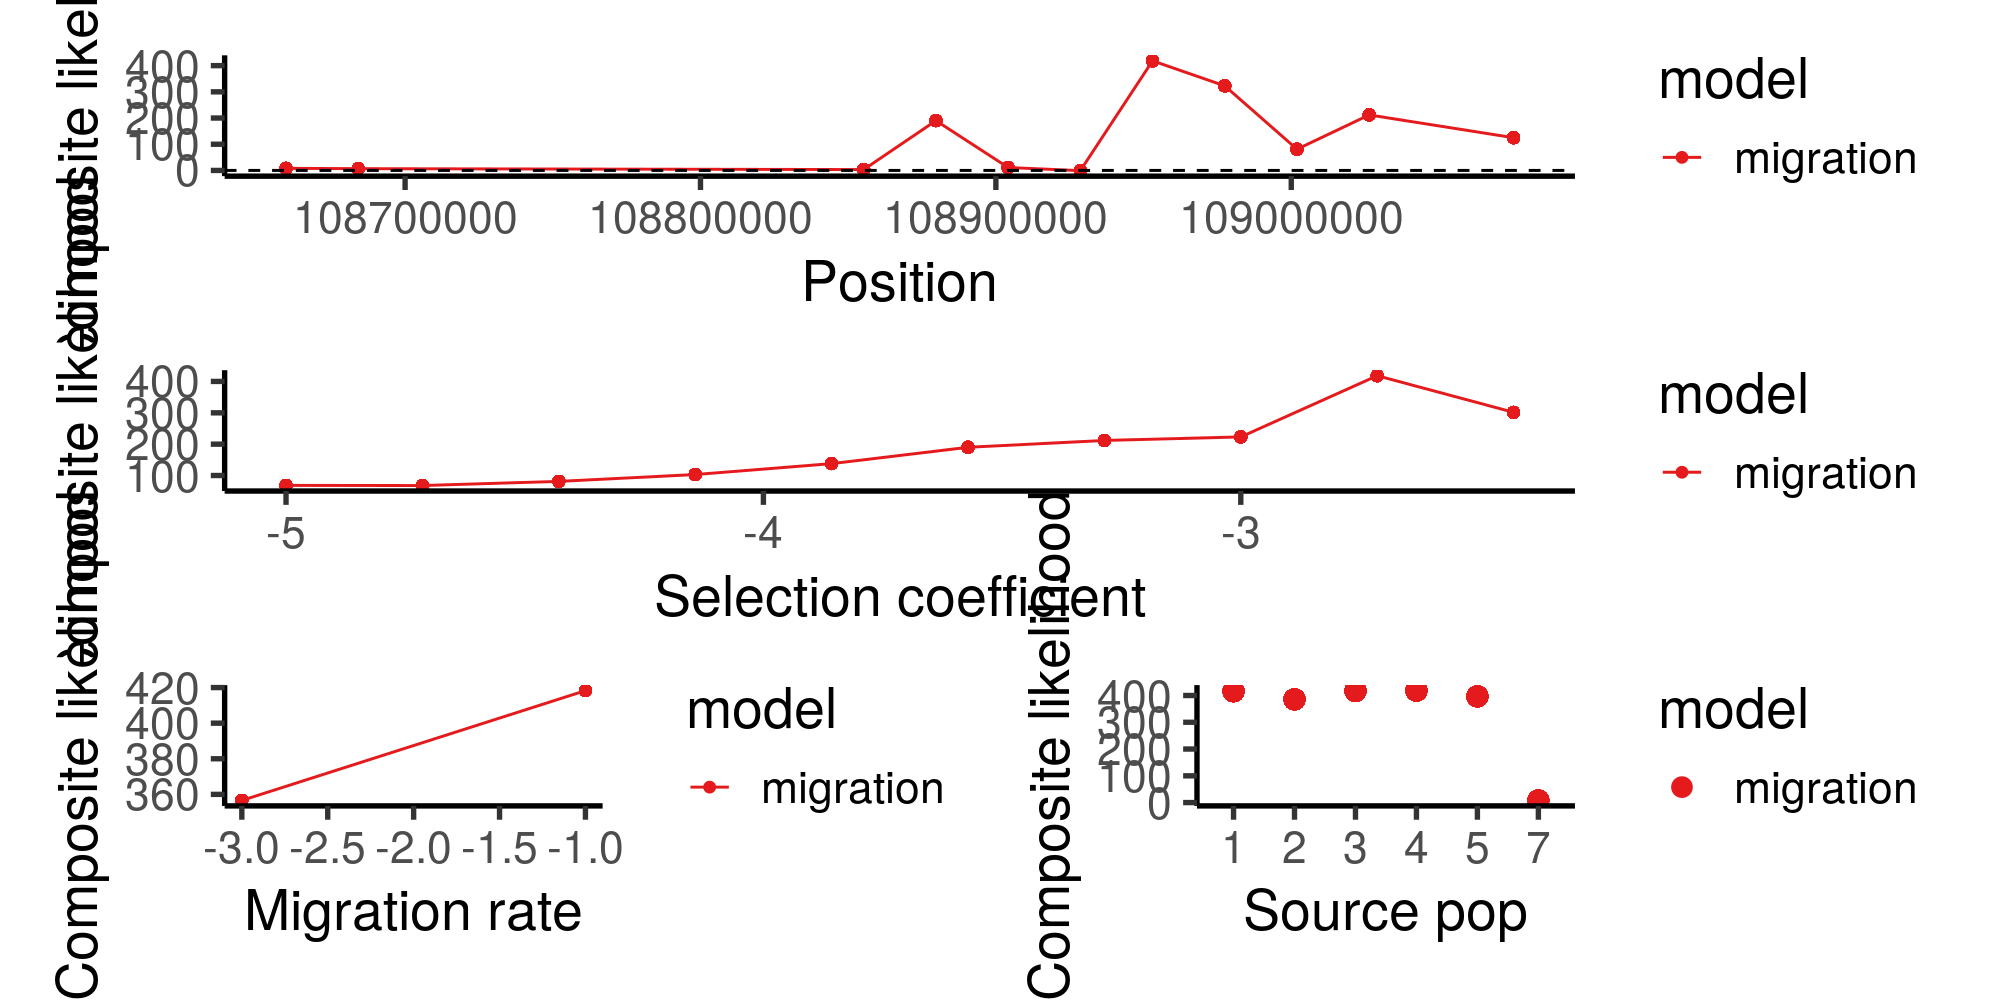

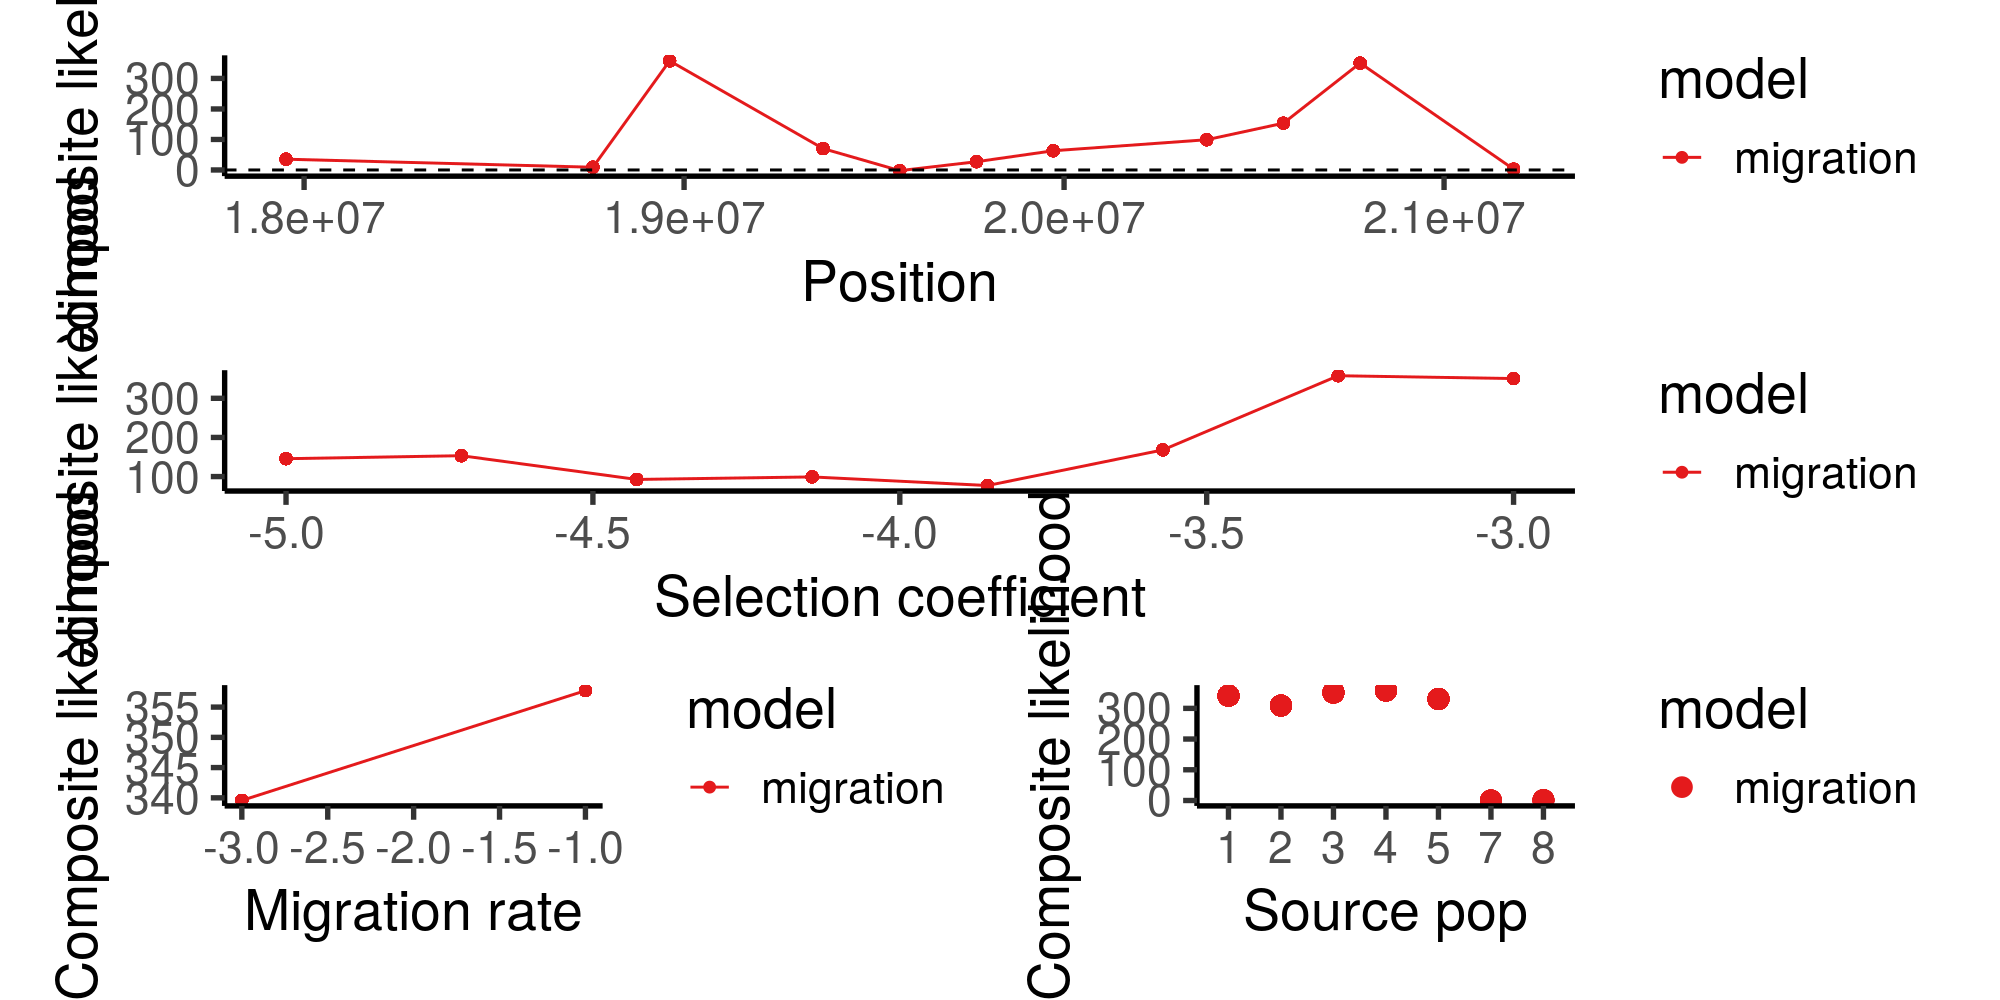

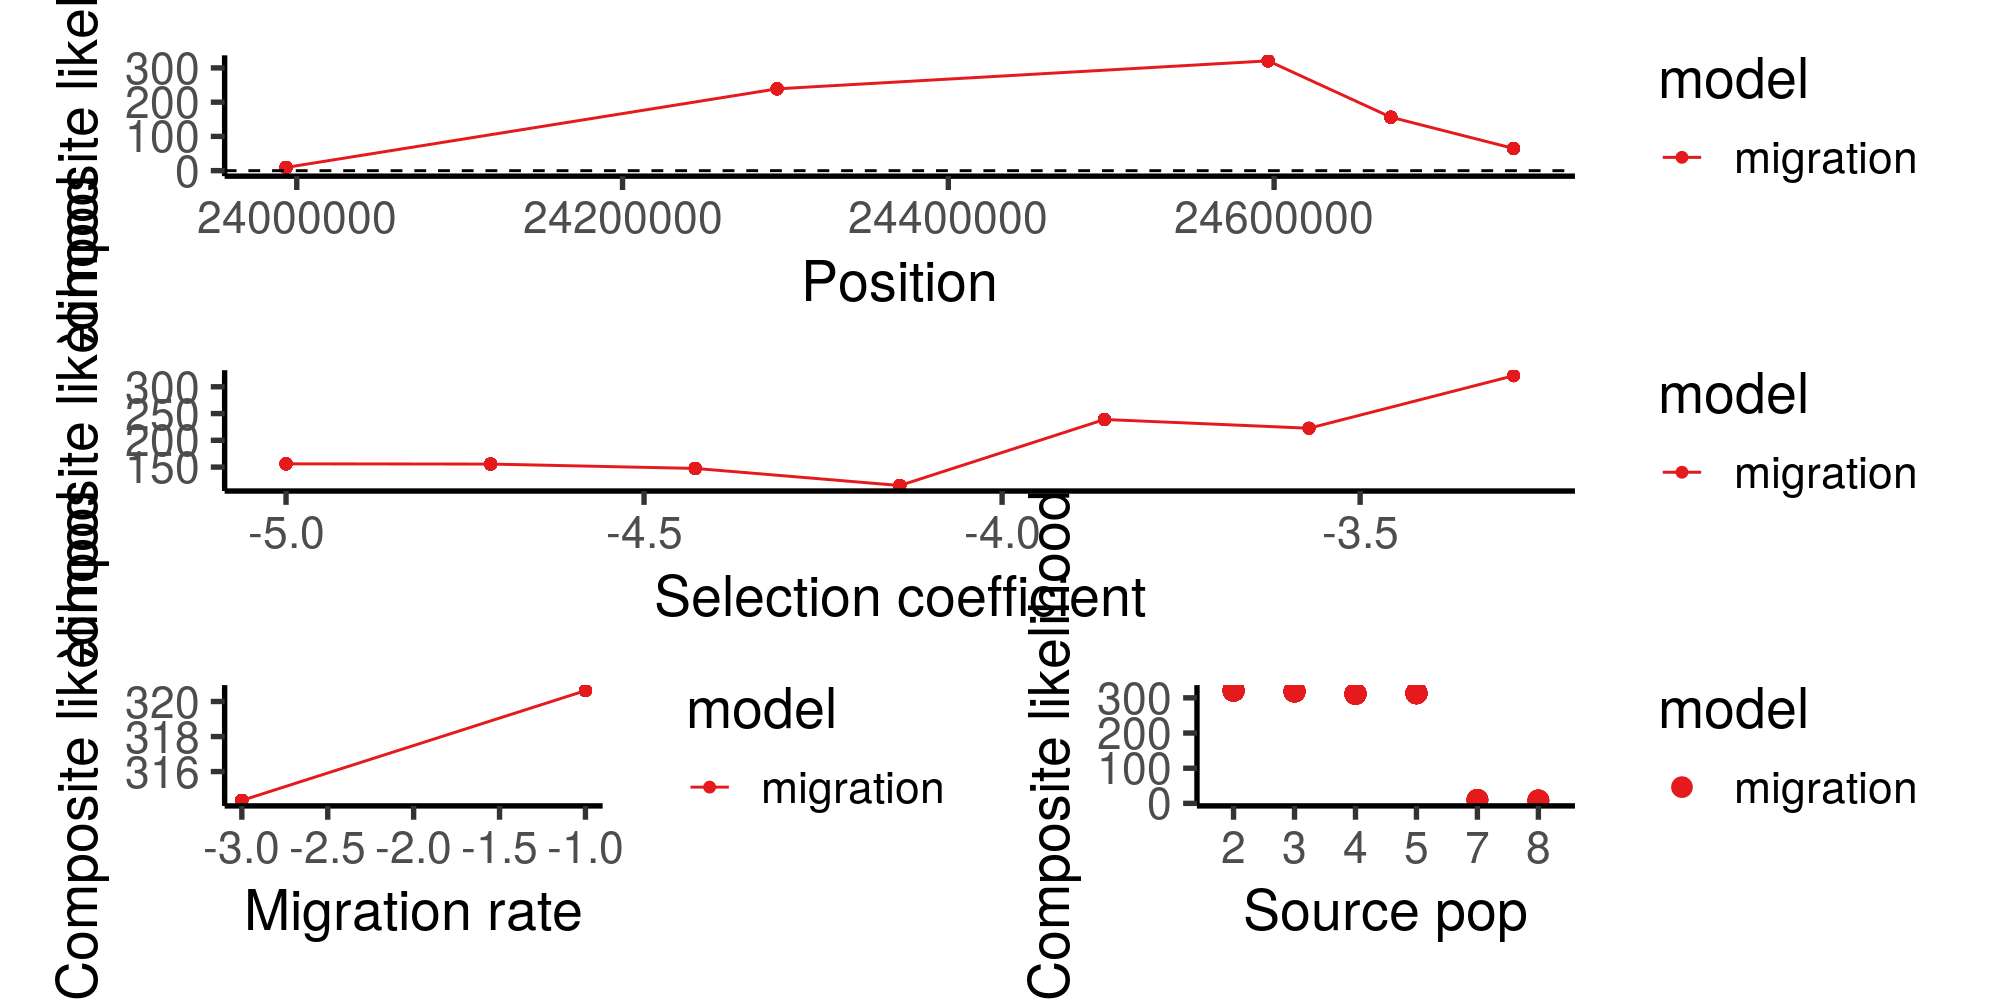

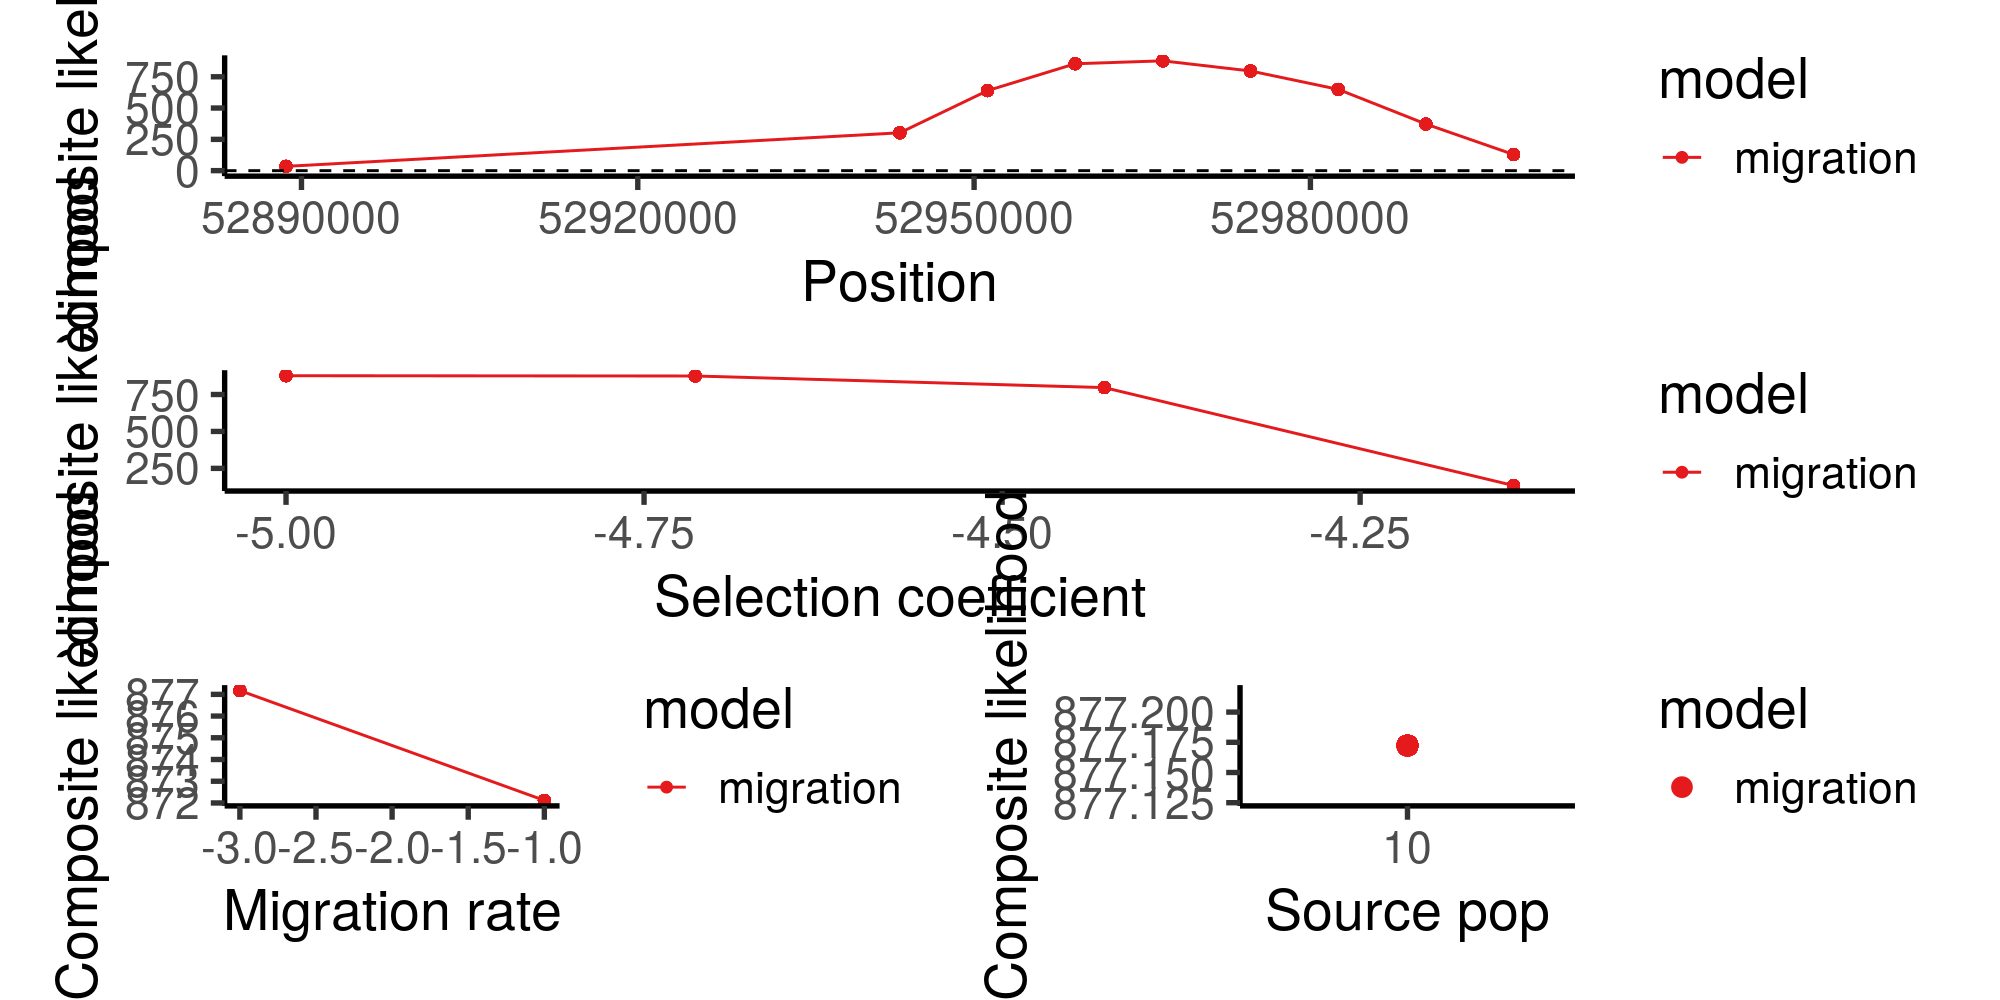

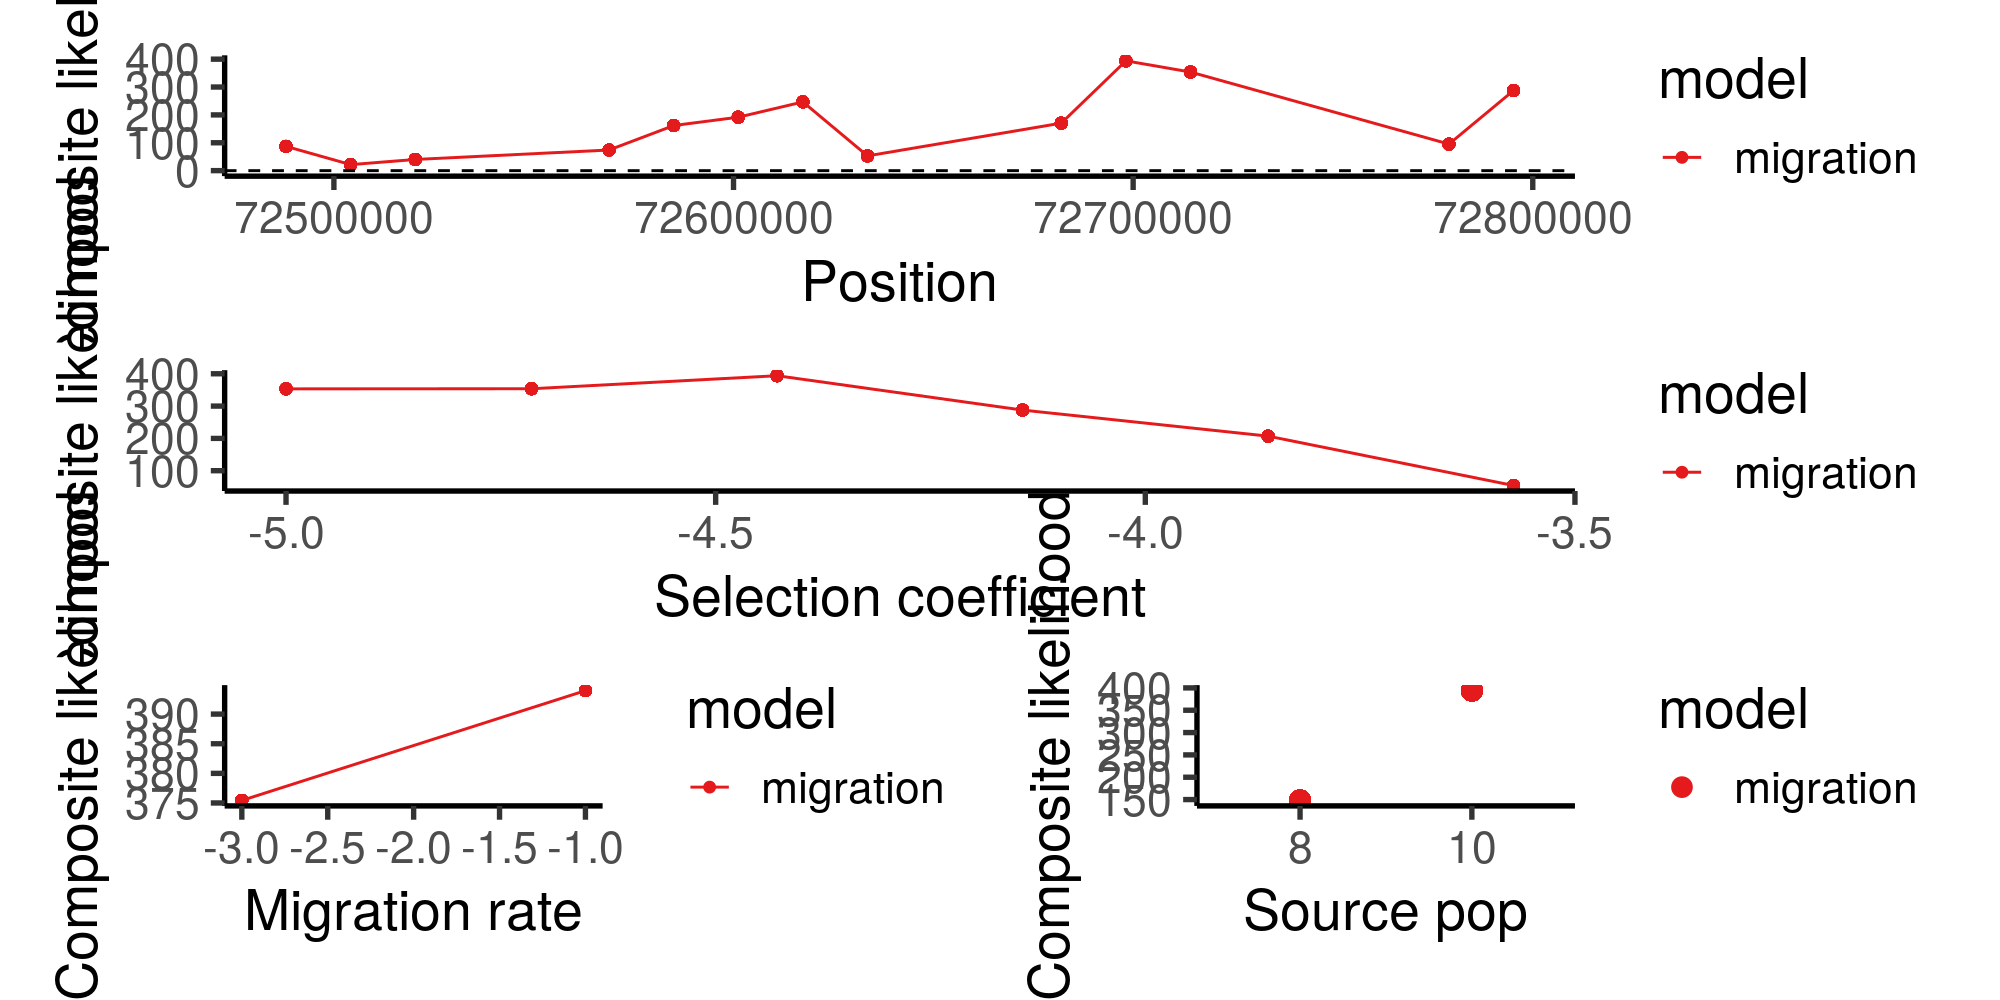

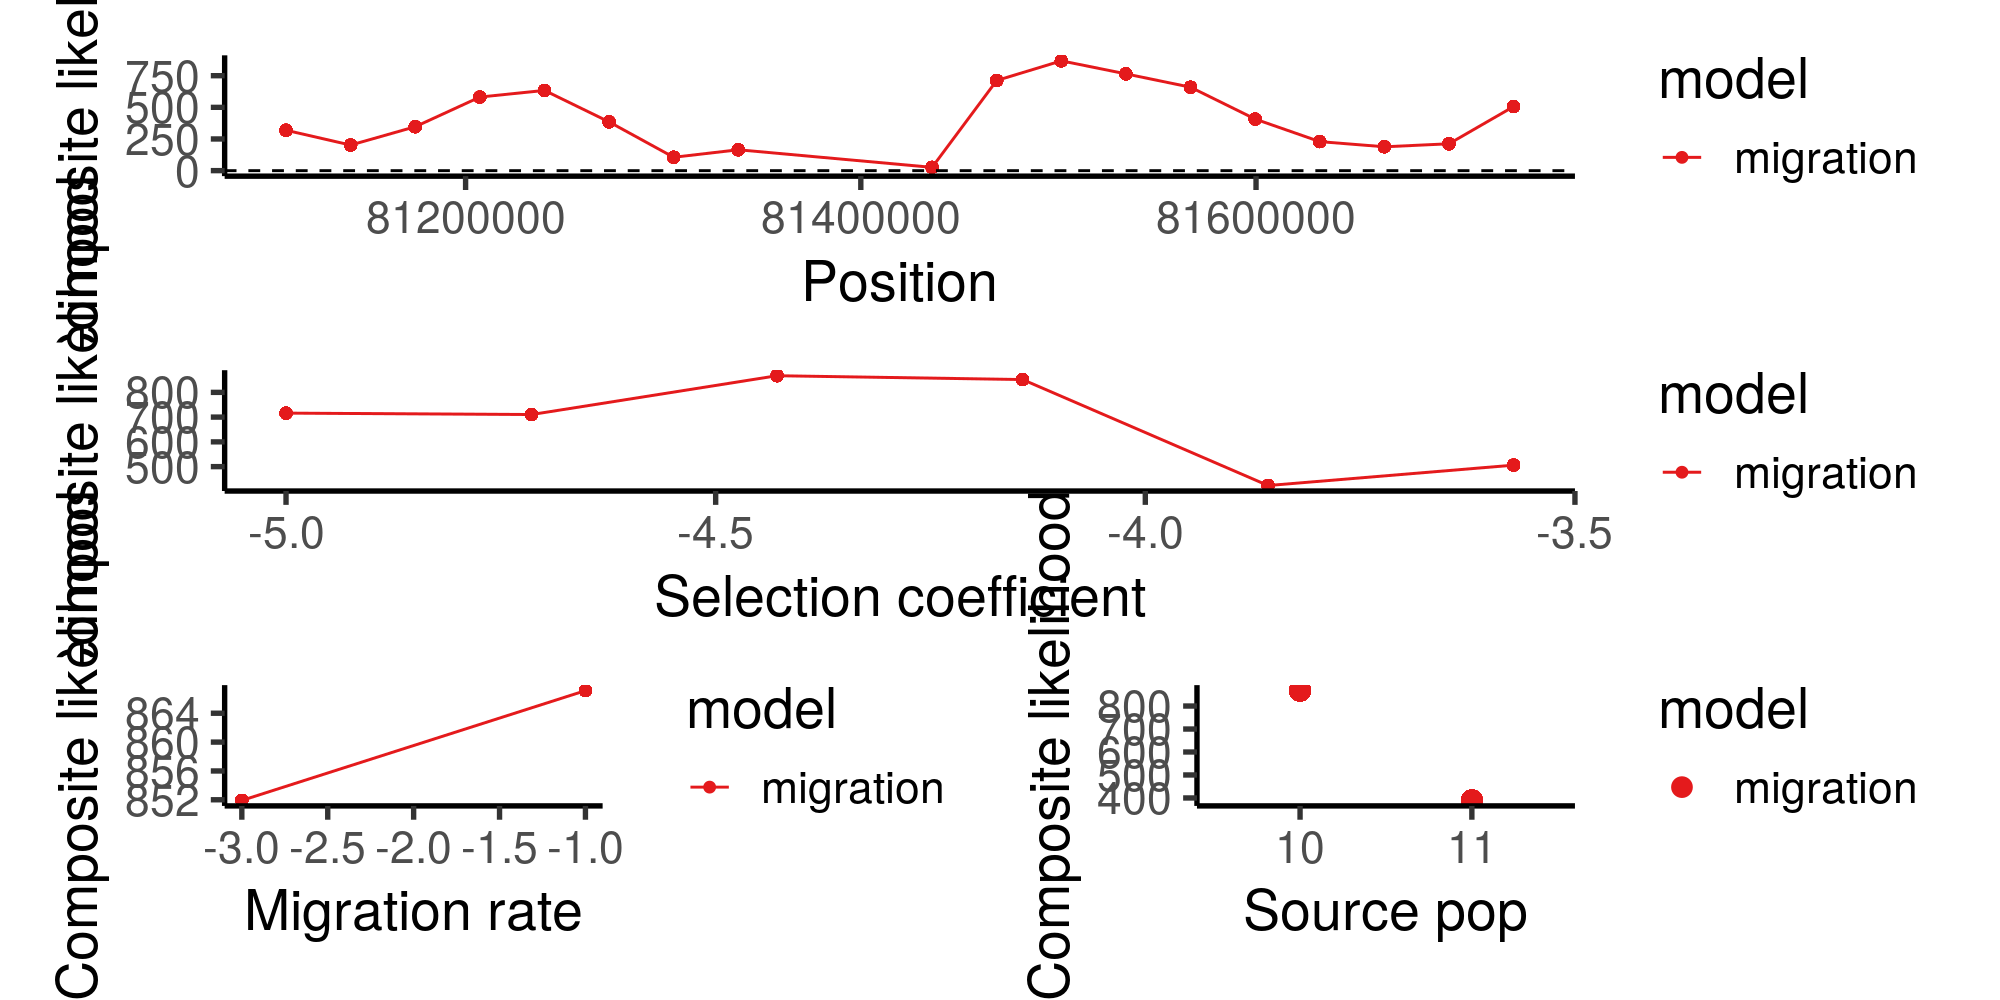

[[1]]

[[2]]

[[3]]

[[4]]
NULL

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]

[[11]]

[[12]]

[[13]]

[[14]]

[[15]]

[[16]]

[[17]]

[[18]]


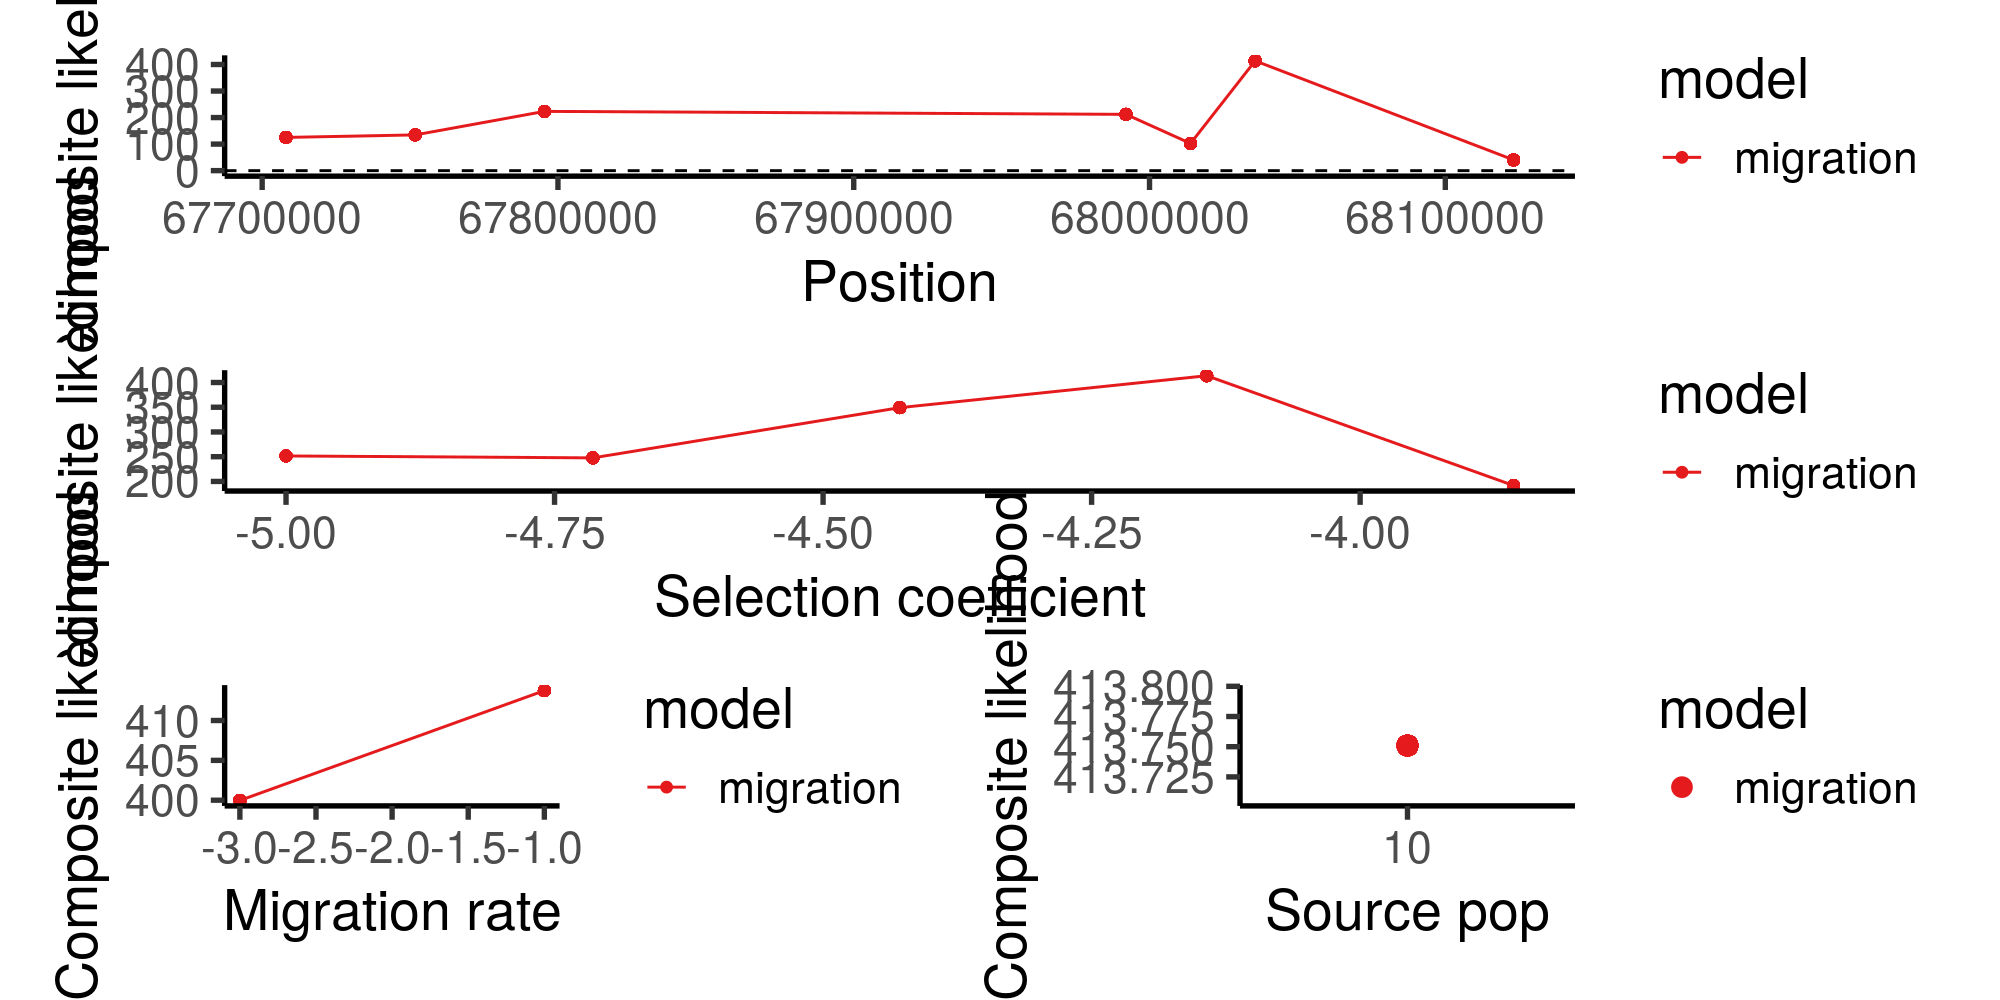

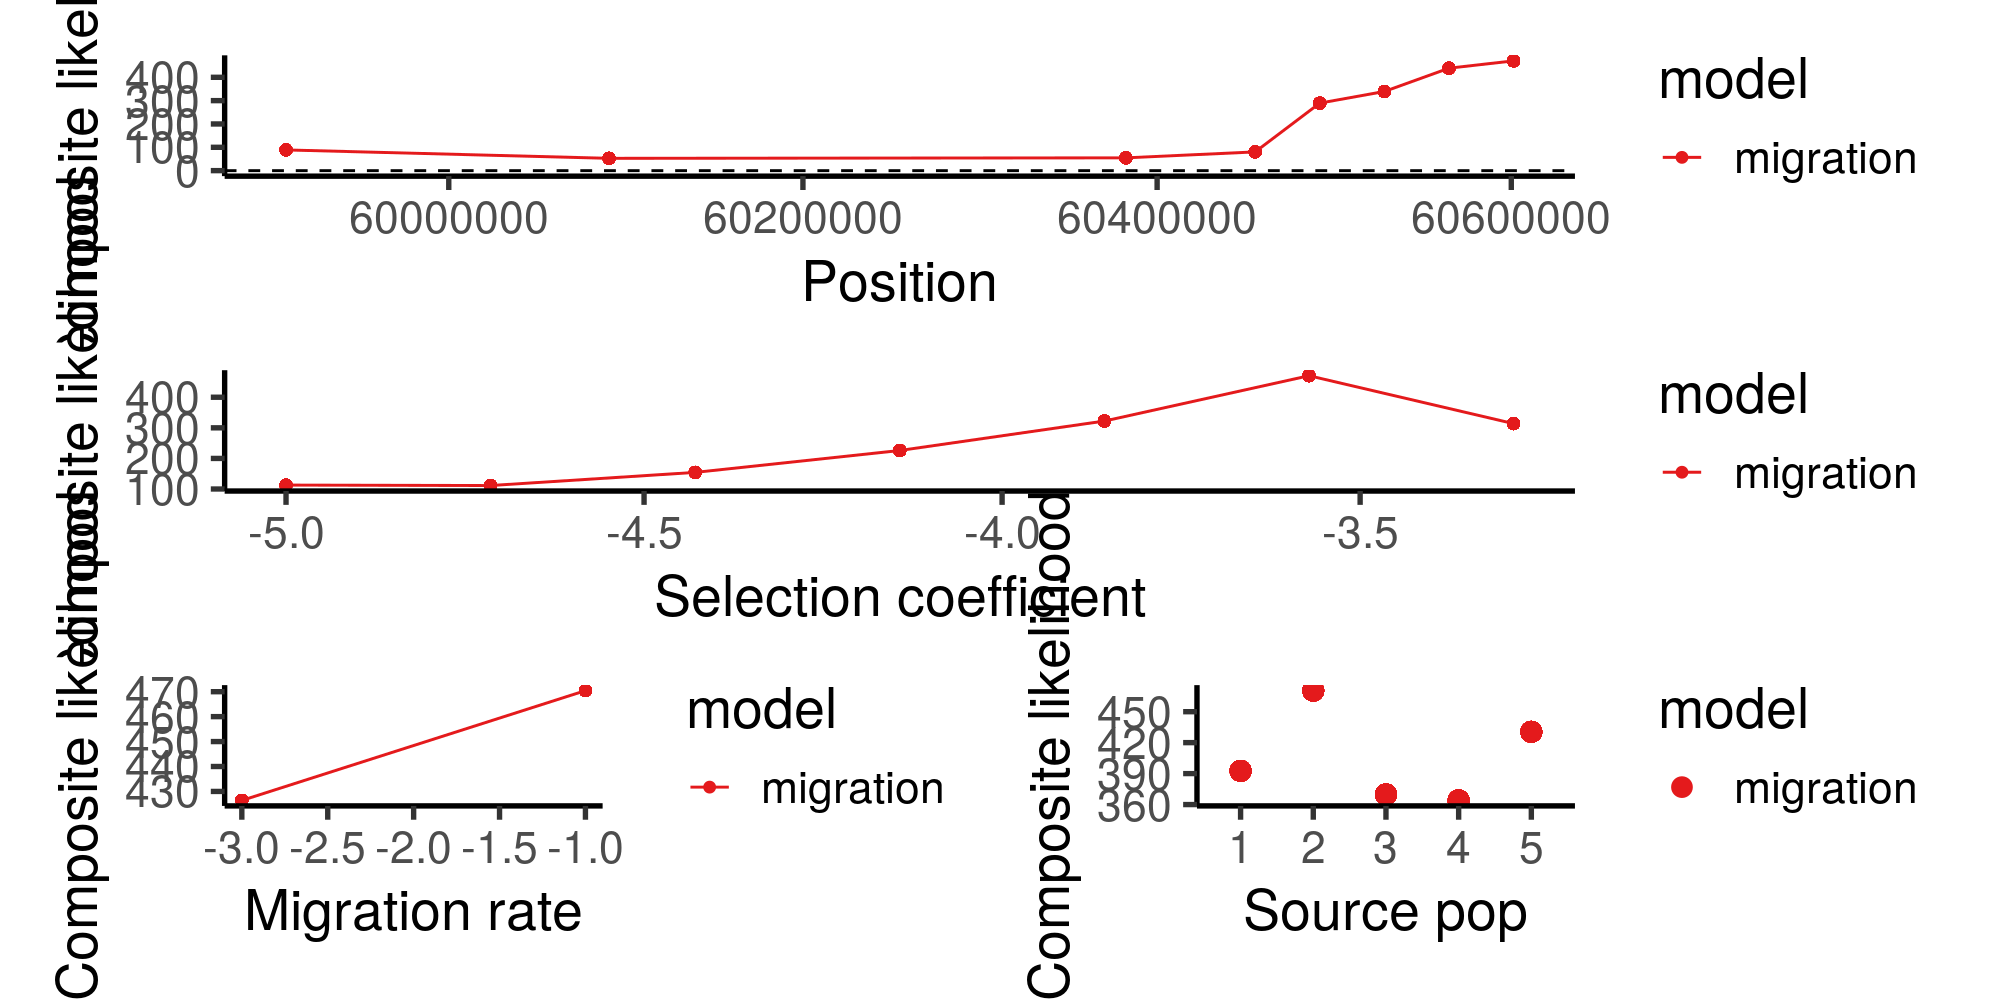

In [16]:

lr_files <- top_models_df %>% filter(model2 != "neutral", sel_pops == "1-2-3-4-5", mcle > 10) %>% pull(file_name)

q_high <- quantile(top_models_df$mcle, 0.99)
top_files <- top_models_df %>% filter(model2 != "neutral", mcle > q_high) %>% pull(file_name)
length(top_files)
suppressMessages(map(top_files, ~ plot_rdmc(.x, cle_low = -5)))

`summarise()` has grouped output by 'pop_count', 'times'. You can override using the `.groups` argument.



selected_sites sels         cle      
1 100198525      0.0000100000  40931.19
2 100256829      0.0000100000  34294.19
3 100508735      0.0000100000 122831.82
4  10410007      0.0005179475  55305.28
5  10466113      0.0001389495  49669.78
6 105283522      0.0000100000  79938.78
  locus                                                                                         
1 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start100197055_end100282945_pops2-4-5.txt  
2 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start100223517_end100282005_pops2-4-5.txt  
3 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start100393279_end100636254_pops1-4-5.txt  
4 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start10382710_end10518322_pops1-2-3-4-5.txt
5 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start10430149_end10517583_pops1-2-3-4-5.txt
6 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start105182522_end105338183_pops3-5.txt    
  gs    times migs sources sel_pops  model     ⋯ mcle          mcle_delta
1 0.001 100    NA  NA      2-4-5     standing  ⋯ -5.223216e-04 0         
2 0.001 100    NA  NA      2-4-5     standing  ⋯ -2.313819e-03 0         
3 0.001 100    NA  NA      1-4-5     standing  ⋯ -3.317808e-06 0         
4    NA  NA   0.1   2      1-2-3-4-5 migration ⋯  4.463767e+00 0         
5    NA  NA   0.1   2      1-2-3-4-5 migration ⋯  3.805085e+00 0         
6 0.001 100    NA  NA      3-5       standing  ⋯ -4.647760e-01 0         
  mcle_nextbest_diff
1   2.850449        
2 114.165837        
3  35.372594        
4   4.463767        
5   3.805085        
6  98.471809        
  file_name                                                                                   
1 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start100197055_end100282945_pops2-4-5.txt  
2 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start100223517_end100282005_pops2-4-5.txt  
3 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start100393279_end100636254_pops1-4-5.txt  
4 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start10382710_end10518322_pops1-2-3-4-5.txt
5 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start10430149_end10517583_pops1-2-3-4-5.txt
6 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start105182522_end105338183_pops3-5.txt    
  populations                                                                                                               
1 v5--LR--Crucero_Lagunitas; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo                                              
2 v5--LR--Crucero_Lagunitas; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo                                              
3 v5--LR--Amatlan_de_Canas; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo                                               
4 v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo
5 v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo
6 v5--LR--Los_Guajes; v5--LR--San_Lorenzo                                                                                   
  type      pop_count Landraces_count Teosinte_count model2   
1 Landraces 3         3               0              neutral  
2 Landraces 3         3               0              neutral  
3 Landraces 3         3               0              neutral  
4 Landraces 5         5               0              migration
5 Landraces 5         5               0              migration
6 Landraces 2         2               0              neutral

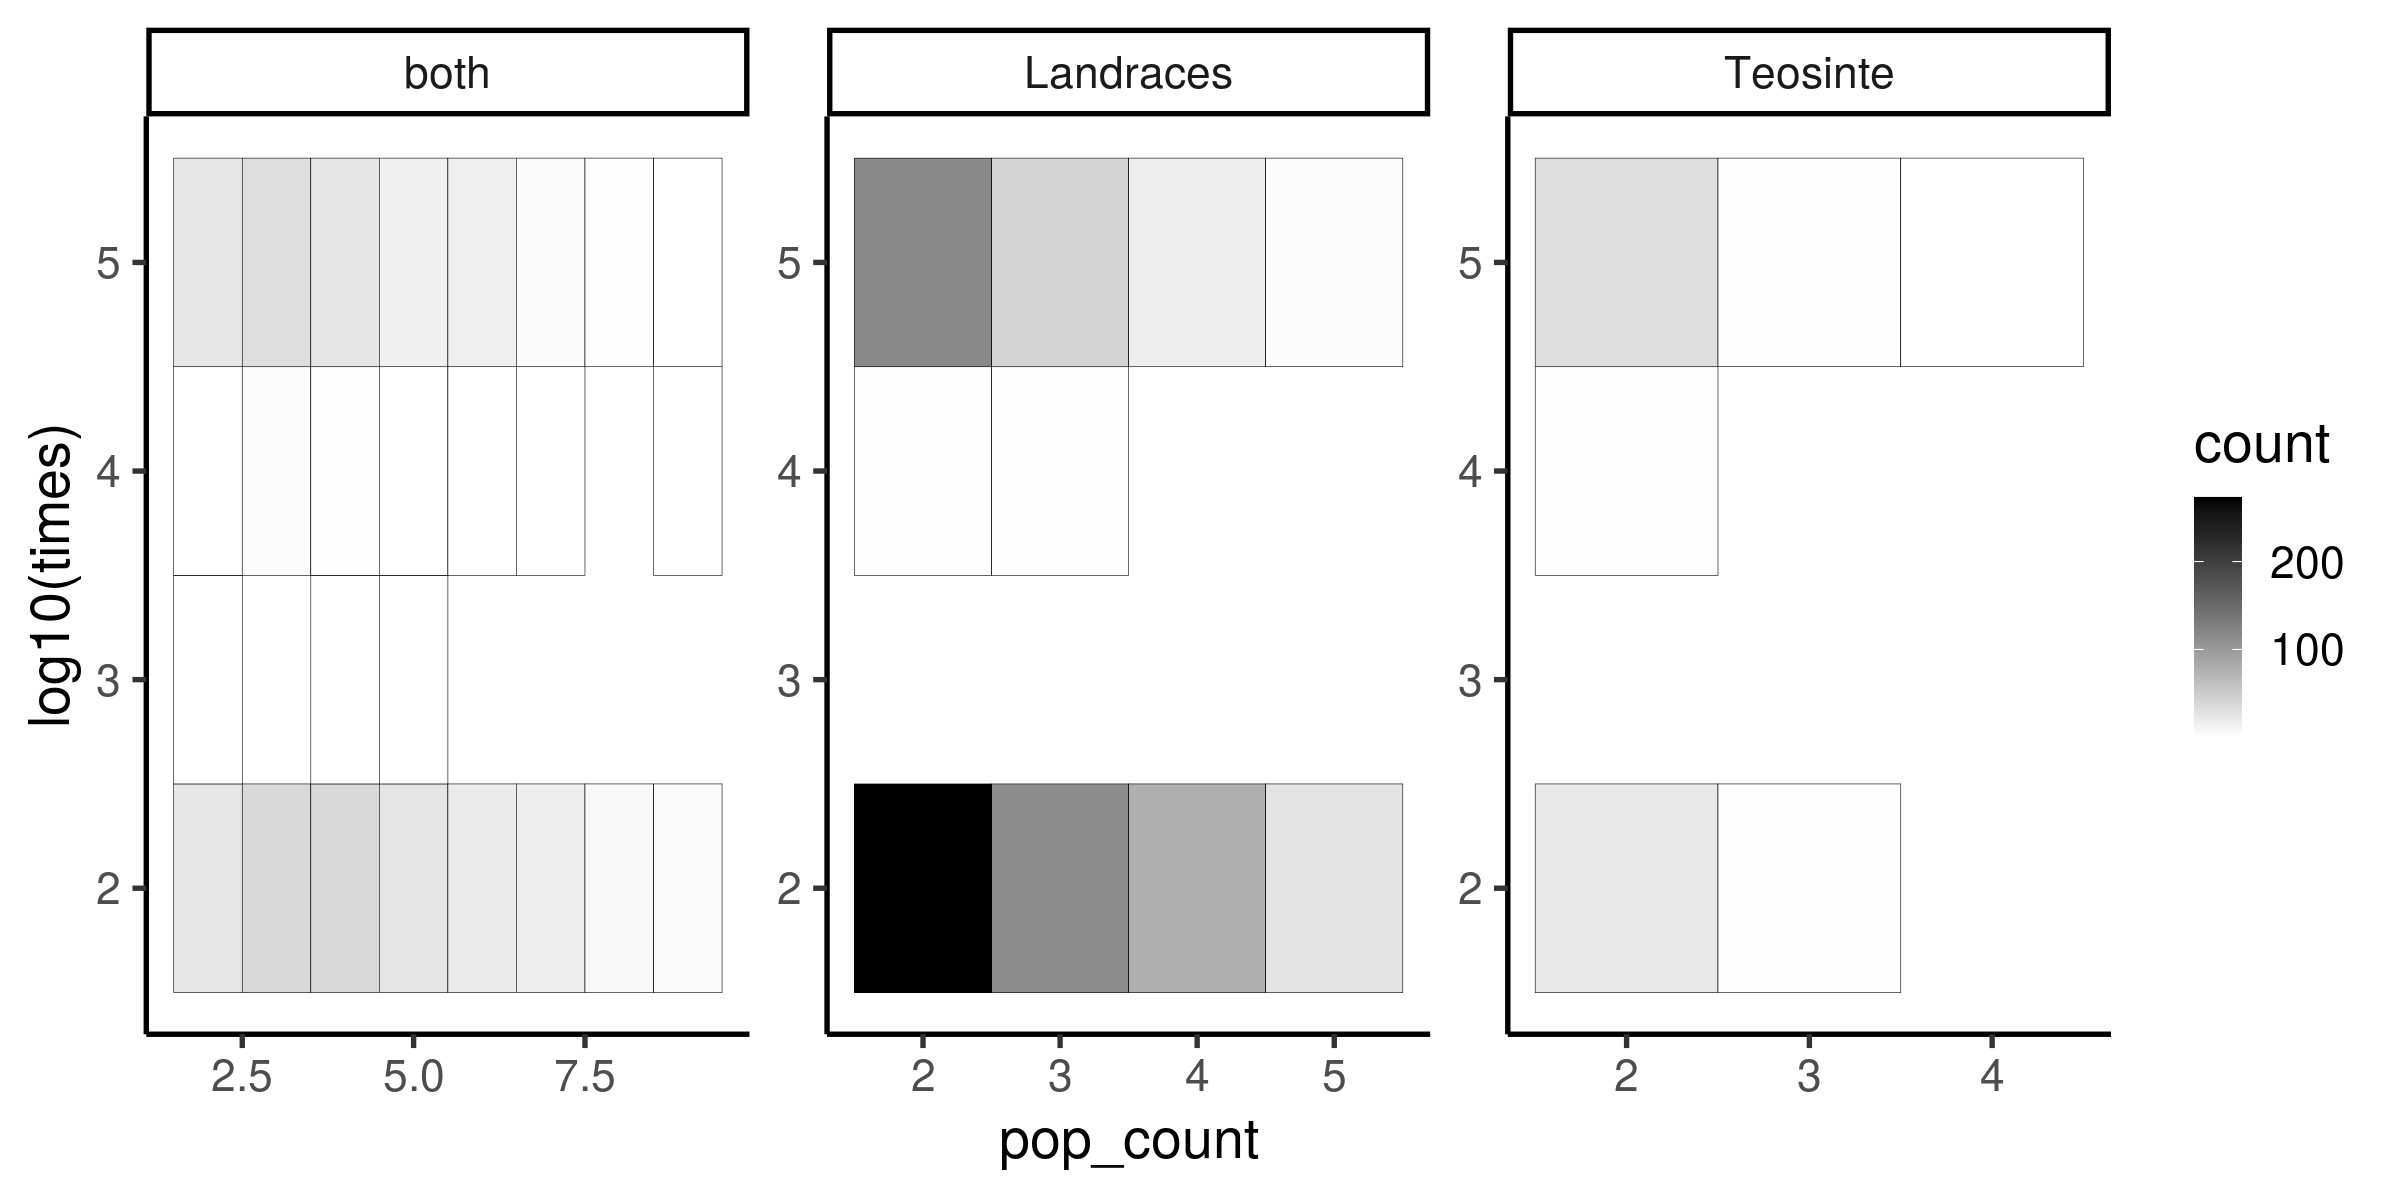

In [17]:
options(repr.plot.width = 12, repr.plot.height = 6 , repr.plot.res = 200)

top_models_df %>% 
    select(pop_count, times, type) %>% 
    drop_na() %>% 
    group_by(pop_count, times, type) %>% 
    summarise(count = n()) %>% 
    ggplot(aes(pop_count, log10(times), fill = count)) +
    geom_tile(color = "black") +
    facet_wrap(~type, scales = "free") +
    scale_fill_gradient(low = "white", high = "black")

head(top_models_df)

# FIGURE 5

`summarise()` has grouped output by 'type'. You can override using the `.groups` argument.



type      model2      n()
1  both      independent   3
2  both      migration   317
3  both      neutral     174
4  both      standing    137
5  Landraces independent  12
6  Landraces migration   316
7  Landraces neutral     416
8  Landraces standing    264
9  Teosinte  independent   2
10 Teosinte  migration    30
11 Teosinte  neutral      37
12 Teosinte  standing     26

model2      n()
1 independent  17
2 migration   663
3 neutral     627
4 standing    427

[1] 1734

`summarise()` has grouped output by 'type'. You can override using the `.groups` argument.



[1] "HERE!"


selected_sites sels         cle      
1 100198525      0.0000100000  40931.19
2 100256829      0.0000100000  34294.19
3 100508735      0.0000100000 122831.82
4  10410007      0.0005179475  55305.28
5  10466113      0.0001389495  49669.78
6 105283522      0.0000100000  79938.78
  locus                                                                                         
1 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start100197055_end100282945_pops2-4-5.txt  
2 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start100223517_end100282005_pops2-4-5.txt  
3 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start100393279_end100636254_pops1-4-5.txt  
4 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start10382710_end10518322_pops1-2-3-4-5.txt
5 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start10430149_end10517583_pops1-2-3-4-5.txt
6 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start105182522_end105338183_pops3-5.txt    
  gs    times migs sources sel_pops  model     ⋯ mcle          mcle_delta
1 0.001 100    NA  NA      2-4-5     standing  ⋯ -5.223216e-04 0         
2 0.001 100    NA  NA      2-4-5     standing  ⋯ -2.313819e-03 0         
3 0.001 100    NA  NA      1-4-5     standing  ⋯ -3.317808e-06 0         
4    NA  NA   0.1   2      1-2-3-4-5 migration ⋯  4.463767e+00 0         
5    NA  NA   0.1   2      1-2-3-4-5 migration ⋯  3.805085e+00 0         
6 0.001 100    NA  NA      3-5       standing  ⋯ -4.647760e-01 0         
  mcle_nextbest_diff
1   2.850449        
2 114.165837        
3  35.372594        
4   4.463767        
5   3.805085        
6  98.471809        
  file_name                                                                                   
1 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start100197055_end100282945_pops2-4-5.txt  
2 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start100223517_end100282005_pops2-4-5.txt  
3 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start100393279_end100636254_pops1-4-5.txt  
4 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start10382710_end10518322_pops1-2-3-4-5.txt
5 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start10430149_end10517583_pops1-2-3-4-5.txt
6 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start105182522_end105338183_pops3-5.txt    
  populations                                                                                                               
1 v5--LR--Crucero_Lagunitas; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo                                              
2 v5--LR--Crucero_Lagunitas; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo                                              
3 v5--LR--Amatlan_de_Canas; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo                                               
4 v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo
5 v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo
6 v5--LR--Los_Guajes; v5--LR--San_Lorenzo                                                                                   
  type      pop_count Landraces_count Teosinte_count model2   
1 Landraces 3         3               0              neutral  
2 Landraces 3         3               0              neutral  
3 Landraces 3         3               0              neutral  
4 Landraces 5         5               0              migration
5 Landraces 5         5               0              migration
6 Landraces 2         2               0              neutral

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


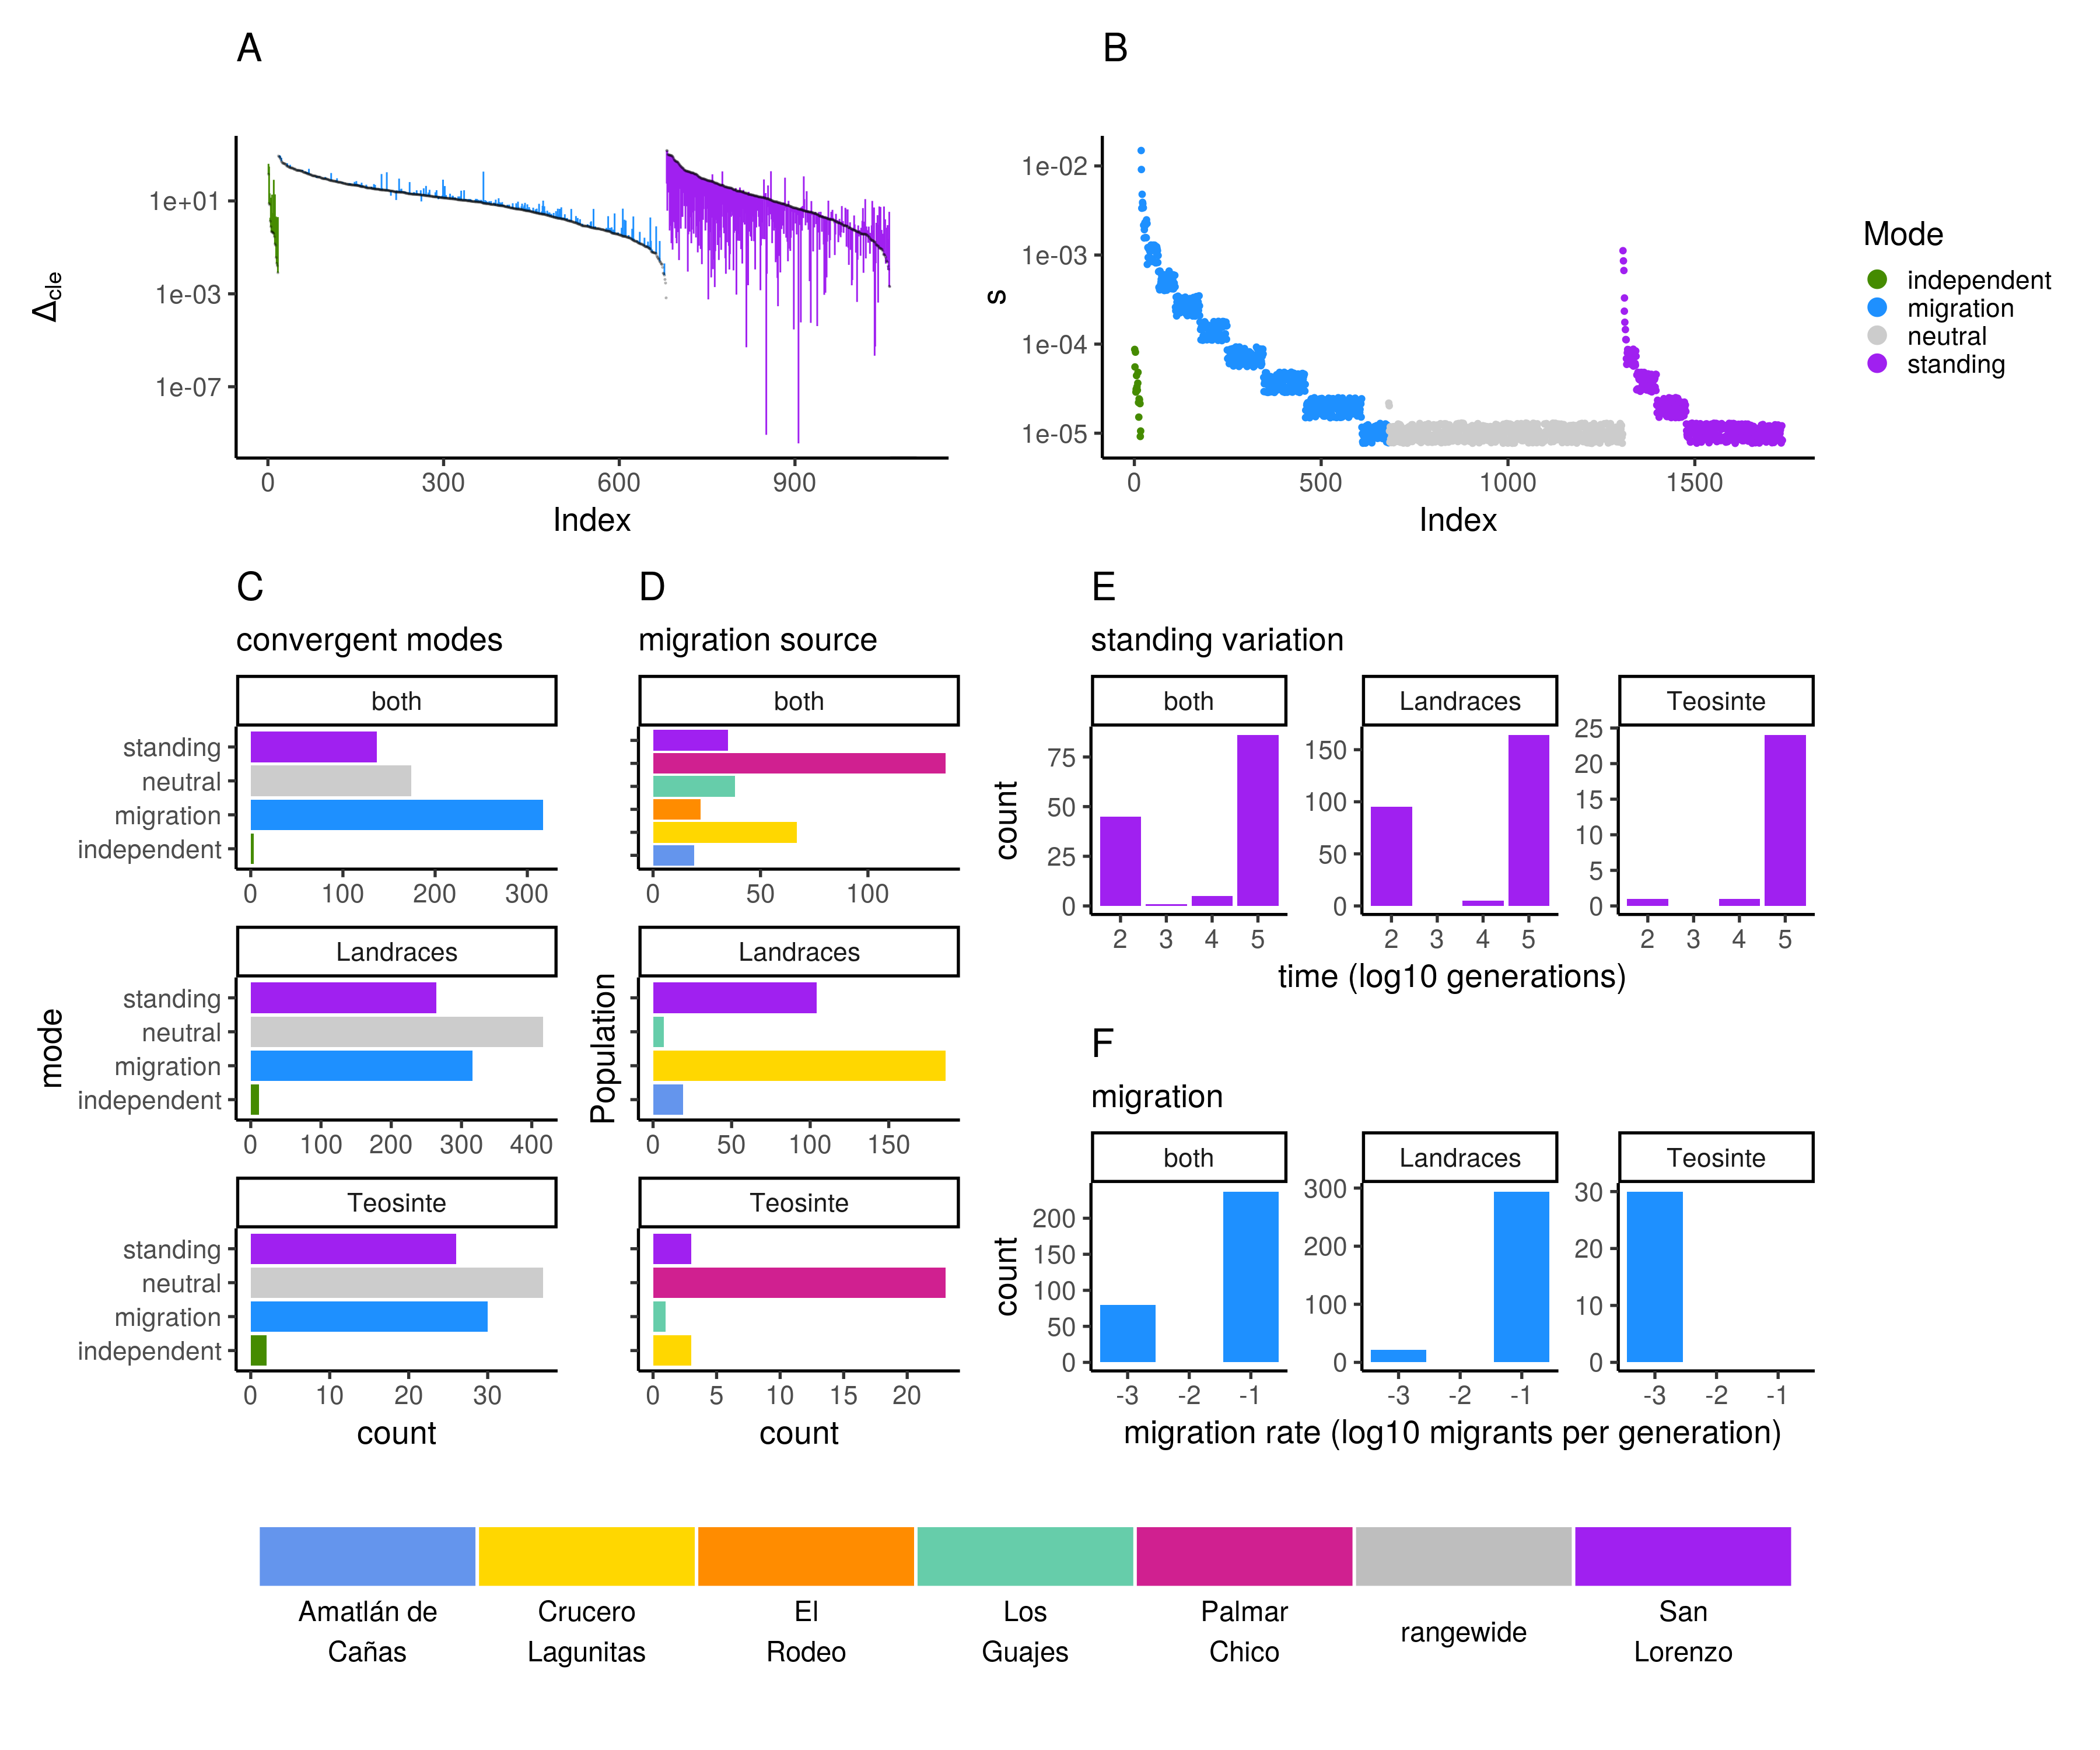

In [18]:

#color_format_df <- color_df %>% 
#    mutate(pop = str_replace_all(pop, "LR_", "Landrace ")) %>% 
#    mutate(pop = str_replace_all(pop, "Teo_", "Teosinte ")) %>% 
#    mutate(pop = str_replace_all(pop, "_", " ")) %>% 
#    mutate(pop = str_remove_all(pop, "random([12])"))


color_format_df <- color_df %>% 
    mutate(pop = str_replace_all(pop, "LR_", "")) %>% 
    mutate(pop = str_replace_all(pop, "Teo_", "")) %>% 
    mutate(pop = str_replace_all(pop, "_", " ")) %>% 
    mutate(pop = str_remove_all(pop, "random([12])"))


FREQ_POPS = c(
    "Landrace Amatlan de Canas",
    "Landrace Crucero Lagunitas",
    "Landrace Los Guajes",
    "Landrace Palmar Chico",
    "Landrace San Lorenzo",
    "Teosinte Amatlan de Canas",
    "Teosinte Crucero Lagunitas",
    "Teosinte El Rodeo",
    "Teosinte Los Guajes",
    "Teosinte Palmar Chico",
    "Teosinte San Lorenzo"
)

id_df <- tibble(sources = 1:length(FREQ_POPS), pop_id = FREQ_POPS) 

top_models_df %>% 
    group_by(type, model2) %>% 
    summarise(n())

top_models_df %>% 
    group_by(model2) %>% 
    summarise(n())

nrow(top_models_df)

mode_plot <- top_models_df %>% 
    group_by(type, model2) %>% 
    summarise(counts = n()) %>% 
    ggplot(aes(model2, counts, fill = model2)) + 
    geom_bar(stat = "identity") +
    facet_wrap(~type, scale = "free", ncol = 1) +
    coord_flip() +
    ylab("count") +
    scale_fill_manual(values = sel_cols) +
    theme(legend.position = "n", strip.text.x = element_text(size = tts_small)) +
    xlab("mode")


print("HERE!")
head(top_models_df)

source_plot <- top_models_df %>%
    filter(model2 == "migration") %>% 
    full_join(., id_df, by = "sources")  %>% 
    mutate(pop_id = str_remove_all(pop_id, "(Landrace |Teosinte )")) %>% 
    left_join(., color_format_df, by = c("pop_id" = "pop")) %>% 
    ggplot(aes(pop_id, fill = color)) +
    geom_bar(stat = "count") +
    xlab("Population") +
    ylab("count") +
    facet_wrap(~type, scale = "free", ncol = 1) +
    coord_flip() +
    scale_fill_identity() +
    theme(axis.text.y = element_blank(), strip.text.x = element_text(size = tts_small))
 

time_plot <- top_models_df %>%
    filter(model2 == "standing") %>% 
    ggplot(aes(log10(times), fill = model2)) +
    geom_bar(stat = "count") +
    ylab("count") +
    xlab("time (log10 generations)") +
    facet_wrap(~type, scale = "free_y") +
    scale_fill_manual(values = sel_cols) +
    theme(strip.text.x = element_text(size = tts_small)) +
    theme(legend.position = "n")


mig_plot <- top_models_df %>%
    filter(model2 == "migration") %>% 
    ggplot(aes(log10(migs), fill = model)) +
    geom_bar(stat = "count") +
    ylab("count") +
    xlab("migration rate (log10 migrants per generation)") +
    facet_wrap(~type, scale = "free_y") +
    scale_fill_manual(values = sel_cols) +
    theme(legend.position = "n", strip.text.x = element_text(size = tts_small))


options(repr.plot.width = 18, repr.plot.height = 15, repr.plot.res = 200)

(((mode_mcle + ggtitle(label = "A", subtitle = "")) +
 (mode_sels + ggtitle(label = "B", subtitle = ""))) / 
((mode_plot + ggtitle("C", subtitle = "convergent modes") + source_plot + ggtitle("D", subtitle = "migration source")) | 
( (time_plot + ggtitle("E", subtitle = "standing variation")) / (mig_plot + ggtitle("F", subtitle = "migration")))) /
 make_legplot(text_size = 6)) +

plot_layout(nrow = 3, heights = c(10,20,7)) +
ggsave("../figures/Figure5.pdf", width = 18, height = 15)


`summarise()` has grouped output by 'ssp'. You can override using the `.groups` argument.



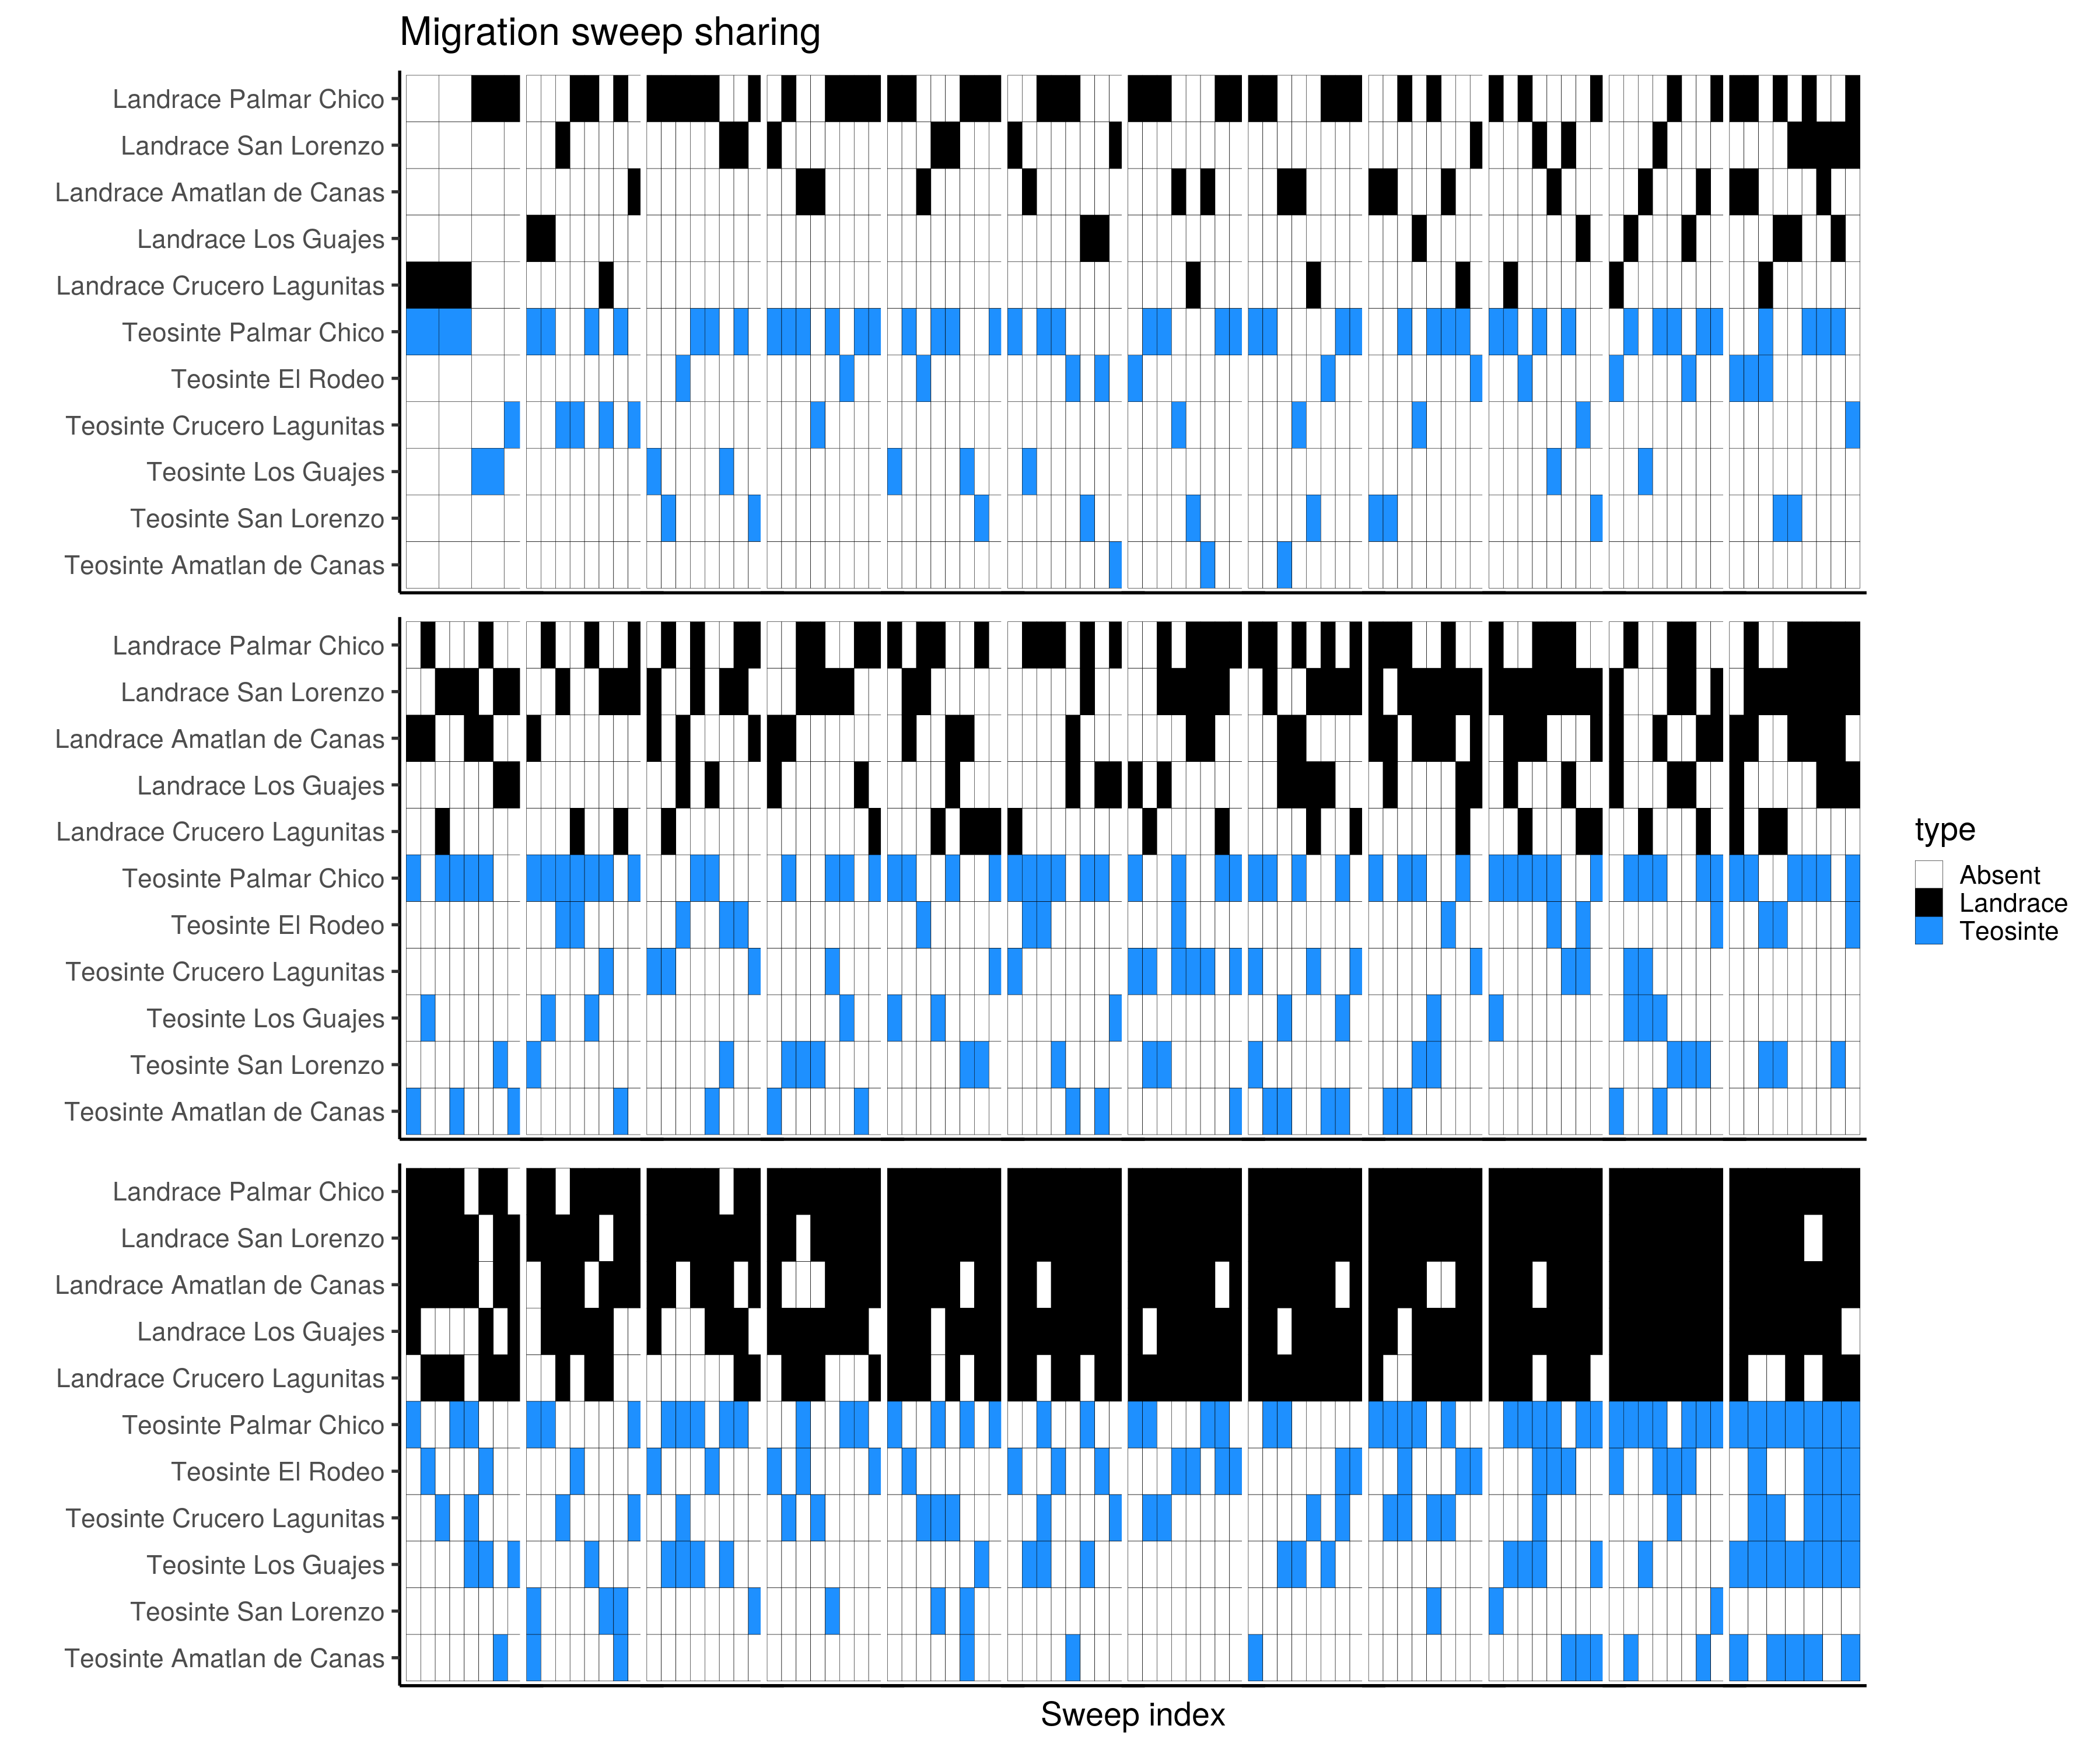

In [264]:

msweep_df <- 
top_models_df %>%  
    filter(model2 == "migration") %>% 
    filter(type == "both") %>% 
    arrange(pop_count) %>% 
    pull(populations) %>%
    str_replace_all("_|--", " ") %>% 
    str_replace_all("LR", "Landrace") %>% 
    str_replace_all("Teo", "Teosinte") %>%
    str_remove_all("RANDOM1 ") %>% 
    map_dfr(~{
        count_vec <- str_count(.x, FREQ_POPS)
        names(count_vec) <- FREQ_POPS
        count_vec
    }) %>% 
    mutate(
        sweep_id = 1:n(), 
        sweep_group = round(sweep_id / 9, 0)) %>%
    pivot_longer(-c(sweep_id, sweep_group), names_to = "pop", values_to = "sweep")

pop_order <- 
msweep_df %>%
    mutate(ssp = ifelse(grepl("Teosinte", pop), "Teo", "LR")) %>%
    group_by(ssp, pop) %>% 
    summarise(summ = sum(sweep)) %>% 
    arrange(summ) %>% 
    arrange(desc(ssp), summ) %>% 
    pull(pop)


plt <- 
msweep_df %>% 
    mutate(pop = factor(pop, levels = pop_order)) %>% 
    mutate(
        type = case_when( 
            grepl("Teosinte", pop) & sweep == 1 ~ "Teosinte",
            grepl("Teosinte", pop) & sweep == 0 ~ "Absent",
            grepl("Landrace", pop) & sweep == 1 ~ "Landrace",
            grepl("Landrace", pop) & sweep == 0 ~ "Absent"
        ) 
    ) %>% 
    #ggplot(aes(sweep_id, pop, fill = factor(sweep))) +
    ggplot(aes(sweep_id, pop, fill = type)) +
    geom_tile(color = "black") +
    facet_wrap(~sweep_group, scales = "free_x", nrow = 3) +
    xlab("Sweep index") +
    ylab("") +
    theme(
      strip.background = element_blank(),
      strip.text.x = element_blank(),
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank(),
      panel.spacing.x = unit(-1, "lines"),  
    ) +
    scale_fill_manual(values = c("white", "black", "dodgerblue")) +
    ggtitle("Migration sweep sharing")

plt + ggsave("../figures/supplement_sweeps.pdf", width = 18, height = 15)


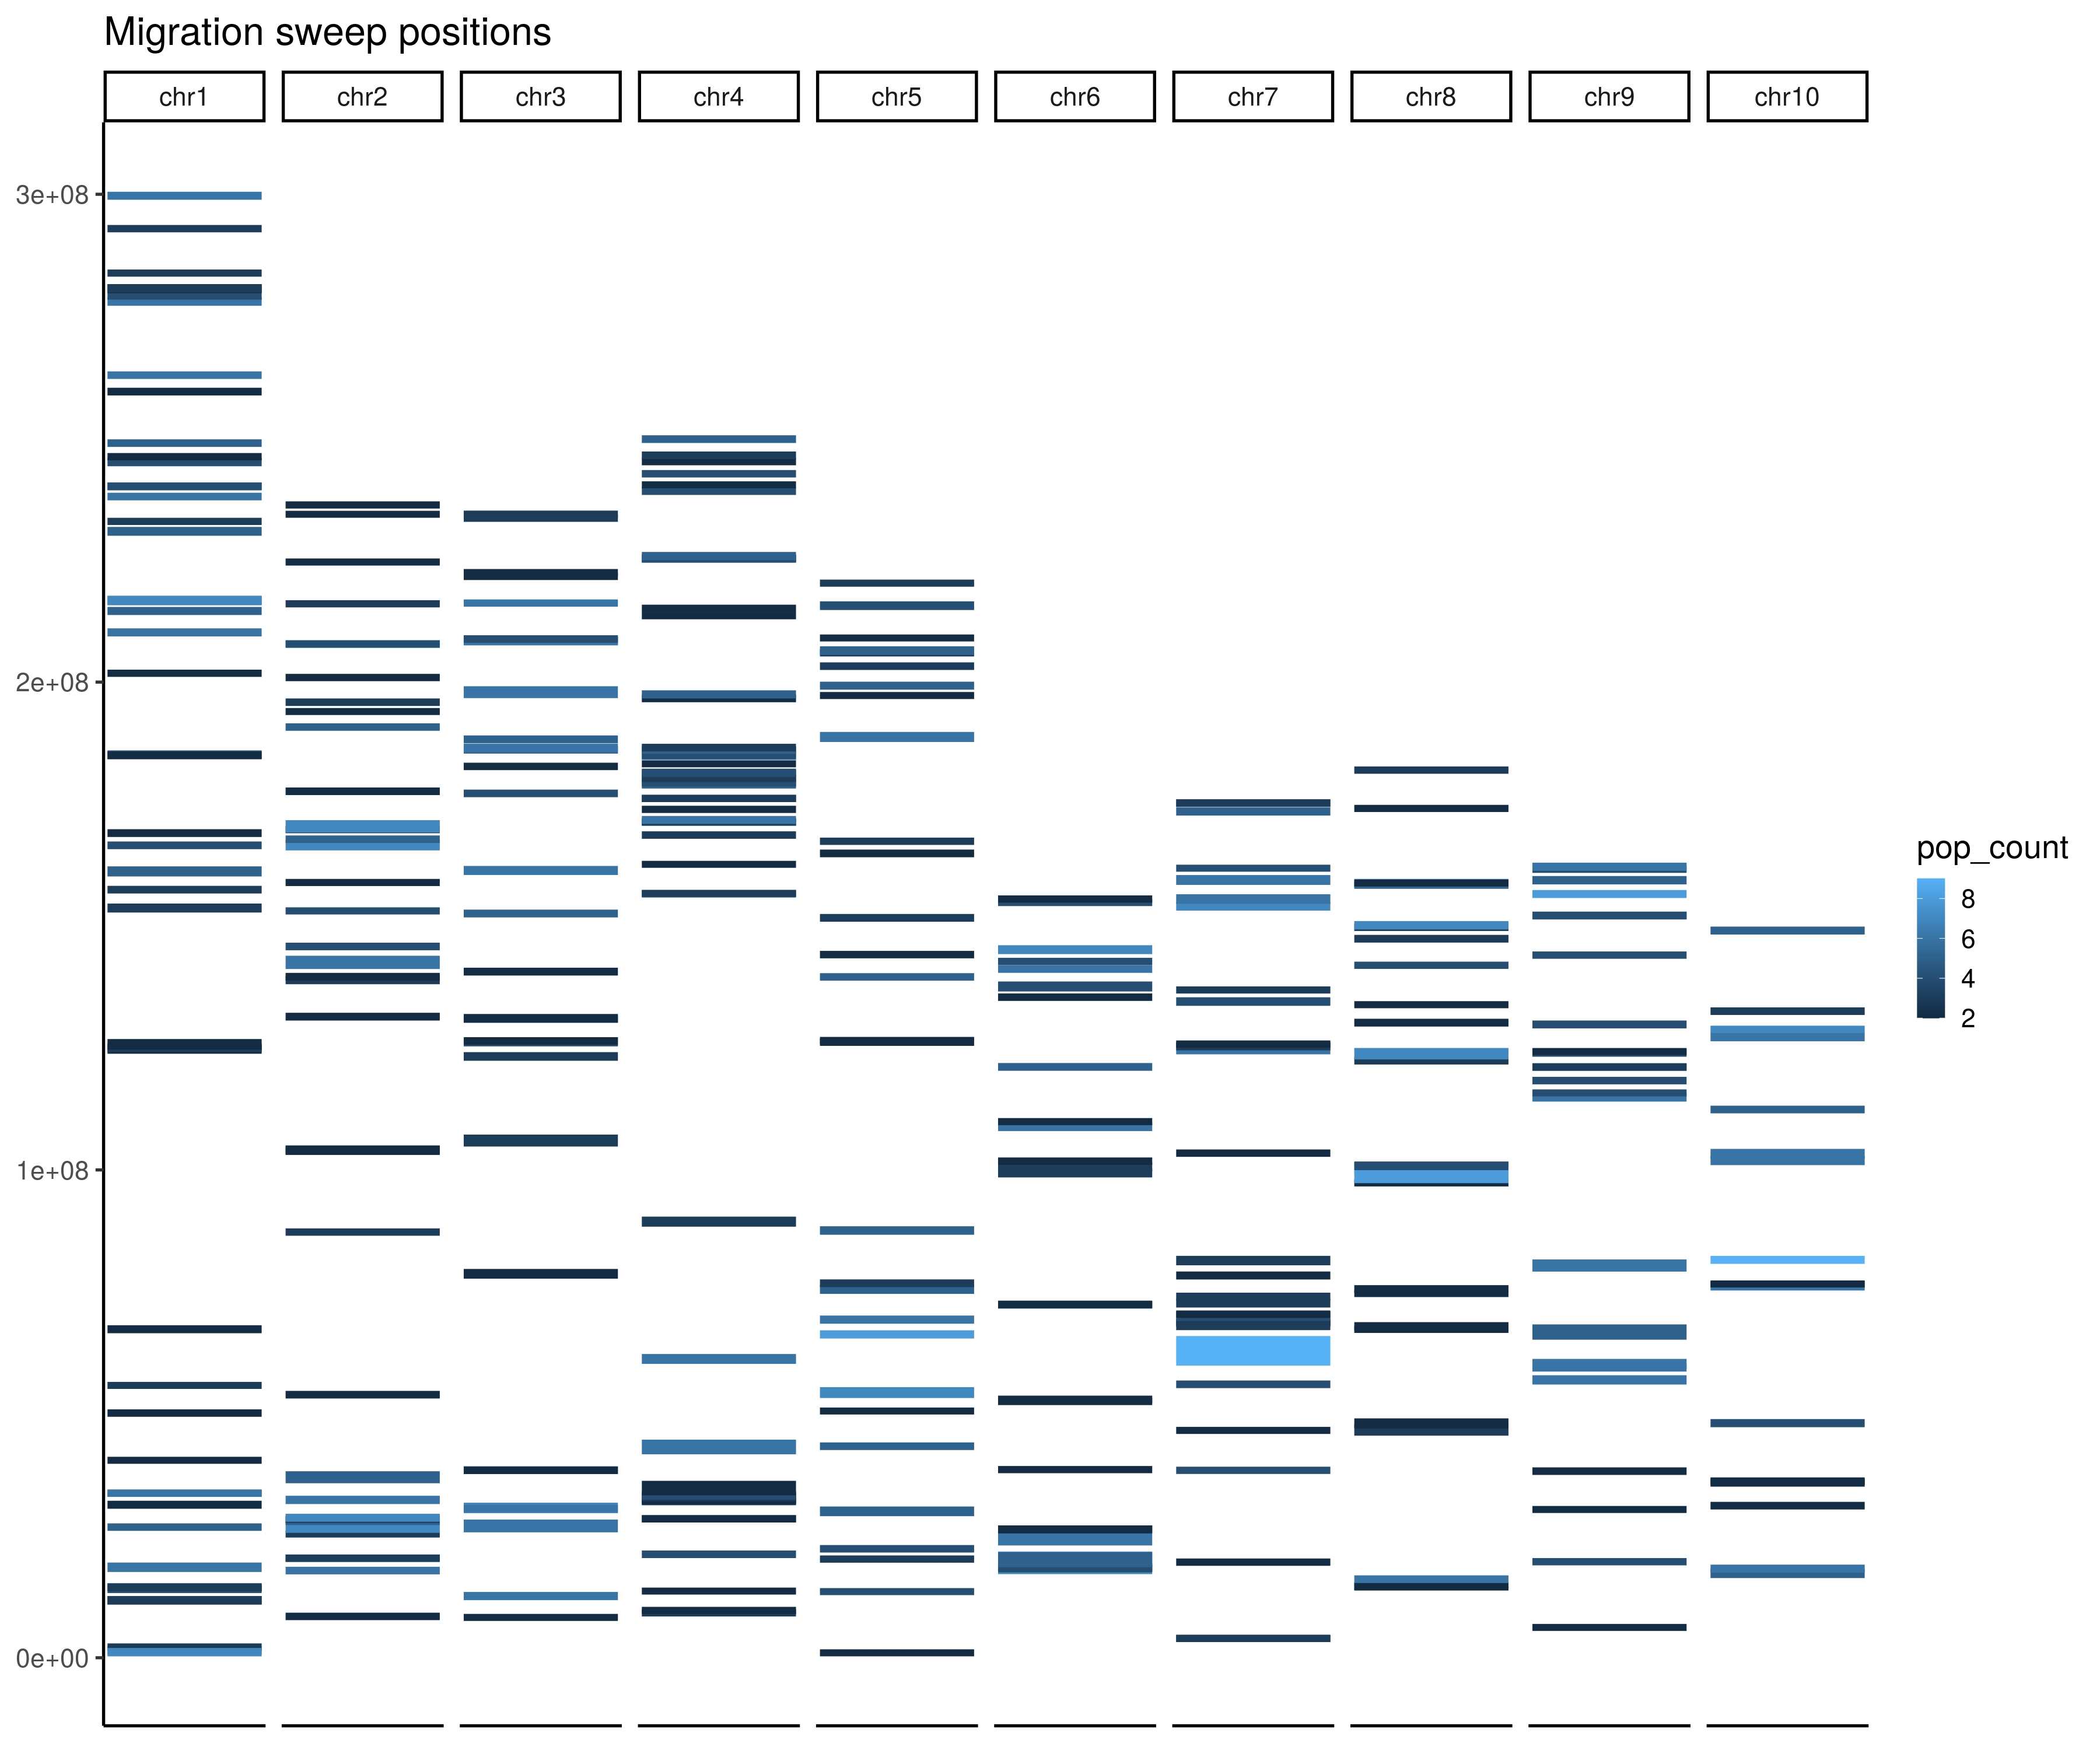

In [263]:
top_models_df %>%
    filter(model2 == "migration") %>% 
    filter(type == "both") %>% 
    mutate(chrom = str_extract(locus, "chr[0-9][0-9]*")) %>%
    mutate(chrom = factor(chrom, levels = paste0("chr", 1:10))) %>% 
    filter(model2 == "migration") %>% 
    filter(type == "both") %>% 
    ggplot() +
    geom_rect(aes(xmin = 0, xmax = 1, ymin = sweep_start_bp, ymax = sweep_end_bp, color = pop_count, fill = pop_count), lwd = 2) +
    facet_grid(~chrom) +
    theme(axis.text.x = element_blank(),
         axis.ticks.x = element_blank()) +
    ggtitle("Migration sweep positions") +
    ggsave("../figures/supplement_sweeps_locs.pdf", width = 14, height = 15)


# Just exploratory analyses from here down

In [19]:
source("../color_df.R")

color_df
tree_plotter <- function(tree, dge = 110){

    tree$tip.label <- str_remove_all(tree$tip.label, "v5--")
    tree_string <- drop.tip(tree, tip = c("Teo--Palmar_Chico", "Teo--random2_Palmar_Chico", "LR--Palmar_Chico", "LR--random2_Palmar_Chico"))

    #png(filename = "../figures/raw_tree.png", res = 300, width = 5, height = 5, units = "in")
    #pdf("../figures/raw_tree.pdf", width = 5, height = 5)

    par(mar = c(0,0,2,0))
    plot.phylo(tree_string, type = "unrooted", show.tip.label = FALSE, 
               rotate.tree = dge, edge.width = 2, no.margin = TRUE)
    tip_str <- str_replace(tree_string$tip.label, "--", "_")
    tip_str <- str_replace(tip_str, "RANDOM", "random")
    
    tip_pch <- ifelse(grepl("Teo", x = tip_str), 21, 24)
    tiplabels(pch = tip_pch, bg = color_df$color[match(tip_str, color_df$pop)], cex = 3.5)
    #tiplabels(text = tip_str)
    #box()
    
    #text(0.08,0.0, "Landraces", cex = 1.5)
    #text(0.08,0.1, "Teosinte", cex = 1.5)

    par(new=TRUE)
    plot.phylo(tree_string, type = "unrooted", show.tip.label = FALSE, 
               rotate.tree = dge, edge.width = 2.5, no.margin = TRUE)

    legend_df <- color_df %>% 
        mutate(pop = str_replace(pop, pattern = "(LR|Teo)_(.)", "\\2") %>% str_replace("random(1|2)_", "")) %>% 
        distinct() %>% 
        filter(pop != "random")
    #legend('right', cex = 1, legend_df$pop, pch = 21, pt.bg = legend_df$color, ncol = 1)
    #dev.off()

    #treeplot <- image_ggplot(image_read("../figures/raw_tree.pdf"), interpolate = TRUE) + theme(plot.margin = margin(0, 0, 0, 0, "cm"))

}


pop                      color           
1  LR_Los_Guajes            mediumaquamarine
2  Teo_Los_Guajes           mediumaquamarine
3  LR_Crucero_Lagunitas     gold            
4  Teo_Crucero_Lagunitas    gold            
5  LR_El_Rodeo              darkorange      
6  Teo_El_Rodeo             darkorange      
7  LR_Amatlan_de_Canas      cornflowerblue  
8  Teo_Amatlan_de_Canas     cornflowerblue  
9  LR_San_Lorenzo           purple          
10 Teo_San_Lorenzo          purple          
11 LR_Palmar_Chico          violetred       
12 Teo_Palmar_Chico         violetred       
13 LR_random1_Palmar_Chico  violetred       
14 Teo_random1_Palmar_Chico violetred       
15 LR_random2_Palmar_Chico  violetred       
16 Teo_random2_Palmar_Chico violetred       
17 LR_random                grey            
18 Teo_random               grey

In [20]:

permute_ssp <- function(n_permute = 100, neut_mat, sweep_mat, ssp_labels = c("LR", "Teo"), return_mean = F){
    
    mt1 <- map_dbl(1:n_permute, ~mantel.test(as.matrix(neut_mat), as.matrix(sweep_mat)[c(sample(which(grepl(ssp_labels[1], tree_pops))), which(grepl(ssp_labels[2], tree_pops))),])$p)
    mt2 <- map_dbl(1:n_permute, ~mantel.test(as.matrix(neut_mat), as.matrix(sweep_mat)[c(which(grepl(ssp_labels[1], tree_pops)), sample(which(grepl(ssp_labels[2], tree_pops)))),])$p)

    p_df <- 
    bind_rows(
        tibble(ssp = ssp_labels[1], p = mt1),
        tibble(ssp = ssp_labels[2], p = mt2)
    
    )
    
    if(return_mean){
        return(group_by(p_df, ssp) %>% summarise(mean_p = mean(p)))
    } else {
        return(p_df)
    }
}

In [21]:
tree_string <- read.tree(text = readLines(gzfile("../data/angsd_treemix/v5_treemix.treeout.gz")))
tree_string <- drop.tip(tree_string, tip = c("Teo--random1_Palmar_Chico", "Teo--random2_Palmar_Chico", "LR--random1_Palmar_Chico", "LR--random2_Palmar_Chico"))

tree_string$tip.label <- paste0("v5--", tree_string$tip.label)
neut_mat <- cophenetic(tree_string)

In [22]:
top_models_df %>%
    filter(model2 == "migration") %>%
    full_join(., id_df, by = "sources")  %>% head()
    mutate(pop_id = str_remove_all(pop_id, "(Landrace |Teosinte )")) %>% 
    left_join(., color_format_df, by = c("pop_id" = "pop")) %>% head()


selected_sites sels         cle      
1  10410007      5.179475e-04  55305.28
2  10466113      1.389495e-04  49669.78
3 105788654      1.930698e-05 233335.99
4  11950323      1.930698e-05 156653.10
5  11807692      1.389495e-04 153239.98
6 124675996      1.930698e-05  26010.67
  locus                                                                                         
1 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start10382710_end10518322_pops1-2-3-4-5.txt
2 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start10430149_end10517583_pops1-2-3-4-5.txt
3 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start105341513_end106181745_pops3-4-5.txt  
4 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start11622449_end11937910_pops1-4-8.txt    
5 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start11628071_end11925113_pops1-4-8.txt    
6 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start124526064_end124853407_pops2-10.txt   
  gs times migs  sources sel_pops  model     ⋯ mcle_delta mcle_nextbest_diff
1 NA NA    0.100  2      1-2-3-4-5 migration ⋯ 0           4.4637669        
2 NA NA    0.100  2      1-2-3-4-5 migration ⋯ 0           3.8050849        
3 NA NA    0.100  5      3-4-5     migration ⋯ 0           0.5842252        
4 NA NA    0.100  8      1-4-8     migration ⋯ 0           9.2932288        
5 NA NA    0.100  8      1-4-8     migration ⋯ 0          15.9880913        
6 NA NA    0.001 10      2-10      migration ⋯ 0          68.8574815        
  file_name                                                                                   
1 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start10382710_end10518322_pops1-2-3-4-5.txt
2 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start10430149_end10517583_pops1-2-3-4-5.txt
3 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start105341513_end106181745_pops3-4-5.txt  
4 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start11622449_end11937910_pops1-4-8.txt    
5 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start11628071_end11925113_pops1-4-8.txt    
6 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start124526064_end124853407_pops2-10.txt   
  populations                                                                                                               
1 v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo
2 v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo
3 v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo                                                     
4 v5--LR--Amatlan_de_Canas; v5--LR--RANDOM1_Palmar_Chico; v5--Teo--El_Rodeo                                                 
5 v5--LR--Amatlan_de_Canas; v5--LR--RANDOM1_Palmar_Chico; v5--Teo--El_Rodeo                                                 
6 v5--LR--Crucero_Lagunitas; v5--Teo--RANDOM1_Palmar_Chico                                                                  
  type      pop_count Landraces_count Teosinte_count model2   
1 Landraces 5         5               0              migration
2 Landraces 5         5               0              migration
3 Landraces 3         3               0              migration
4 both      3         2               1              migration
5 both      3         2               1              migration
6 both      2         1               1              migration
  pop_id                    
1 Landrace Crucero Lagunitas
2 Landrace Crucero Lagunitas
3 Landrace San Lorenzo      
4 Teosinte El Rodeo         
5 Teosinte El Rodeo         
6 Teosinte Palmar Chico

ERROR: Error in stri_replace_all_regex(string, pattern, fix_replacement(replacement), : object 'pop_id' not found


In [ ]:
options(repr.plot.width = 10, repr.plot.height = 12, repr.plot.res = 200)


FREQ_POPS2 = c(
    "chrom",
    "start",
    "end",
    "v5--LR--Amatlan_de_Canas",
    "v5--LR--Crucero_Lagunitas",
    "v5--LR--Los_Guajes",
    "v5--LR--random1_Palmar_Chico",
    "v5--LR--San_Lorenzo",
    "v5--Teo--Amatlan_de_Canas",
    "v5--Teo--Crucero_Lagunitas",
    "v5--Teo--El_Rodeo",
    "v5--Teo--Los_Guajes",
    "v5--Teo--random1_Palmar_Chico",
    "v5--Teo--San_Lorenzo"
)

MIN_FREQ <- 1/20

neutral_freqs <- vroom::vroom(file = "../data/rdmc/v5--neutral_freqs.txt",   
    delim = "\t",
    col_names = FREQ_POPS2) %>%
    mutate(varz = apply(dplyr::select(., -c(chrom, start, end)), 1, max)) %>% 
    filter(varz >= MIN_FREQ) %>%
    sample_n(50000) %>% 
    dplyr::select(-varz) 


#neut_mat <- neutral_freqs %>% 
#    dplyr::select(-c(chrom, start, end)) %>% 
#    t() %>% 
#    dist()





#plot.phylo(nj(neut_mat), type = "unrooted", cex = 0.7)

tree_pops <- c(
    "v5--LR--Amatlan_de_Canas", 
    "v5--LR--Crucero_Lagunitas", 
    "v5--LR--Los_Guajes", 
    "v5--LR--RANDOM1_Palmar_Chico", 
    "v5--LR--San_Lorenzo", 
    "v5--Teo--Amatlan_de_Canas", 
    "v5--Teo--Crucero_Lagunitas", 
    "v5--Teo--El_Rodeo", 
    "v5--Teo--Los_Guajes", 
    "v5--Teo--RANDOM1_Palmar_Chico", 
    "v5--Teo--San_Lorenzo"
)



get_sweep_aln <- function(type_str){
    
    sp_df <- top_models_df %>% filter(model2 == type_str)

    share_aln <- map_dfc(1:nrow(sp_df), function(c){
        tibble(as.numeric(map_lgl(tree_pops, ~grepl(.x, sp_df$populations[c])))) %>% 
        set_colnames(paste0("s", c))
    })

    rownames(share_aln) <- tree_pops

    sweep_mat <- dist(share_aln)    
    return(sweep_mat)
    
}


sweep_mat_neutral <- get_sweep_aln("neutral")
p_neut <- round(mantel.test(as.matrix(neut_mat), as.matrix(sweep_mat_neutral))$p, 3)
p_neut
print(permute_ssp(n_permute = 100, neut_mat = as.matrix(neut_mat), sweep_mat = as.matrix(sweep_mat_neutral), ssp_labels = c("LR", "Teo"), return_mean = T))
#plot.phylo(nj(sweep_mat_neutral), type = "unrooted", cex = 0.7)



sweep_mat_migs <- get_sweep_aln("migration")
p_mig <- round(mantel.test(as.matrix(neut_mat), as.matrix(sweep_mat_migs))$p, 3)
p_mig
print(permute_ssp(n_permute = 100, neut_mat = as.matrix(neut_mat), sweep_mat = as.matrix(sweep_mat_migs), ssp_labels = c("LR", "Teo"), return_mean = T))


#plot.phylo(nj(sweep_mat_migs), type = "unrooted", cex = 0.7)


sweep_mat_standing <- get_sweep_aln("standing")
p_stand <- round(mantel.test(as.matrix(neut_mat), as.matrix(sweep_mat_standing))$p, 3)
p_stand
print(permute_ssp(n_permute = 100, neut_mat = as.matrix(neut_mat), sweep_mat = as.matrix(sweep_mat_standing), ssp_labels = c("LR", "Teo"), return_mean = T))


#plot.phylo(nj(sweep_mat_standing), type = "unrooted", cex = 0.7)



In [ ]:
pdf(str_glue("../figures/tree_legend.pdf"), width = 15, height = 15)
par(mar = c(0,0,0,0))
plot(0, 0, type = "n", axes = F)
legend("center", c("Teosinte", "Landraces"), pch = c(21, 24), pt.lwd = 6, bty = "n", cex = 7)
dev.off()
tree_legend <- image_ggplot(image_read("../figures/tree_legend.pdf")) + theme(plot.margin = margin(0, 0, 0, 0, "cm"))    
tree_legend

In [ ]:
library(magick)

gg_file_tree <- function(mat, dge){

    pdf(str_glue("../figures/{mat}.pdf"), width = 6, height = 4)
    tree_plotter(nj(eval(parse(text = mat))), dge = dge)
    dev.off()
    image_ggplot(image_read(str_glue("../figures/{mat}.pdf")), interpolate = TRUE) + 
    theme(plot.margin = margin(0, 0, 0, 0, "cm"))    
}

neutral_plot <- gg_file_tree("neut_mat", 60+150)
sweep_neutral_plot <- gg_file_tree("sweep_mat_neutral", 70 + 180)
sweep_mig_plot <- gg_file_tree("sweep_mat_migs", 90 + 180)
sweep_standing_plot <- gg_file_tree("sweep_mat_standing", -100)
sweep_standing_plot

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 8, repr.plot.res = 200)

((mode_mcle + ggtitle(label = "A", subtitle = "\n")) +
 (mode_sels+ ggtitle(label = "B", subtitle = "\n"))) / 
((neutral_plot + ggtitle(label = "C", subtitle = "Allele frequencies\n") + theme(plot.title = element_text(face = "bold"))) + 
 (sweep_neutral_plot + ggtitle(label = "", subtitle = str_glue("Neutral Sweeps\n(p = {p_neut})"))) + 
 (sweep_mig_plot + ggtitle(label = "", subtitle = str_glue("Migration Sweeps\n(p = {p_mig})"))) + 
 (sweep_standing_plot + ggtitle(label = "", subtitle = str_glue("Standing Sweeps\n(p = {p_stand})"))) +
 (tree_legend) +
 plot_layout(nrow = 1))


In [ ]:
options(repr.plot.width = 7, repr.plot.height = 6 , repr.plot.res = 200)


shareplot <- top_models_df %>%
    mutate(
        pop_count = str_count(populations, ",") + 1,
        Landraces_count = str_count(populations, "LR"),
        Teosinte_count =  str_count(populations, "Teo")        
        ) %>% 
    filter(Landraces_count != 0 | Teosinte_count != 0) %>%
    group_by(Landraces_count, Teosinte_count) %>% 
    summarise(type_count = n()) %>% 
    ggplot(aes(Landraces_count, Teosinte_count, fill = log10(type_count))) +
    geom_tile(color = "black") +
    scale_fill_gradient(low = "white", high = "black") +
    scale_y_continuous(breaks = 0:8) +
    scale_x_continuous(breaks = 0:8) +
    geom_abline(intercept = 0, slope = 1, lty = 3) +
    xlab("Number of Landrace populations") +
    ylab("Number of Teosinte populations") +
    labs(fill = expression(paste(log[10], " count")))
    
shareplot

In [ ]:
all_pops <- c(
    "v5--LR--Amatlan_de_Canas", 
    "v5--LR--Crucero_Lagunitas", 
    "v5--LR--Los_Guajes", 
    "v5--LR--random1_Palmar_Chico", 
    "v5--LR--San_Lorenzo", 
    "v5--Teo--Amatlan_de_Canas", 
    "v5--Teo--Crucero_Lagunitas", 
    "v5--Teo--El_Rodeo", 
    "v5--Teo--Los_Guajes", 
    "v5--Teo--random1_Palmar_Chico", 
    "v5--Teo--San_Lorenzo"
)

pop_pairs <- 
combn(all_pops, 2) %>% 
    t() %>% 
    data.frame() %>% 
    set_colnames(c("pop1", "pop2")) %>% 
    as_tibble() %>% 
    mutate(pop1 = str_replace_all(pop1, "random1", "RANDOM1"),
           pop2 = str_replace_all(pop2, "random2", "RANDOM2"))
head(pop_pairs)



pair_df <- 

c("both", "Teosinte", "Landraces") %>% 
map_df(~{
    pop_pairs %>%
        rowwise() %>% 
        pmap_df(function(pop1, pop2){

                share_count <- filter(top_models_df, grepl(pop1, populations), 
                                      grepl(pop2, populations), type == .x) %>% 
                nrow()
                if(share_count > 0){
                    tibble(pop1, pop2, share_count, type = .x)
                } else{
                    tibble()
                }
                
        })

    }) %>% 
    arrange(desc(share_count))


pop_count_df <- 
    all_pops %>% 
    map_df(~ {
        pcount <- filter(top_models_df, grepl(.x, populations)) %>% 
            nrow()
        tibble(pop = .x, count_pop1 = pcount, count_pop2 = pcount)
    })

head(pop_count_df)

pair_df %>% 
    filter(type == "Teosinte", grepl("LR", pop1), grepl("LR", pop2))


sweep_counts_df <- top_models_df %>% 
    group_by(type) %>% 
    summarise(total_sweeps = n()) %>%
    ungroup() %>% 
    mutate(total_sweeps = ifelse(type == "both", sum(.$total_sweeps), total_sweeps))
sweep_counts_df


top_models_df %>% 
    filter(pop_count > 1) %>% 
    ggplot(aes(log10(sweepsize_cM), colour = type)) +
    geom_density() +
    xlab(expression(paste(log[10], " sweep size")))


top_models_df %>% 
    filter(pop_count > 1, model2 %in% c("migration, independent", "standing")) %>% 
    ggplot(aes(log10(sweepsize_cM), pop_count, colour = type)) +
    geom_point() +
    facet_wrap(~type, ncol = 1) +
    xlab(expression(paste(log[10], " sweep size"))) +
    ylab("Number of populations")


pair_df <- 

c("both", "Teosinte", "Landraces") %>% 
map_df(~{
    pop_pairs %>%
        rowwise() %>% 
        pmap_df(function(pop1, pop2){

                share_count <- filter(top_models_df, grepl(pop1, populations), 
                                      grepl(pop2, populations), type == .x) %>% 
                nrow()
                if(share_count > 0){
                    tibble(pop1, pop2, share_count, type = .x)
                } else{
                    tibble()
                }
                
        })

    }) %>% 
    arrange(desc(share_count))


pop_count_df <- 
    all_pops %>% 
    map_df(~ {
        pcount <- filter(top_models_df, grepl(.x, populations)) %>% 
            nrow()
        tibble(pop = .x, count_pop1 = pcount, count_pop2 = pcount)
    })

head(pop_count_df)

pair_df %>% 
    filter(type == "Teosinte", grepl("LR", pop1), grepl("LR", pop2))



In [ ]:
false_positive <- 0.5

full_pair_df <- pair_df %>% 
    left_join(., dplyr::select(pop_count_df, -count_pop2), by = c("pop1" = "pop")) %>% 
    left_join(., dplyr::select(pop_count_df, -count_pop1), by = c("pop2" = "pop")) %>% 
    mutate(
        populations = paste(pop1, pop2, sep = ","),
        pair_type = case_when(
               grepl("LR", populations) & grepl("Teo", populations) ~ "both",
               grepl("LR", populations) & !grepl("Teo", populations) ~ "Landraces",
               !grepl("LR", populations) & grepl("Teo", populations) ~ "Teosinte",
               TRUE ~ "nan")
    ) %>% 
    separate(pop1, c("ref", "ssp1", "pop1"), "--") %>% 
    separate(pop2, c("ref", "ssp2", "pop2"), "--") %>% 
    mutate(geography = case_when(
        ssp1 != ssp2 & pop1 == pop2 ~ "sympatric",
        TRUE ~ "allopatric"
    )) %>% 
    full_join(., sweep_counts_df, by = "type") %>% 
    arrange(desc(share_count))

false_positive_df <- full_pair_df %>% 
    filter(ssp1 == ssp2, 
           pop1 %in% c("RANDOM1_Palmar_Chico", "RANDOM2_Palmar_Chico"),
           pop2 %in% c("RANDOM1_Palmar_Chico", "RANDOM2_Palmar_Chico")) %>% 
    mutate(false_positive = (share_count/count_pop1 + share_count/count_pop2)/2)

false_positive_df$false_positive

full_pair_df %>% 
    filter(ssp1 == "Teo", ssp2 == "Teo", type == "Landraces")

In [ ]:
false_positive <- 0.5

pair_test_df <- 
full_pair_df %>%
    rowwise() %>% 
    mutate(
        p = -phyper(q = as.integer(share_count*false_positive)-1,
           m = as.integer(min(count_pop1, count_pop2)*false_positive),
           n = as.integer(total_sweeps*false_positive - min(count_pop1, count_pop2)*false_positive),
           k = as.integer(max(count_pop1, count_pop2)*false_positive), lower.tail = FALSE, log.p = TRUE),
        p_lower = -phyper(q = as.integer(share_count*false_positive)-1,
           m = as.integer(min(count_pop1, count_pop2)*false_positive),
           n = as.integer(total_sweeps*false_positive - min(count_pop1, count_pop2)*false_positive),
           k = as.integer(max(count_pop1, count_pop2)*false_positive), lower.tail = TRUE, log.p = TRUE),
        age = case_when(type == "both" ~ "old", TRUE ~ "young")
    ) %>% 
    mutate(pop1 = str_remove_all(pop1, "RANDOM1_"),
           pop2 = str_remove_all(pop2, "RANDOM1_")) %>% 
    left_join(., color_df, by = c("pop1" = "pop")) %>% 
    rename(color_pop1 = color) %>% 
    left_join(., color_df, by = c("pop2" = "pop")) %>% 
    rename(color_pop2 = color) 


pair_test_df

In [ ]:
plot_pair_df <- 
pair_test_df %>% 
    filter(pop1 != "RANDOM2_Palmar_Chico", pop2 != "RANDOM2_Palmar_Chico") %>% 
    mutate(pop1 = str_replace_all(pop1, "random", "rangewide"),
           pop2 = str_replace_all(pop2, "random", "rangewide"),
           ssp_pop1 = paste0(ssp1 ," ", pop1),
           ssp_pop2 = paste0(ssp2 ," ", pop2))  %>%  
    ungroup() %>% 
    mutate(pop1_idx = as.numeric(as.factor(pop1))) %>%
    mutate(pop2_idx = as.numeric(as.factor(pop2)))


plot_pair_df %>% 
    ggplot(aes(ssp_pop1, ssp_pop2, color = p, size = share_count)) +
    geom_point() +
    geom_point(aes(ssp_pop1, ssp_pop2, size = share_count), shape = 1, inherit.aes = F) +
    geom_point(aes(ssp_pop1, ssp_pop2, size = share_count), shape = 1, inherit.aes = F) +
    facet_wrap(~age+pair_type, scales = "free") +
    scale_colour_gradient(low = "white", high = "black") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1), strip.text.x = element_text(size = tts_small)) 



p_top5 <- pair_test_df %>% 
    filter(pop1 != "RANDOM2_Palmar_Chico", pop2 != "RANDOM2_Palmar_Chico") %>% 
    filter(p > 5)
    #group_by(type) %>% 
    #arrange(p_lower) %>% 
    #slice(1:6) %>% 
    #filter(type !="Teosinte")

p_low_top5 <- pair_test_df %>% 
    filter(pop1 != "RANDOM2_Palmar_Chico", pop2 != "RANDOM2_Palmar_Chico") %>% 
    filter(p_lower > 5)
    #group_by(type) %>% 
    #arrange(desc(p_lower)) %>% 
    #slice(1:6) 


pair_test_df %>% 
    filter(pop1 != "RANDOM2_Palmar_Chico", pop2 != "RANDOM2_Palmar_Chico") %>% 
    ggplot(aes(pair_type, p)) +
    #geom_jitter(aes(colour = color_pop1, bg = color_pop2), stroke = 2, shape = 21, width = 0.2, height = 0, size = 3) +
    geom_jitter(aes(colour = color_pop1), width = 0.2, height = 0, size = 3) +
    facet_wrap(~age, scales = "free_x") +
    scale_color_identity()


pair_test_df %>% 
    filter(pop1 != "RANDOM2_Palmar_Chico", pop2 != "RANDOM2_Palmar_Chico") %>% 
    ggplot(aes(pair_type, p_lower)) +
    #geom_jitter(aes(colour = pop1, bg = pop2), stroke = 2, shape = 21, width = 0.2, height = 0, size = 3) +
    geom_jitter(aes(colour = color_pop1), width = 0.2, height = 0, size = 3) +    
    facet_wrap(~age, scales = "free_x") +
    scale_color_identity()

